# Split Barcode

Random simulations of barcoded cells being passaged

adapted from: 20210927_RAR035_Split_barcode_random_simulation

last updated 20221005

In [8]:
import numpy as np 
import matplotlib.pyplot as plt



import random
from scipy import stats
from scipy.stats import ttest_rel

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Load in Imaging data

      values names
0        274    10
1        126    10
2         90    10
3        195    10
4          9    10
...      ...   ...
1185       6    cl
1186       1    cl
1187       3    cl
1188      12    cl
1189       4    cl

[1190 rows x 2 columns] 



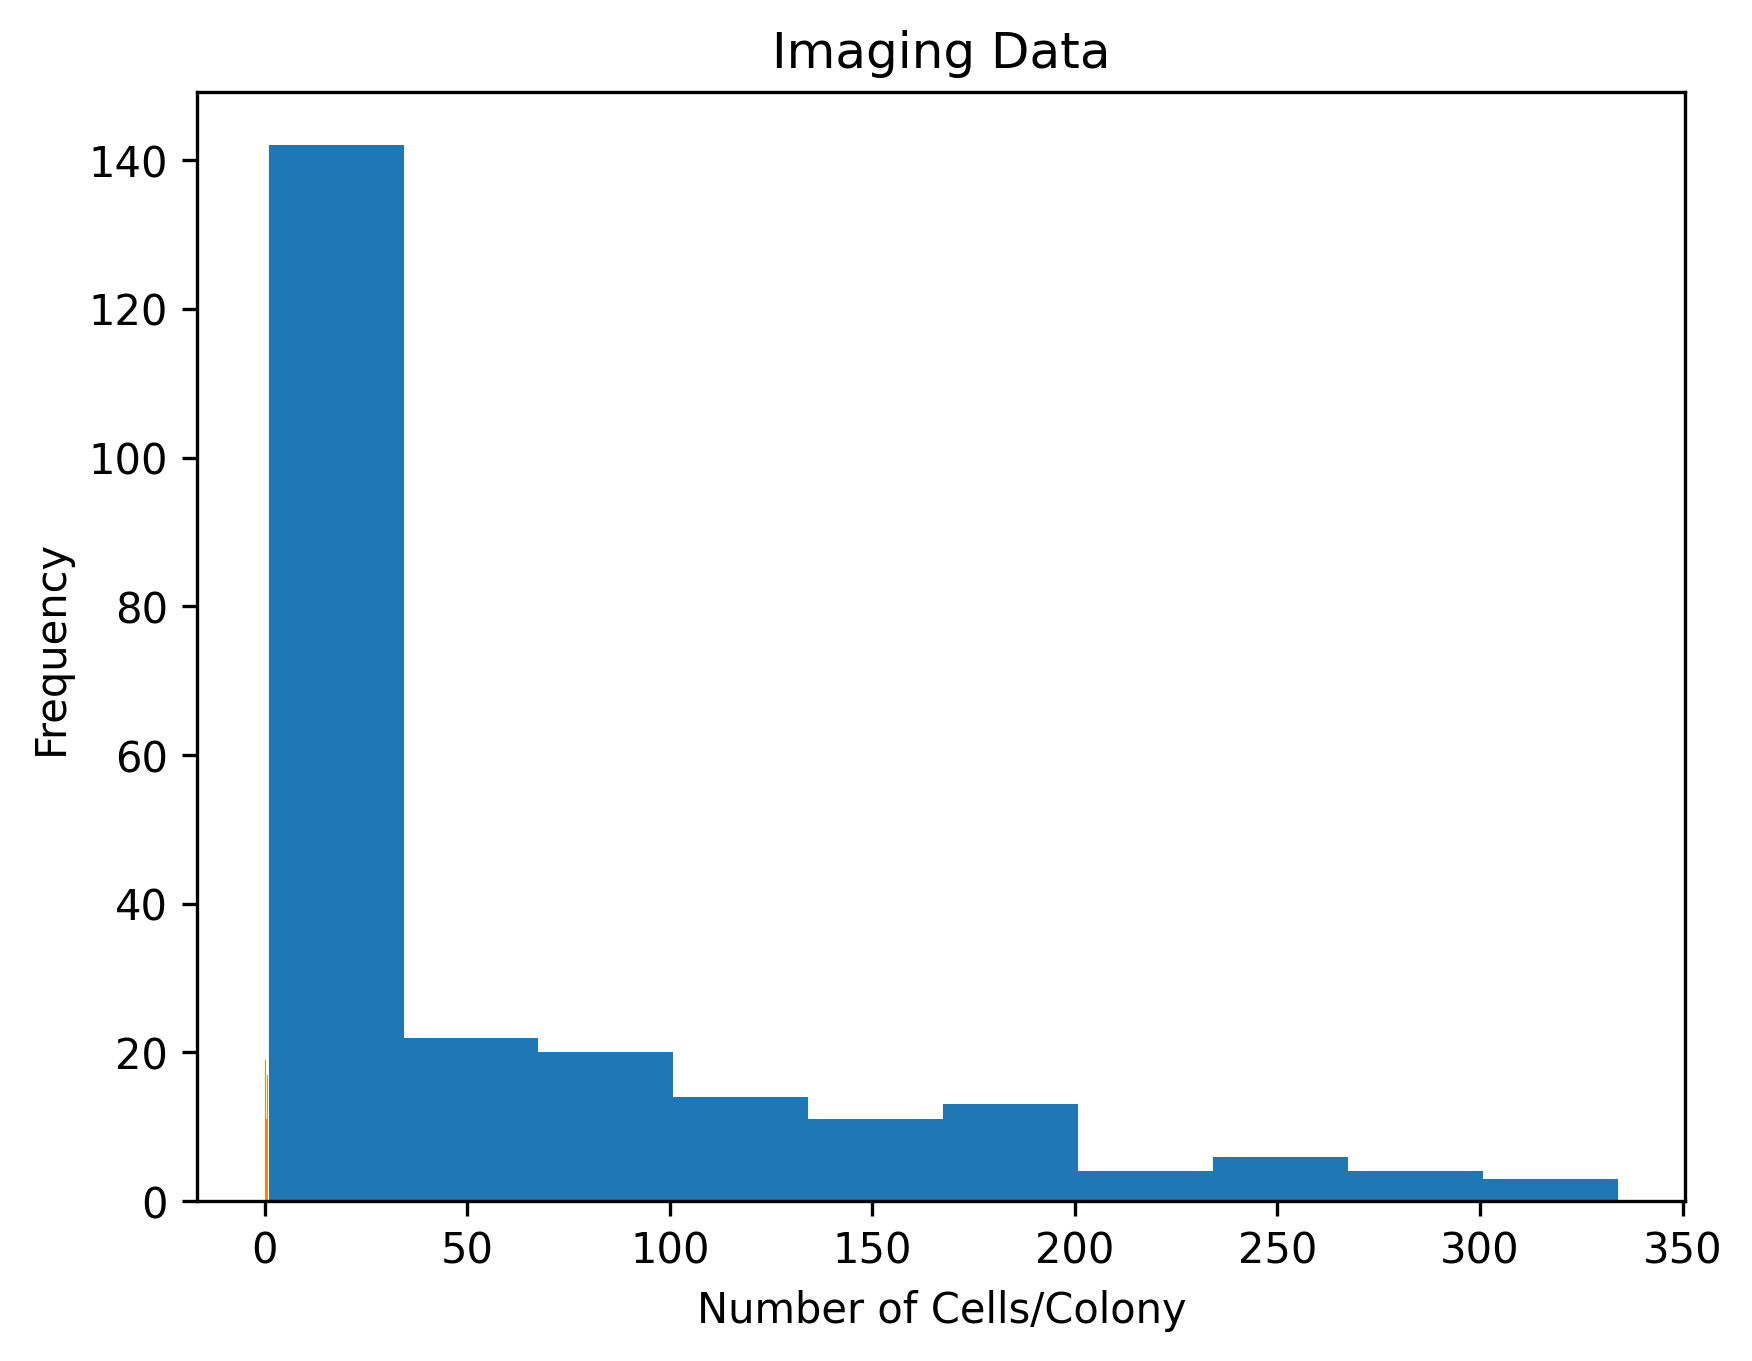

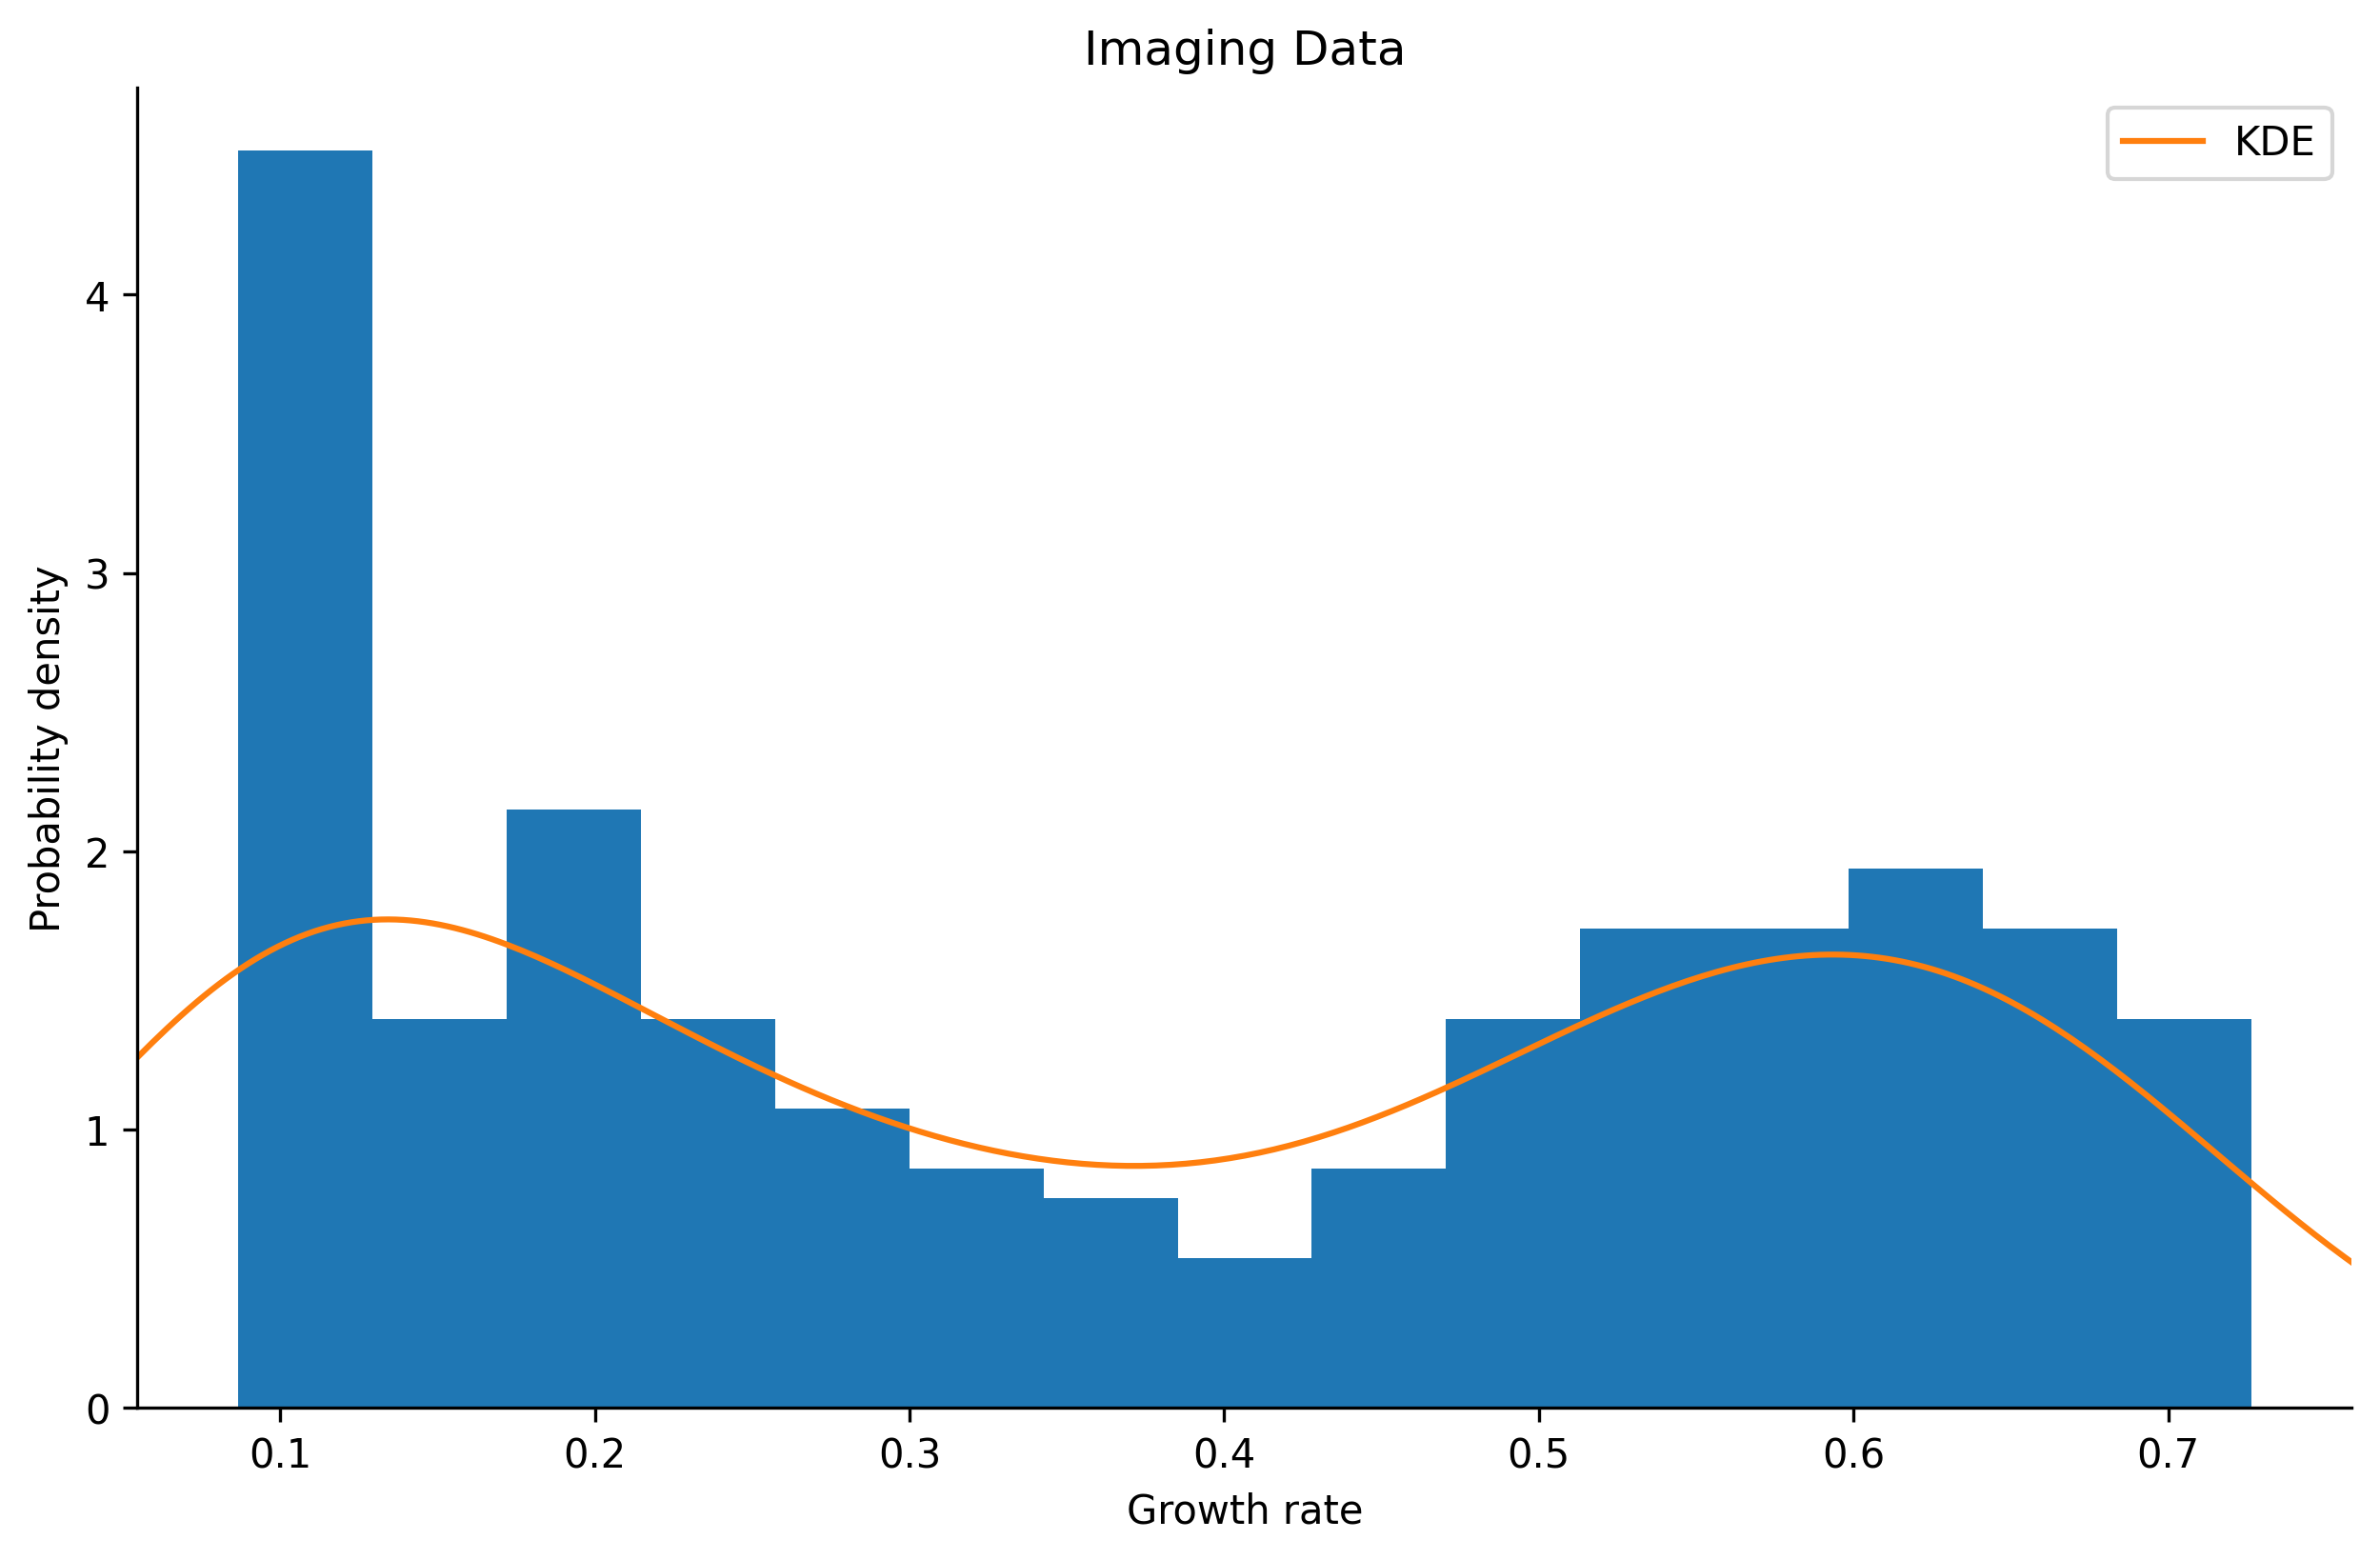

In [22]:
import pandas as pd
import glob


# all import statements
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import tifffile
import pandas as pd
import seaborn as sns
import time
import os
import glob
from skimage import measure
import skimage.measure as skmeas
from PyQt5 import QtCore, QtGui, QtWidgets
from nd2reader import ND2Reader
from tifffile import imwrite

#Path to files from Step1
main_path = "/Volumes/4TDATA_RAR/RAR/Shaffer_Scope/20220718_Cas12/Cellori_clean"
paths_to_all_pik = glob.glob(main_path+"/*.pkl")

#Name of sample names
want = ['cl','8_','9_','10']

colony_all_files = []
colony_hold = []
colony_name = []

for i in paths_to_all_pik:
    #print("         " + i )
    
    name_compare = i.split("/")[-1].split('plate')[-1][0:2]
    #print(name_compare)
    
    if len(set(want)&set([name_compare])) == 1:
            
        df_points = pd.read_pickle(i)


        #Get all colony sizes
        for k,m in enumerate(np.unique(df_points['colonyID'])):
            if m != -1:
                colony_hold.append(len(df_points.loc[df_points['colonyID'] == m]))
                colony_name.append(name_compare)
                
#     flat_list = [item for sublist in colony_hold for item in sublist]             
    colony_all_files.append(colony_hold)

    
    
    
d = {'values':colony_hold,'names':colony_name}
# Create the pandas DataFrame
df = pd.DataFrame(data=d)
 
# specifying column names
#df.columns = names_crispr
 
# print dataframe.
print(df, "\n")

df_control = df.loc[df['names'] == 'cl']
plt.hist(df_control['values'])
plt.title('Imaging Data')    
plt.ylabel('Frequency');
plt.xlabel('Number of Cells/Colony');


initial_population = 1
keep_growth_rates = []

for i in np.sort(df_control['values'][df_control['values']!= 1]):
    keep_growth_rates.append(np.log(i/initial_population)/8 )

counts, bins, bars = plt.hist(keep_growth_rates)



import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

import seaborn as sns
# sns.set(style='ticks')

# combine mixture
ys = keep_growth_rates

# create new figure with size given explicitly
plt.figure(figsize=(10, 6))

plt.hist(ys, density=True, bins = 15)

# get X limits and fix them
mn, mx = plt.xlim()
plt.xlim(mn, mx)

# estimate Kernel Density and plot
x = np.linspace(mn, mx, 301)
kde = sps.gaussian_kde(ys)
plt.plot(x, kde.pdf(x), label='KDE')

# finish up
plt.legend()
plt.ylabel('Probability density')
plt.title('Imaging Data')    
plt.xlabel('Growth rate');
sns.despine()

p = kde.pdf(x)
p /= p.sum()

lin_range = np.linspace(np.min(keep_growth_rates),np.max(keep_growth_rates),len(p))

#plt.savefig("/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/model_plots"+"/fit_pdf.pdf", bbox_inches='tight')

In [52]:

import sys
!{sys.executable} -m pip install statannot

### Define a functions for cell division, based on a distribution of growth rates

In [23]:
def pdf(x,mean,std):
    # probability distribution function
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out

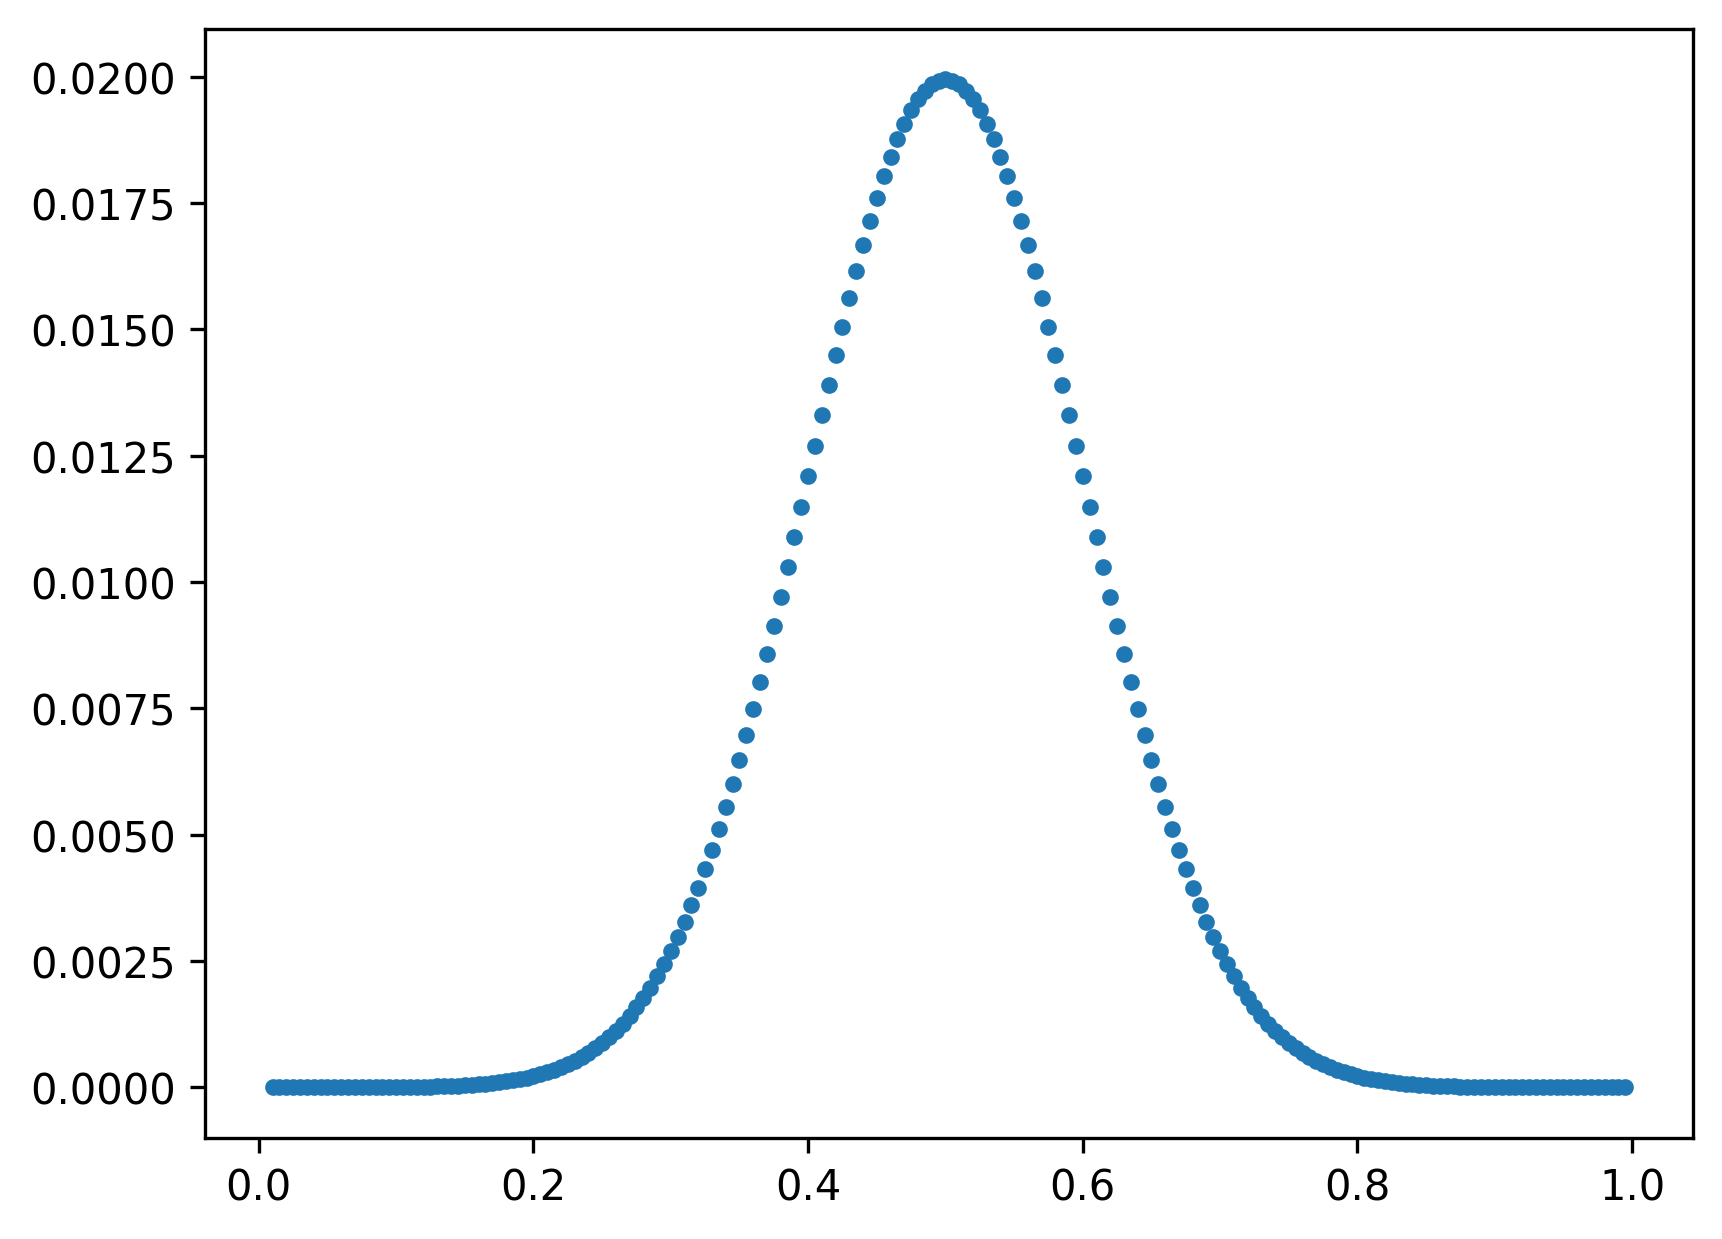

In [24]:
# To generate an array of x-values
min_range,max_range,step_value = [0.01, 1,.005]
x = np.arange(min_range, max_range,step_value )#(1, 2, .01)
  
# To generate an array of 
# y-values using corresponding x-values
mean = .5
std = .1
p_model=pdf(x,mean,std)
p_model /= p_model.sum()

lin_range_model = np.linspace(np.min(x),np.max(x),len(p_model))

plt.scatter(x, p_model, marker = '.')

In [25]:
def cell_growth_rate(p,lin_range):
    # the division rate of the cell is picked from the distribution aquired from the data
    division_rate = np.random.choice(lin_range, p=p)
    return division_rate

In [26]:
def cell_decision(num_divisions,p,lin_range):
    growth_rate = cell_growth_rate(p,lin_range)
    return np.e**(num_divisions*growth_rate)

In [27]:
def cell_devision(barcodes,divisions,p,lin_range):

    barcodes_divisions = []
    for b in barcodes:
        w = cell_decision(divisions,p,lin_range)
        barcodes_divisions.append([b]*int(w))
        
    return np.concatenate(barcodes_divisions)

In [28]:
def count_barcodes(list_of_barcodes):
    list_of_barcodes = list(list_of_barcodes)
    barcodes = list(set(list_of_barcodes))
    number_of_barcodes = [list_of_barcodes.count(i) for i in barcodes]
    
    index_sort = np.argsort(barcodes)
    barcodes = [barcodes[i] for i in index_sort]
    number_of_barcodes = [number_of_barcodes[i] for i in index_sort]   
    
    return [barcodes,number_of_barcodes]


In [29]:
# Initialize variables
initial_cell_number = 1000

divisions = 3
N_split = 2
divisions_after_split = 5

barcodes = range(initial_cell_number)

barcodes_divisions = cell_devision(barcodes,divisions,p,lin_range)


#### Lets split the cells N_split ways

# mix barcodes
random.shuffle(barcodes_divisions)

#split list N_split ways
spacer = int(np.ceil(len(barcodes_divisions)/N_split))
split_barcodes = [barcodes_divisions[i:i + spacer] for i in range(0, len(barcodes_divisions), spacer)]


#### Grow out splits 
barcode_split_mid = []
for i in range(len(split_barcodes)):
    barcode_split_mid.append(cell_devision(split_barcodes[i],divisions_after_split,p,lin_range))


#### Print some important info

xb = initial_cell_number/100

[x0,y0] = count_barcodes(split_barcodes[0])
[x1,y1] = count_barcodes(split_barcodes[1])
barcodes_shared = set(x0) & set(x1)
percent = [len(set(x0))/xb,  len(set(x1))/xb]

[x0_mid,y0_mid] = count_barcodes(barcode_split_mid[0])
[x1_mid,y1_mid] = count_barcodes(barcode_split_mid[1])
barcodes_shared_mid = set(x0_mid) & set(x1_mid)
percent_mid = [len(set(x0_mid))/xb,  len(set(x1_mid))/xb]


print("Percent of barcodes shared = " , len(barcodes_shared)/xb) 
print(" ")
print("Barcodes in each 1st split ", "(divided ",str(divisions), "times):")
for i in range(len(split_barcodes)):
    print("           Cells in split" + str(i) + " = " + str(len(split_barcodes[i]) ) +
          "         percentage of original barcode  =  ",percent[i] )


print(" ")
print("Barcodes after ", str(divisions_after_split)," divisions, 1st split:")
for i in range(len(barcode_split_mid)):
    print("           Cells in split" + str(i) + " = " + str(len(barcode_split_mid[i]) ))


    

Percent of barcodes shared =  57.3
 
Barcodes in each 1st split  (divided  3 times):
           Cells in split0 = 1629         percentage of original barcode  =   79.2
           Cells in split1 = 1628         percentage of original barcode  =   78.1
 
Barcodes after  5  divisions, 1st split:
           Cells in split0 = 15766
           Cells in split1 = 16841


## Plot

In [30]:
def simulate_correlation(initial_cell_number,divisions, runs,p,lin_range):
    barcodes = range(initial_cell_number)
    barcodes_divisions = cell_devision(barcodes,divisions,p,lin_range)
    [_,y0] = count_barcodes(barcodes_divisions)
    [_,y1] = count_barcodes(barcodes_divisions)
    
    keep_pearson = []
    keep_P = []
    
    for i in range(0,runs):
        random.shuffle(y1)
        keep_pearson.append(stats.pearsonr(y0, y1)[0])
        keep_P.append(stats.pearsonr(y0, y1)[1])
        
    
    return [keep_pearson,keep_P]

In [31]:
def random_cell(initial_cell_number,divisions,N_split,runs,p,lin_range):
    
    keep_track = []
    keep_P = []
    
    for i in range(0,runs):
        barcodes = range(initial_cell_number)

        barcodes_divisions = cell_devision(barcodes,divisions,p,lin_range)


        #### Lets split the cells N_split ways

        # mix barcodes
        random.shuffle(barcodes_divisions)

        #split list N_split ways
        spacer = int(np.ceil(len(barcodes_divisions)/N_split))
        split_barcodes = [barcodes_divisions[i:i + spacer] for i in range(0, len(barcodes_divisions), spacer)]
        
        
        
        #### Grow out splits 
        barcode_split_mid = []
        for i in range(len(split_barcodes)):
            barcode_split_mid.append(cell_devision(split_barcodes[i],divisions_after_split,p,lin_range))
        
        #plot N_split
        [x0,y0] = count_barcodes(barcode_split_mid[0])
        for j in range(1,N_split):
            [xj,yj] = count_barcodes(barcode_split_mid[j])
            
            
            same_barcodes = list(set(x0) & set(xj))
            x0_same = [y0[x0.index(i)] for i in same_barcodes]
            xj_same = [yj[xj.index(i)] for i in same_barcodes]
 
            
            keep_track.append(stats.pearsonr(x0_same, xj_same)[0])
            keep_P.append(stats.pearsonr(x0_same, xj_same)[1])
            
    return [keep_track,keep_P]

In [32]:
def plot_correlation(barcode_and_count):
    
    same_barcodes = list(set(barcode_and_count[0]) & set(barcode_and_count[2]))
    x0 = [barcode_and_count[1][barcode_and_count[0].index(i)] for i in same_barcodes]
    x1 = [barcode_and_count[3][barcode_and_count[2].index(i)] for i in same_barcodes]
    plt.plot(x0,x1,'.') 
    print(stats.spearmanr(x0, x1))
    
    print(stats.ttest_ind(x0,x1, equal_var=False) )
    
    # Python paired sample t-test
    #print(ttest_rel(x0,x1) )
    
    x = [x1,x0]
    
    plt.plot([0,max(max(x))],[0,max(max(x))])
    
    m, b = np.polyfit(x0,x1, 1)
    print(m,b)
    
    plt.plot(x0, m*np.array(x0) + b)
    
    plt.title('Correlation')    
    plt.ylabel('Split M');
    plt.xlabel('Split N');

# Model corelations

SignificanceResult(statistic=0.010653871521128172, pvalue=0.7364989974516176)
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.013280712684865664 32.340711361040825


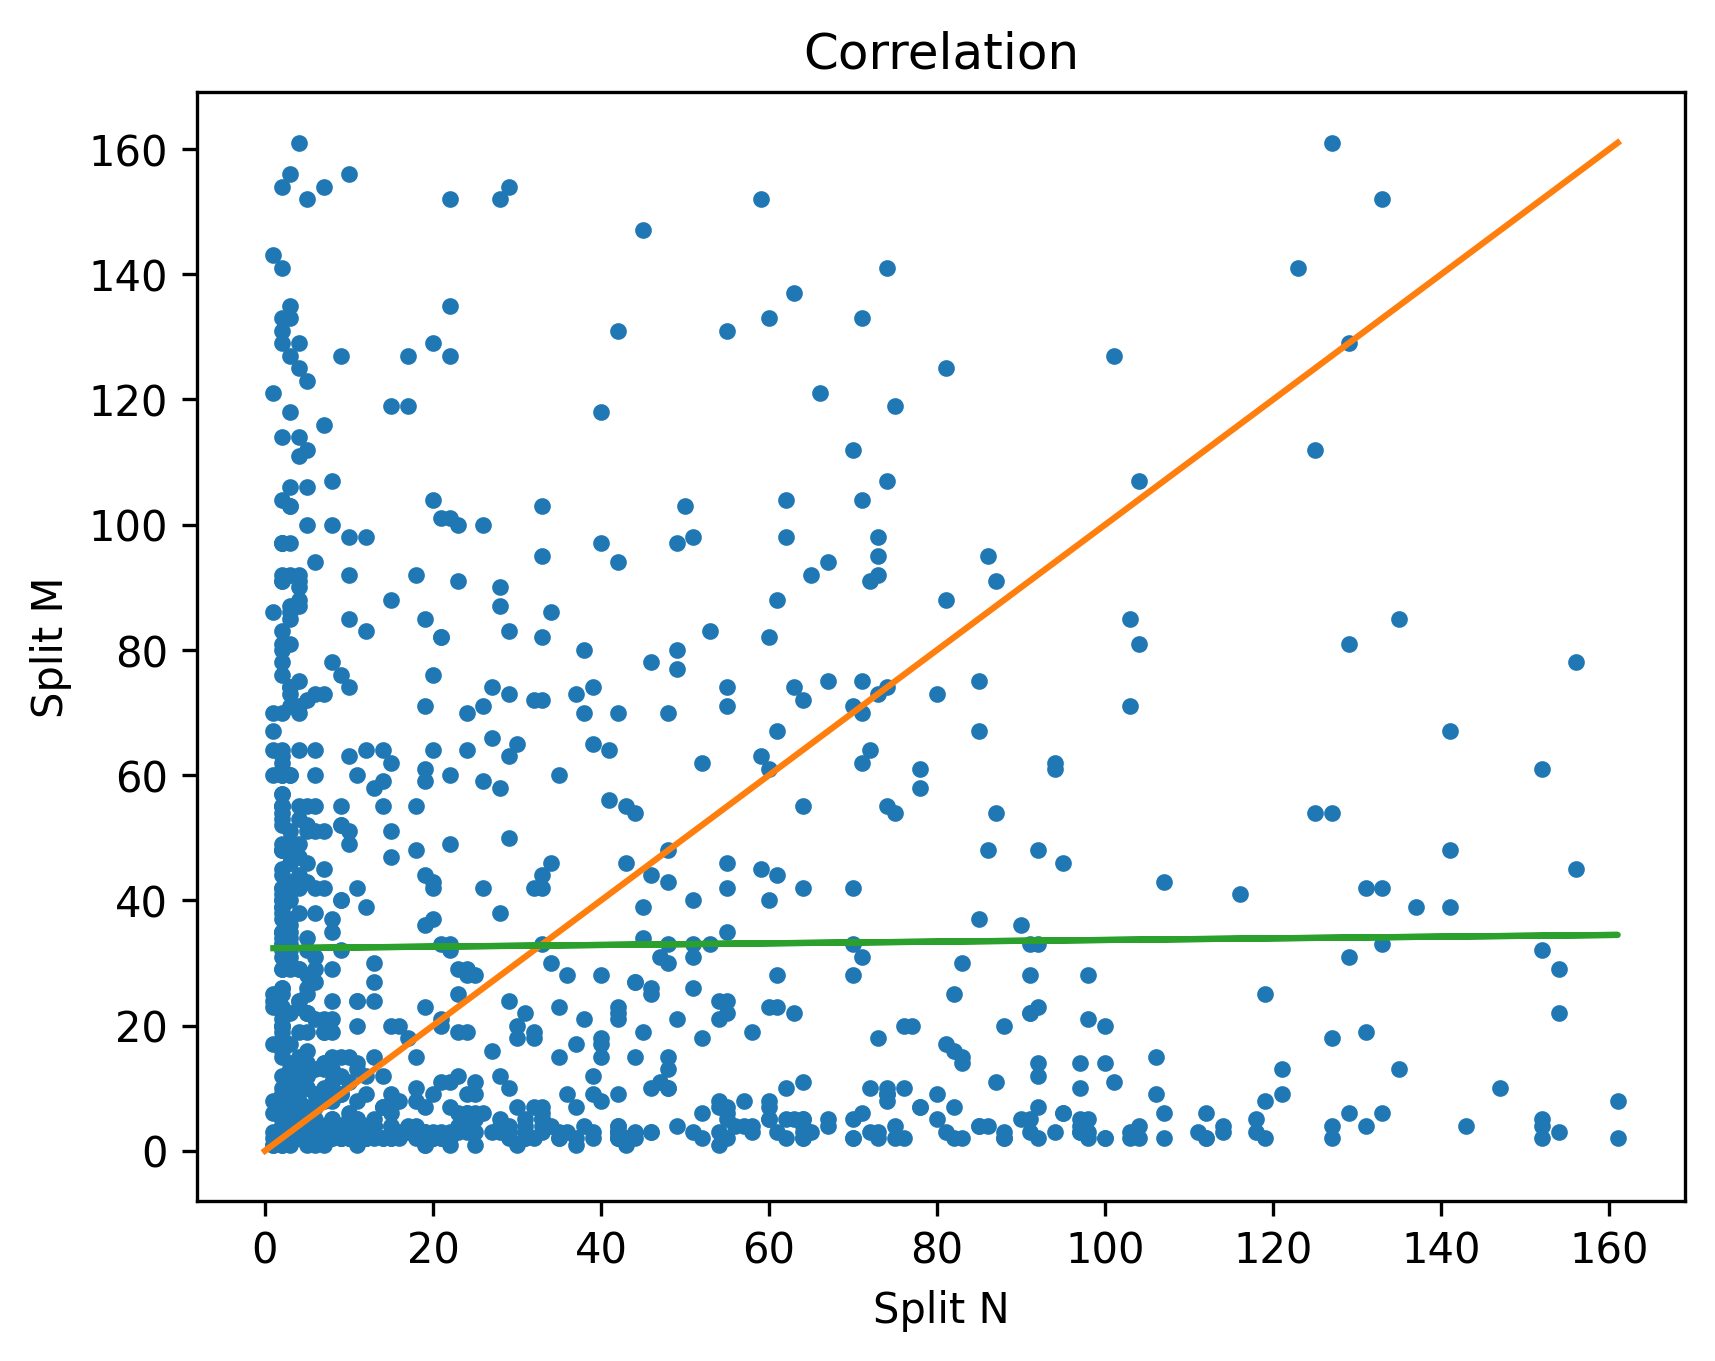

In [33]:

# barcodes = range(initial_cell_number)
# barcodes_divisions = cell_devision(barcodes,7,p_model,lin_range_model)
# [x0,y0] = count_barcodes(barcodes_divisions)
# [x1,y1] = count_barcodes(barcodes_divisions)

# keep_pearson = []
# keep_P = []
# random.shuffle(y1)

# plot_correlation([x0,y0,x1,y1])
# plt.savefig("/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/model_plots"+"/correlation_completly_random_model.pdf", bbox_inches='tight')



barcodes = range(initial_cell_number)
barcodes_divisions = cell_devision(barcodes,7,p,lin_range)
[x0,y0] = count_barcodes(barcodes_divisions)
[x1,y1] = count_barcodes(barcodes_divisions)

keep_pearson = []
keep_P = []
random.shuffle(y1)

plot_correlation([x0,y0,x1,y1])
#plt.savefig("/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/model_plots"+"/correlation_completly_random.pdf", bbox_inches='tight')








In [34]:
stats.pearsonr([1,2,3,4,5,6], [11,22,33,4,5,6])[1]

0.3328129530390275

In [35]:
# Initialize variables
runs = 200

x_random_cell,x_random_cell_P = random_cell(initial_cell_number,divisions,N_split,runs,p,lin_range)
x_random_cell_model, x_random_cell_model_P = random_cell(initial_cell_number,divisions,N_split,runs,p_model,lin_range_model)
complete_random_x,complete_random_x_P = simulate_correlation(initial_cell_number,divisions, runs,p,lin_range)


-0.012135677116158443 0.09627774742097939 -0.0009716808708919996
0.518416193007204 0.04685896356601054 0.48191765550937044


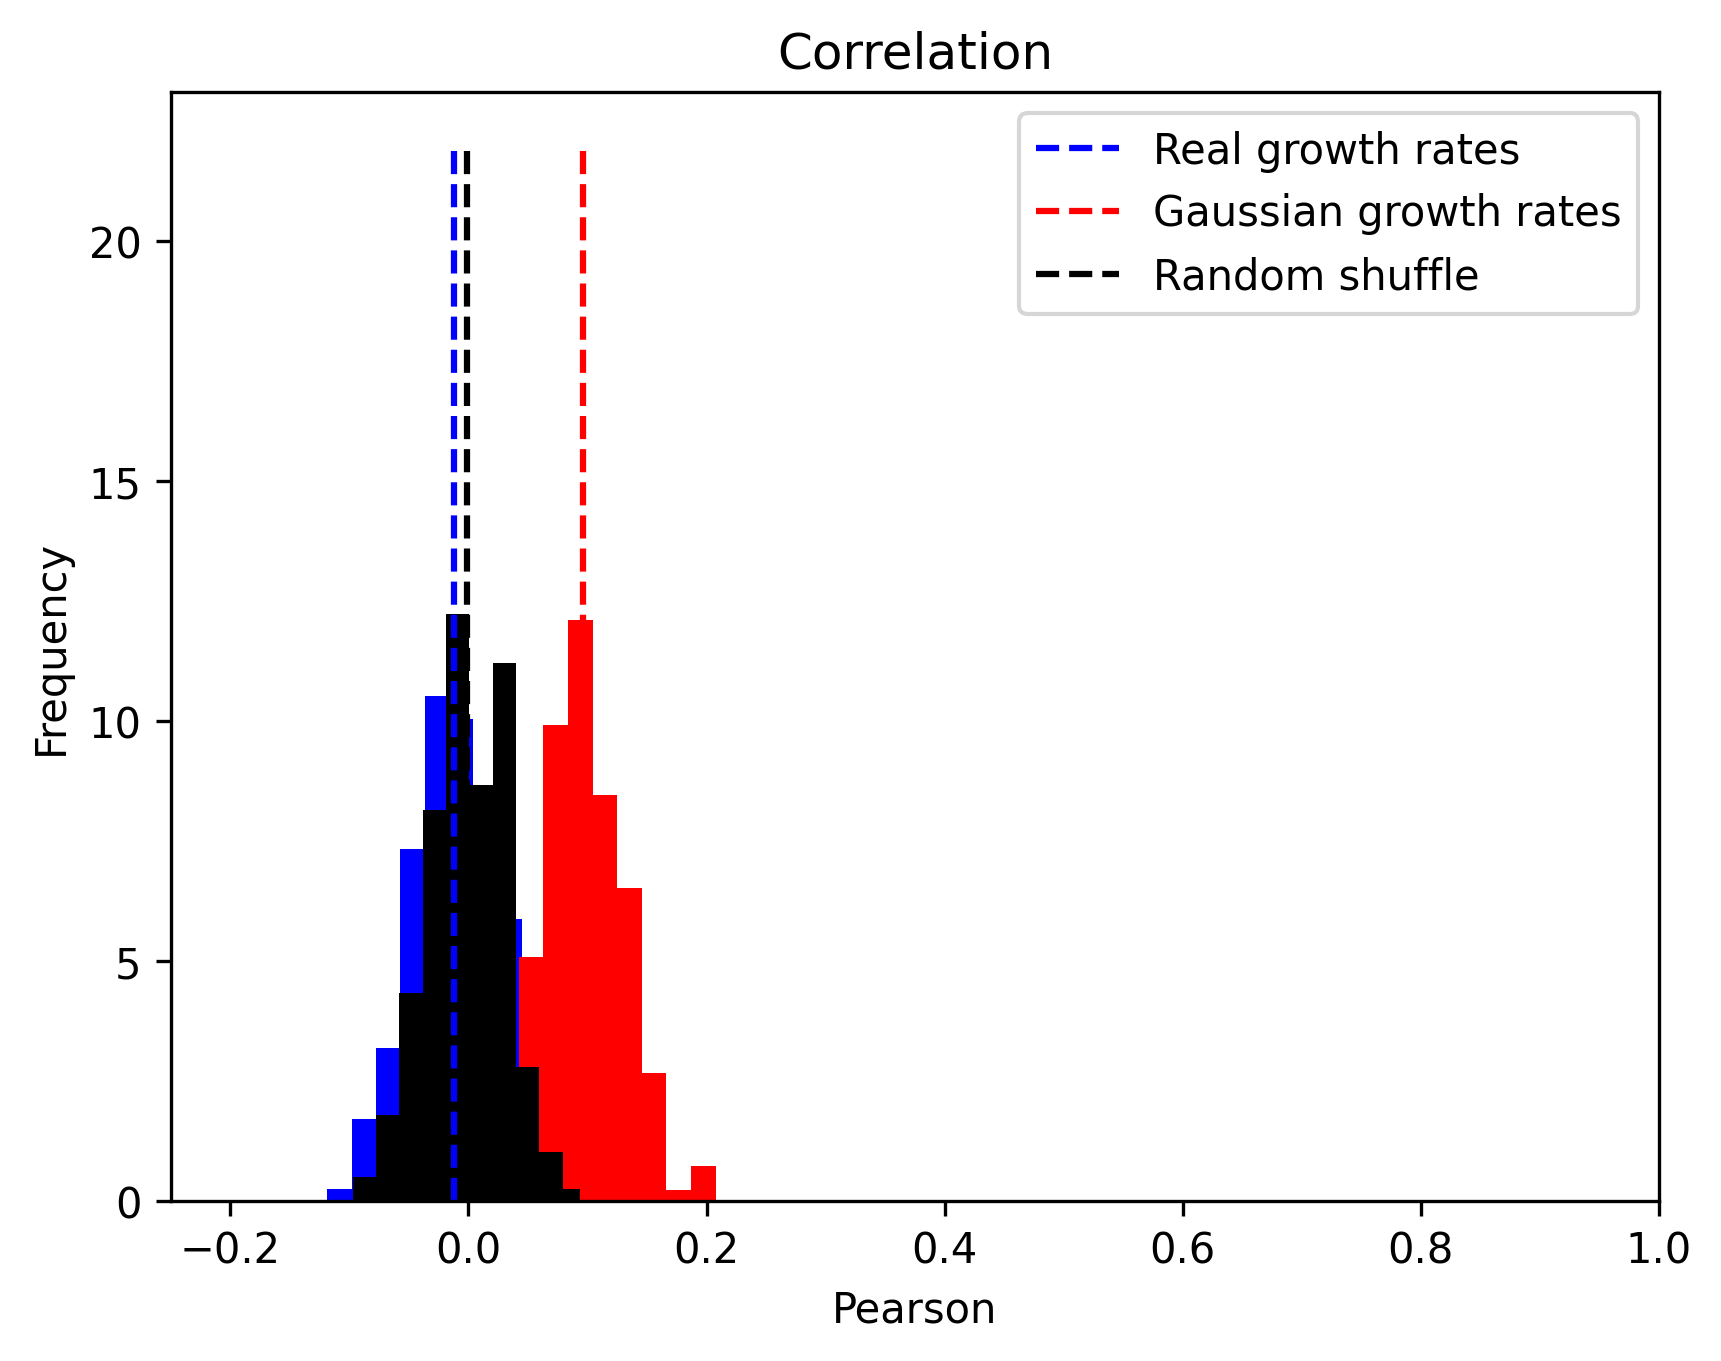

In [36]:

mean_rc = np.mean(x_random_cell)
mean_rc_model = np.abs(np.mean(x_random_cell_model))
mean_cr = np.mean(complete_random_x)
print(mean_rc ,mean_rc_model, mean_cr)

mean_rc_P = np.mean(x_random_cell_P)
mean_rc_model_P = np.mean(x_random_cell_model_P)
mean_cr_P = np.mean(complete_random_x_P)
print(mean_rc_P ,mean_rc_model_P, mean_cr_P)

plt.hist(x_random_cell, density=True,color = 'b')
plt.hist(np.abs(x_random_cell_model), density=True,color = 'r')
plt.hist(complete_random_x, density=True,color = 'k')


plt.plot([mean_rc,mean_rc],[0,22],'--b')
plt.plot([mean_rc_model,mean_rc_model],[0,22],'--r')
plt.plot([mean_cr,mean_cr],[0,22],'--k')


plt.xlim(-.25,1)
plt.title('Correlation')    
plt.ylabel('Frequency');
plt.xlabel('Pearson');
plt.legend(["Real growth rates","Gaussian growth rates","Random shuffle"])

## Data 

### Code from barcode analysis pipeline 

In [37]:


# Reads per million
def rpm_norm(reads):
    scaling_factor = np.nansum(reads)/1000000
    return [i/scaling_factor for i in reads]

def rpm_to_cells(m,b,rpm):
    return [k*m +b for k in rpm]

def get_r2_numpy(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return slope, intercept, r_squared

     group1 :
 
         Removing zeros and ones
 
             Plot:
                   Spike - RAR2
                   Spike - RAR2_1
                   Spike - RAR2_1
             
                   Bar - RAR2
                   Bar - RAR2_1
                   Bar - RAR2_1
     group2 :
 
         Removing zeros and ones
 
             Plot:
                   Spike - RAR3
                   Spike - RAR3_1
                   Spike - RAR3_1
             
                   Bar - RAR3
                   Bar - RAR3_1
                   Bar - RAR3_1


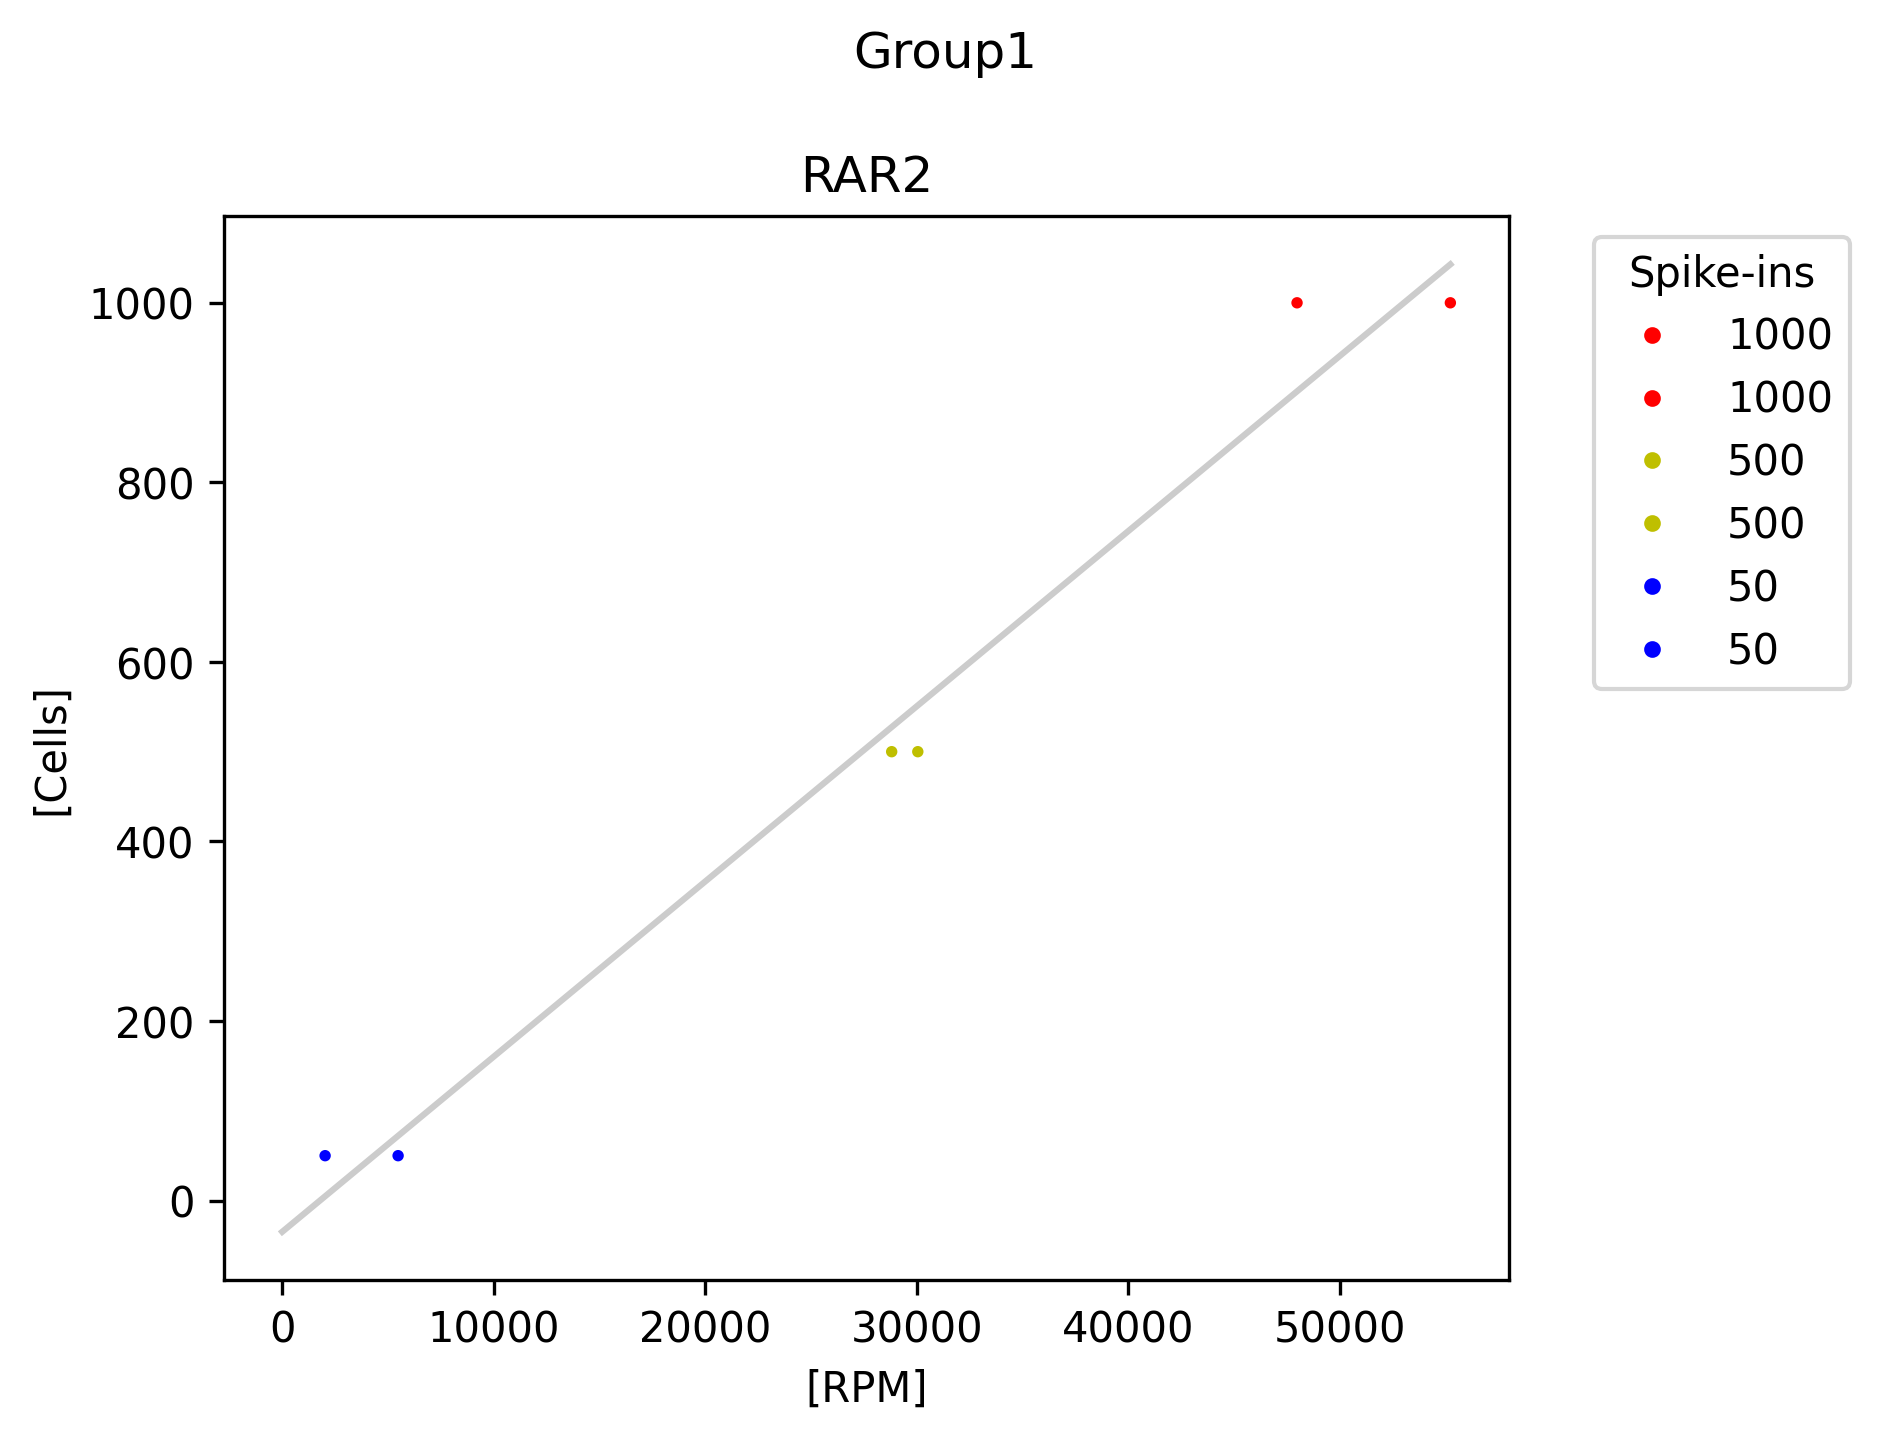

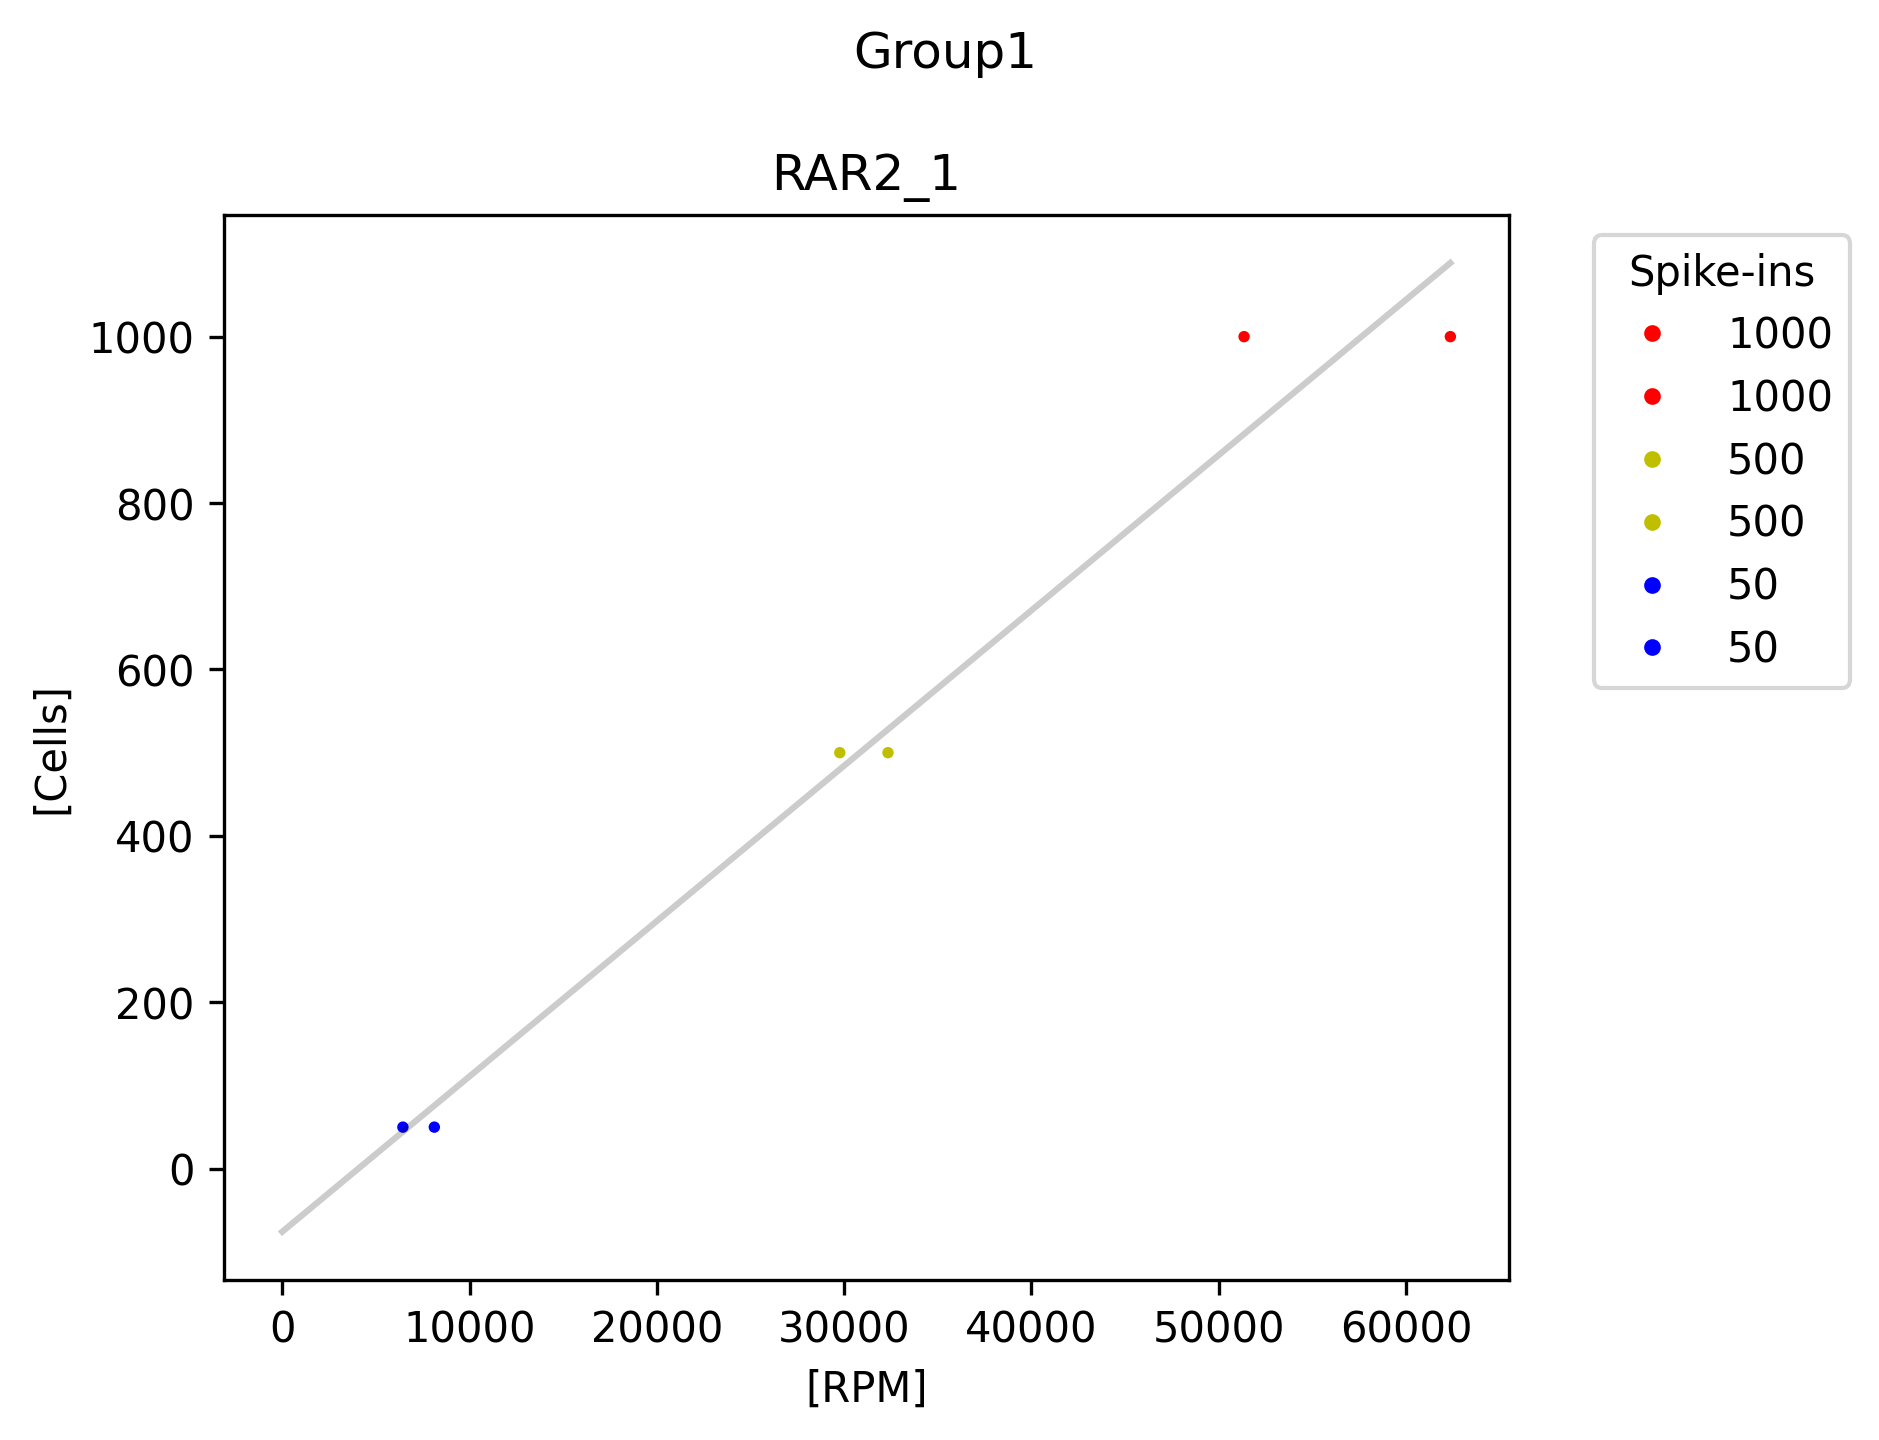

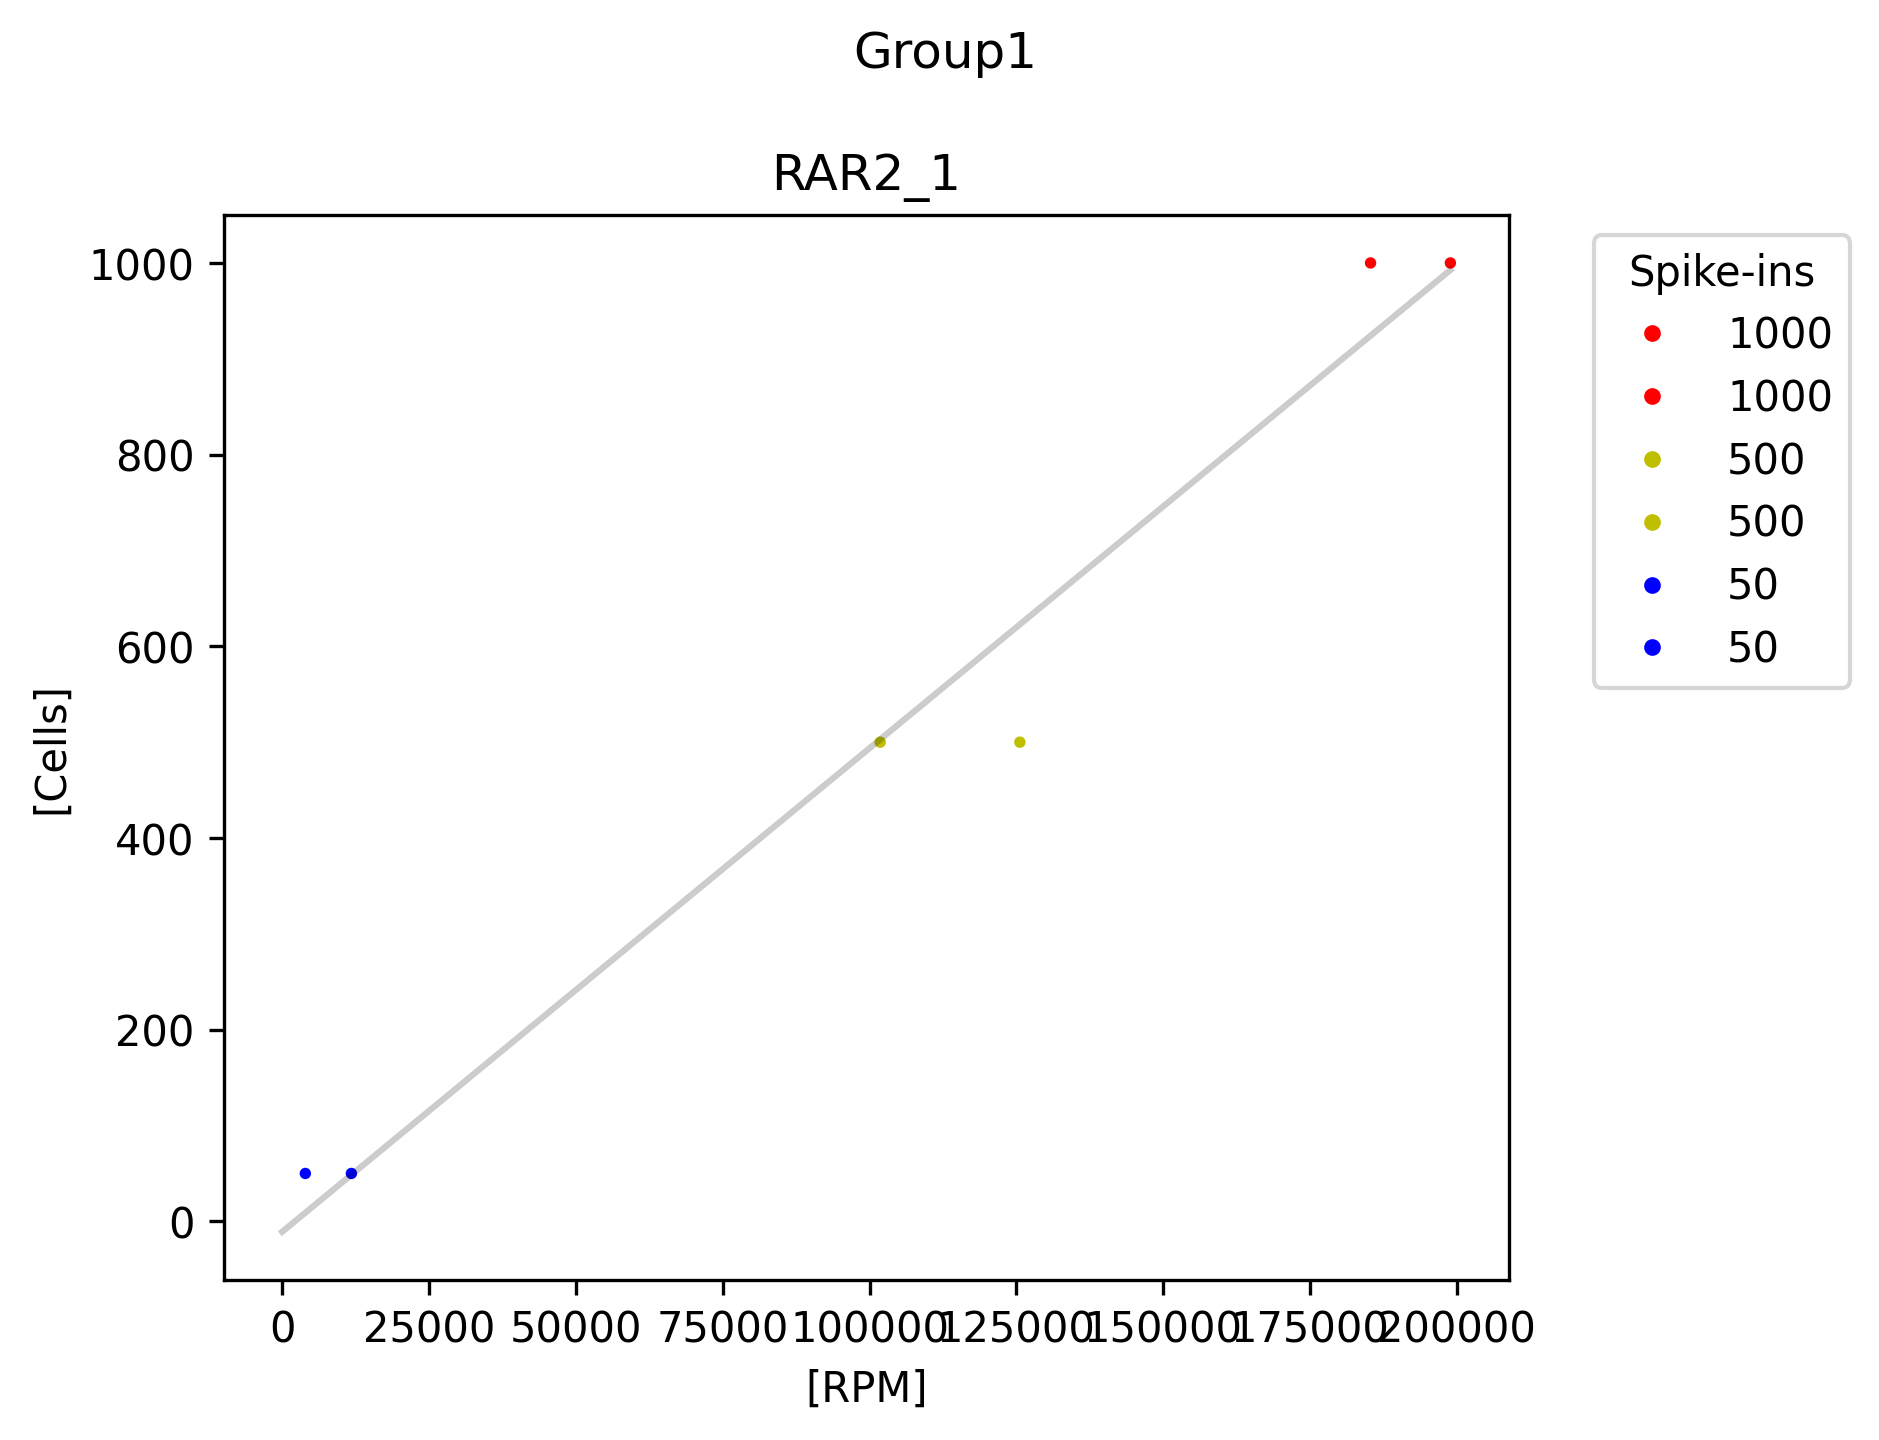

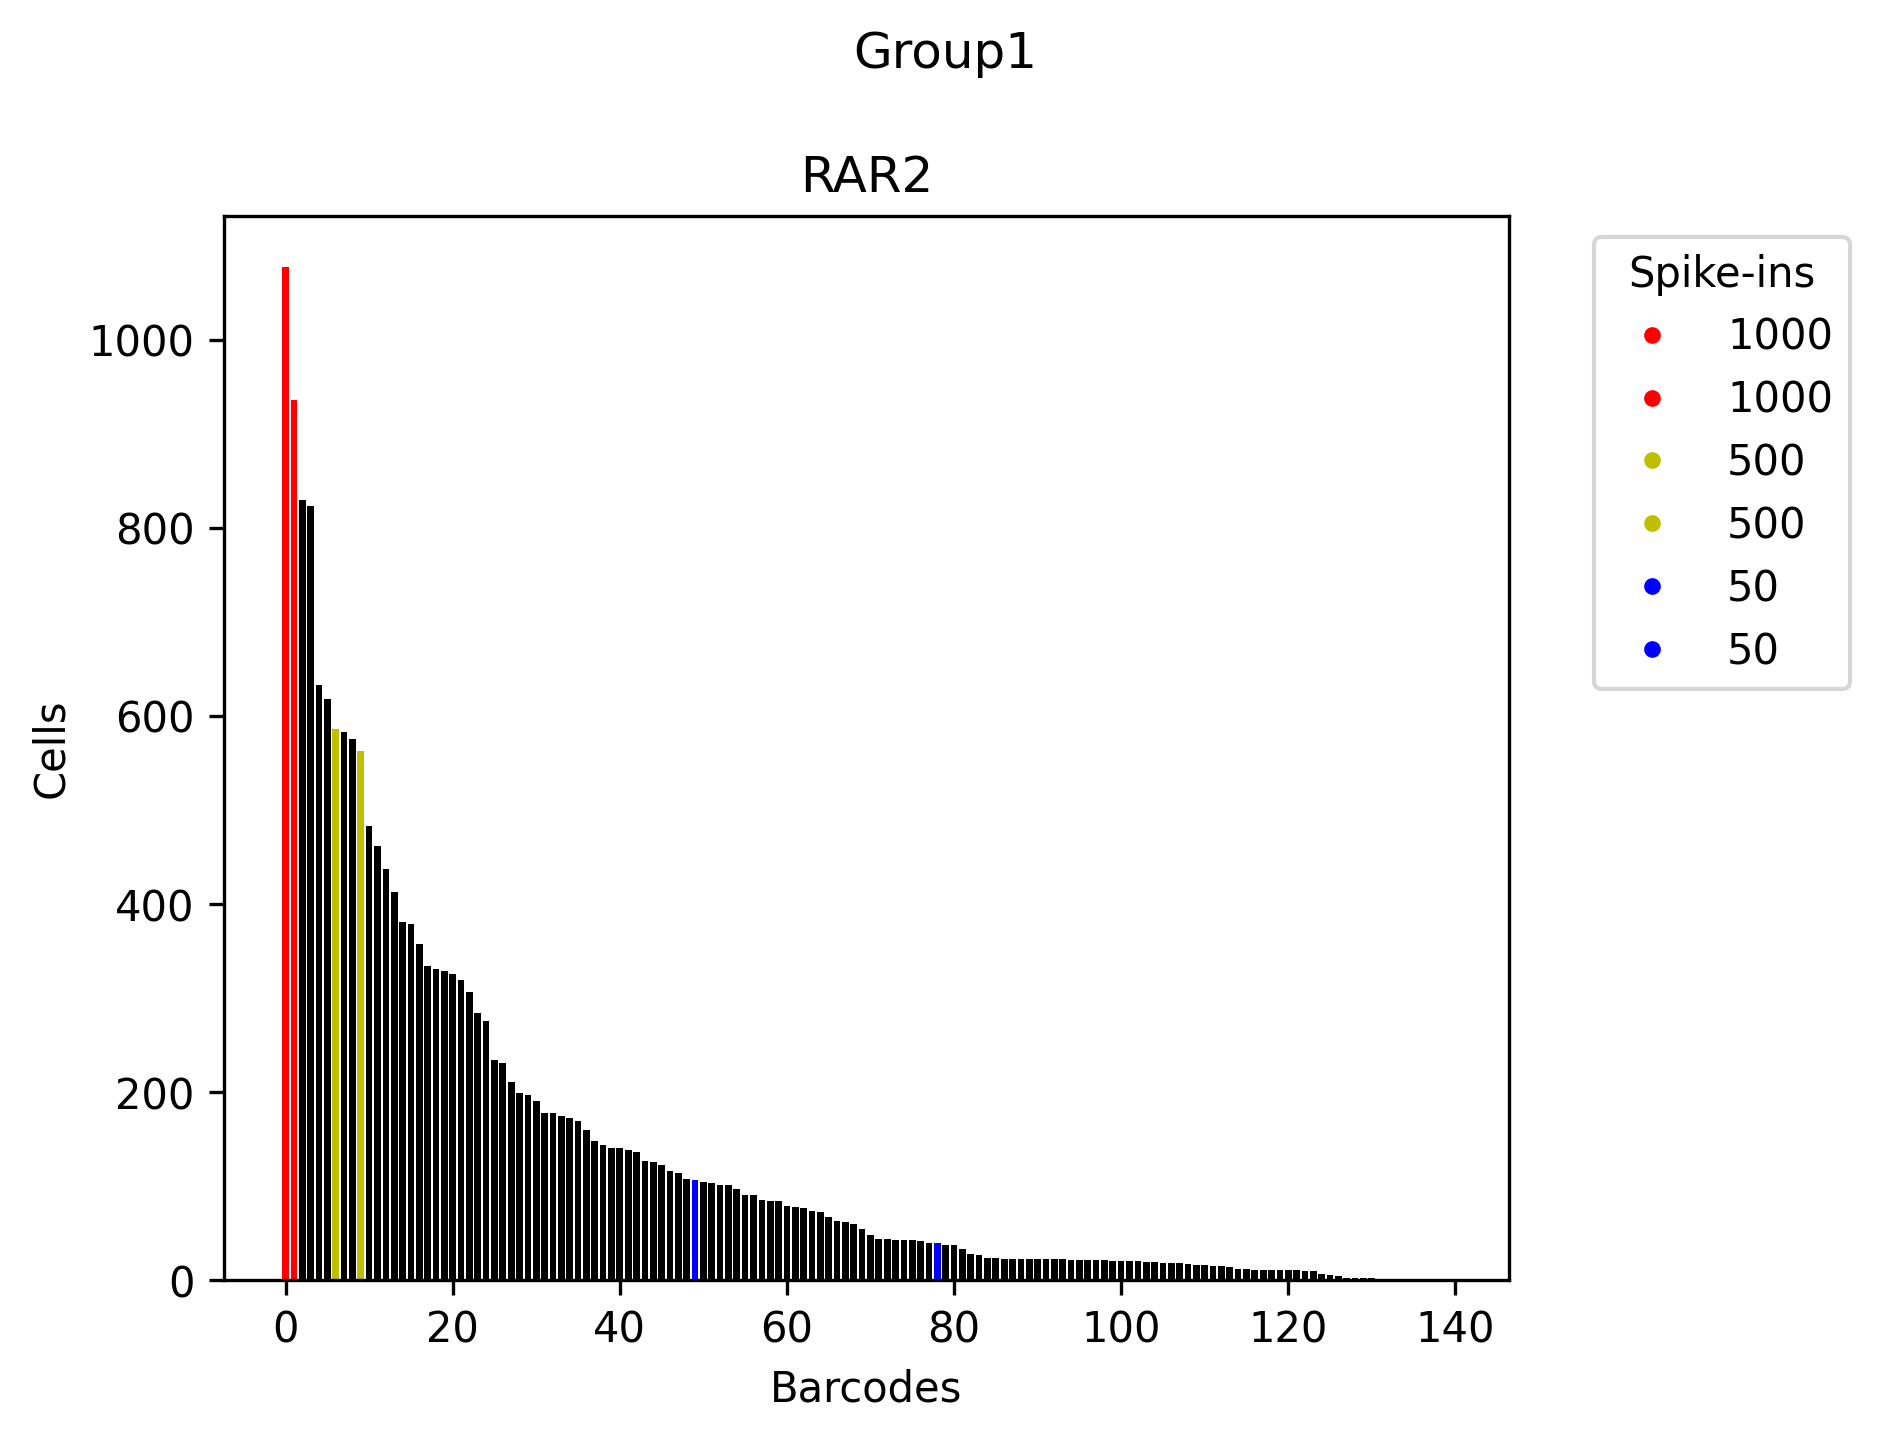

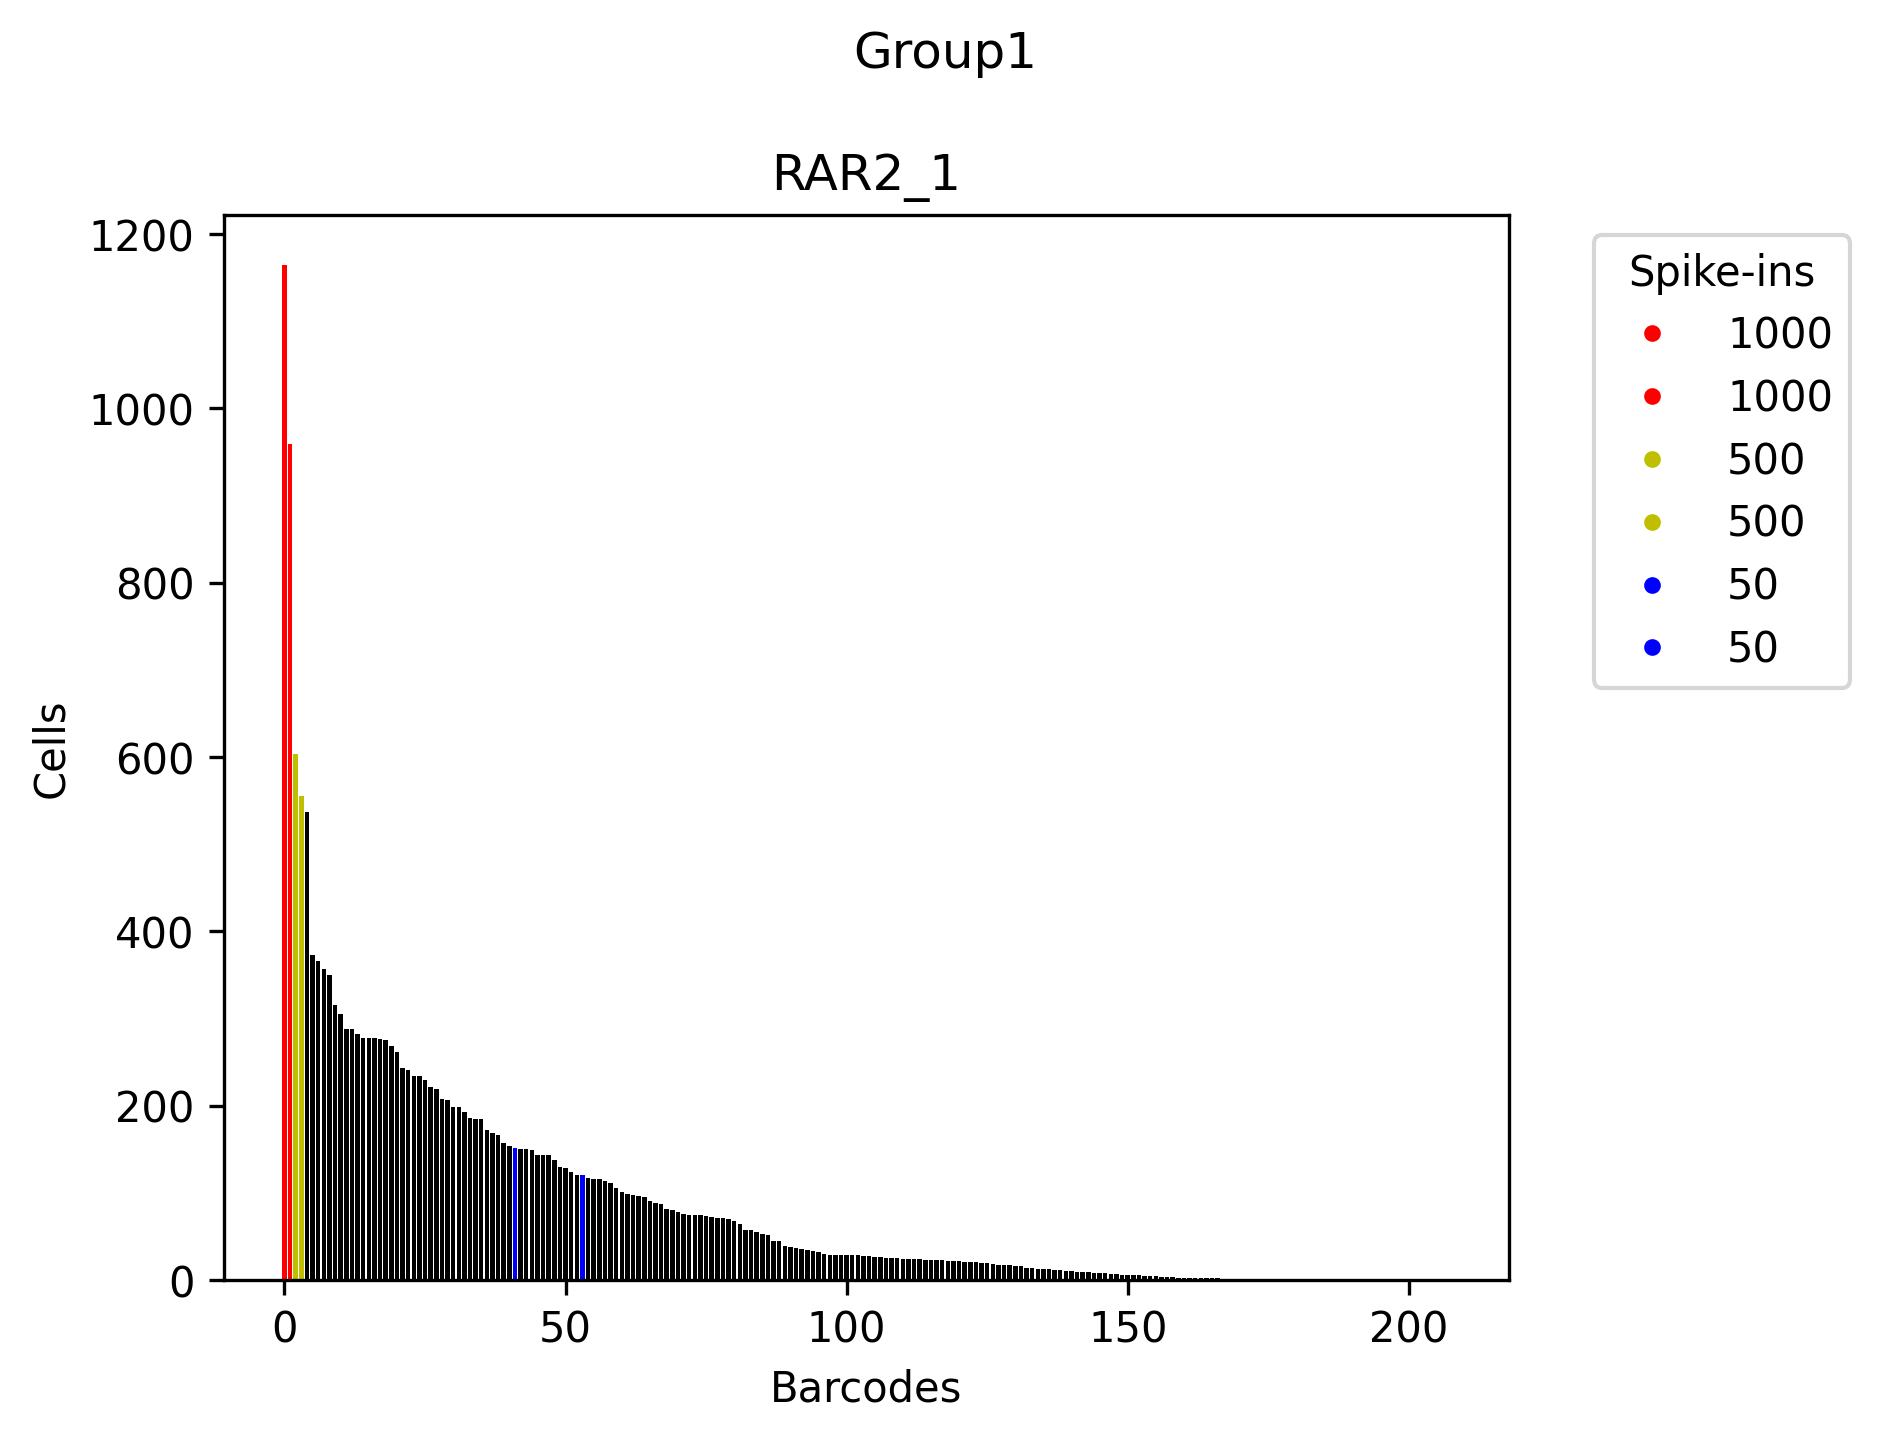

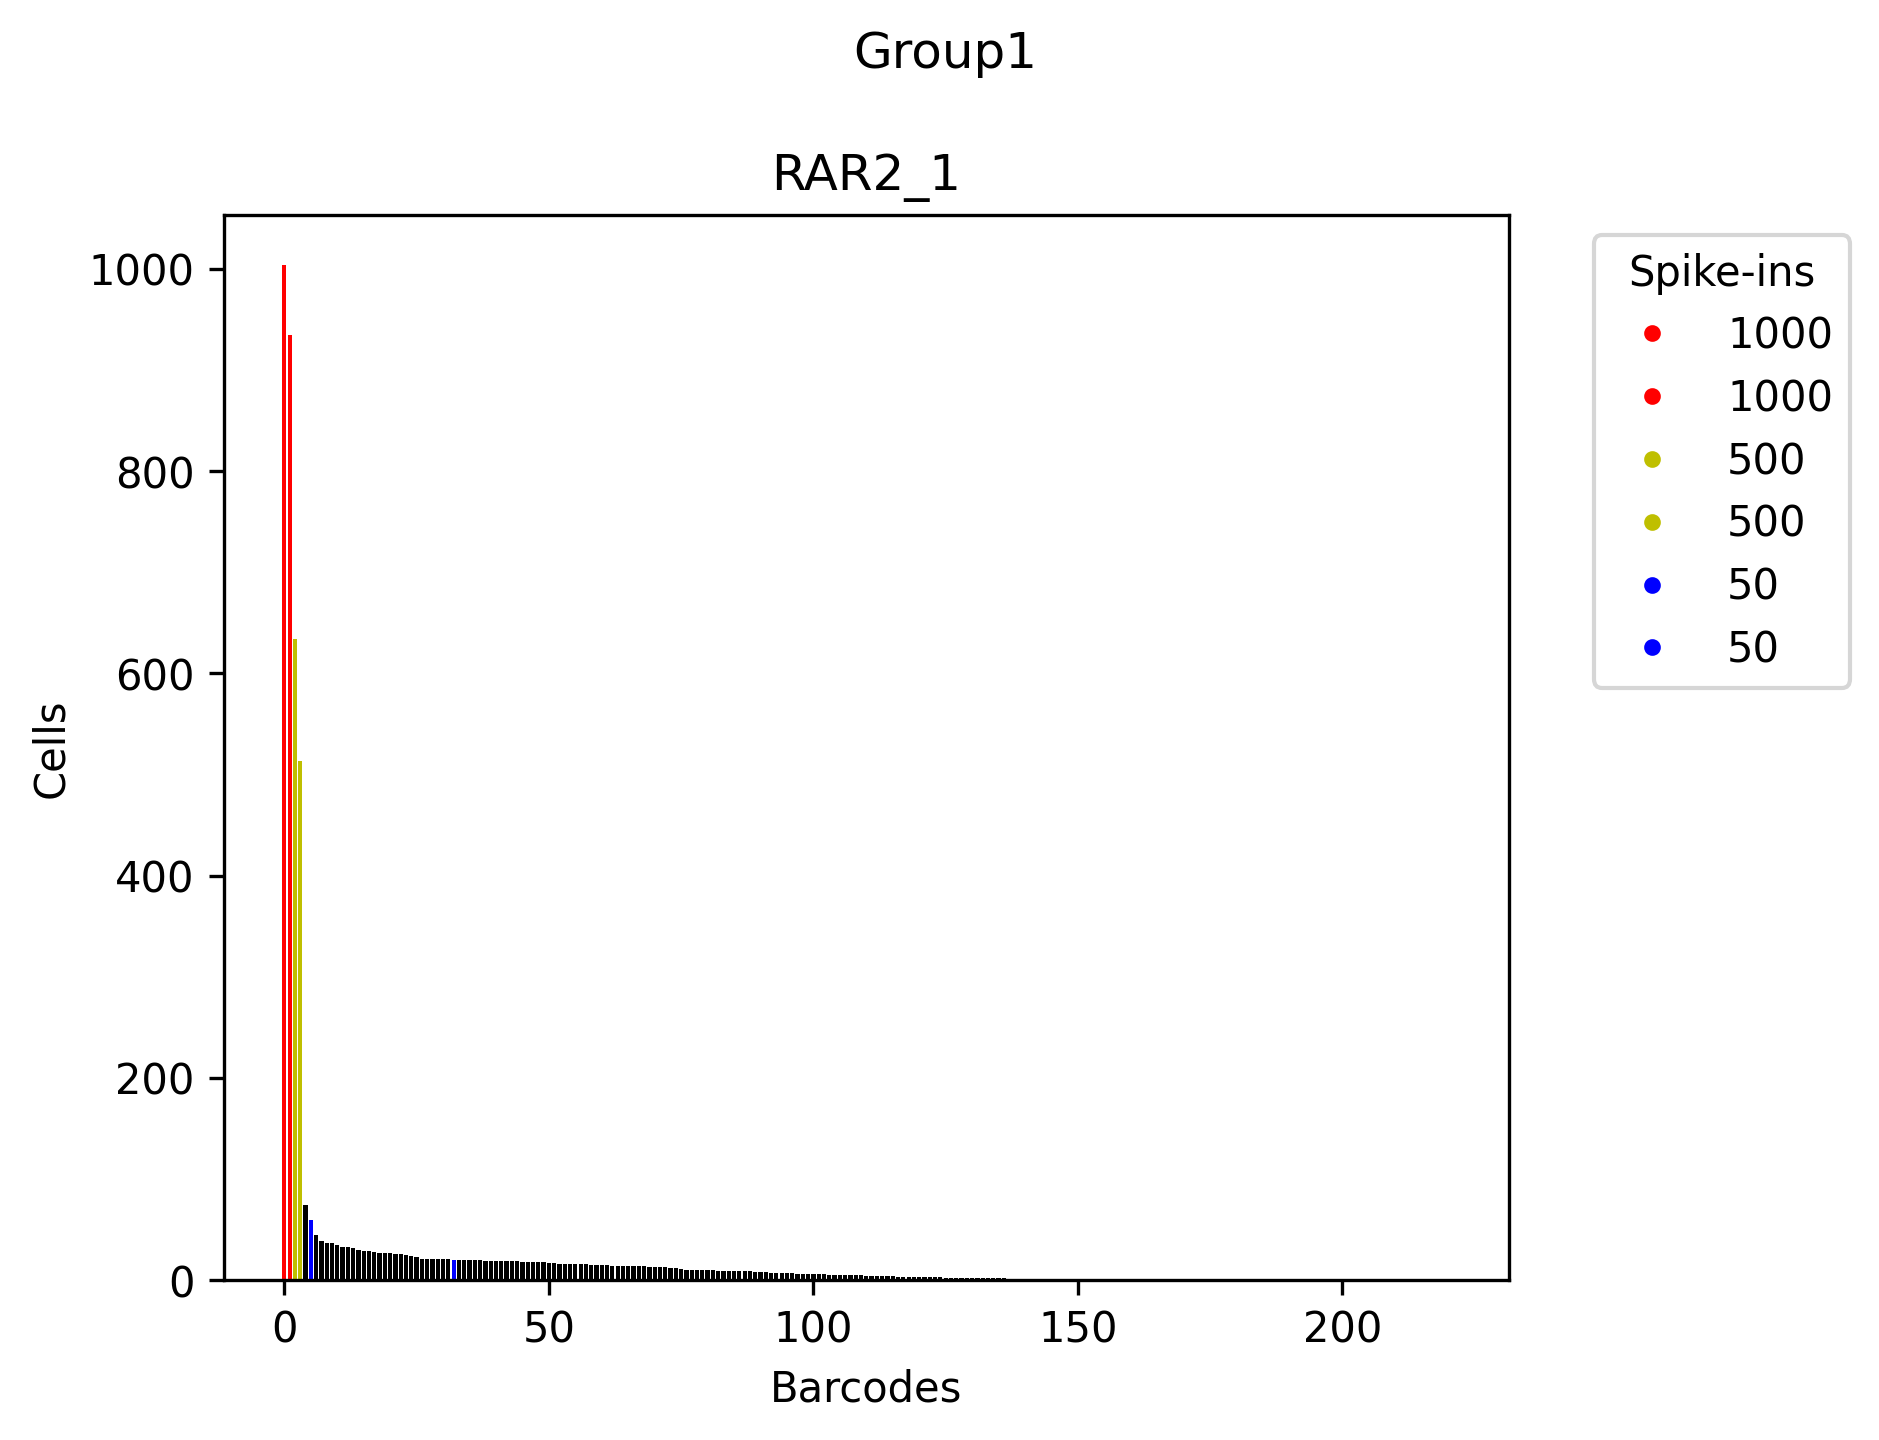

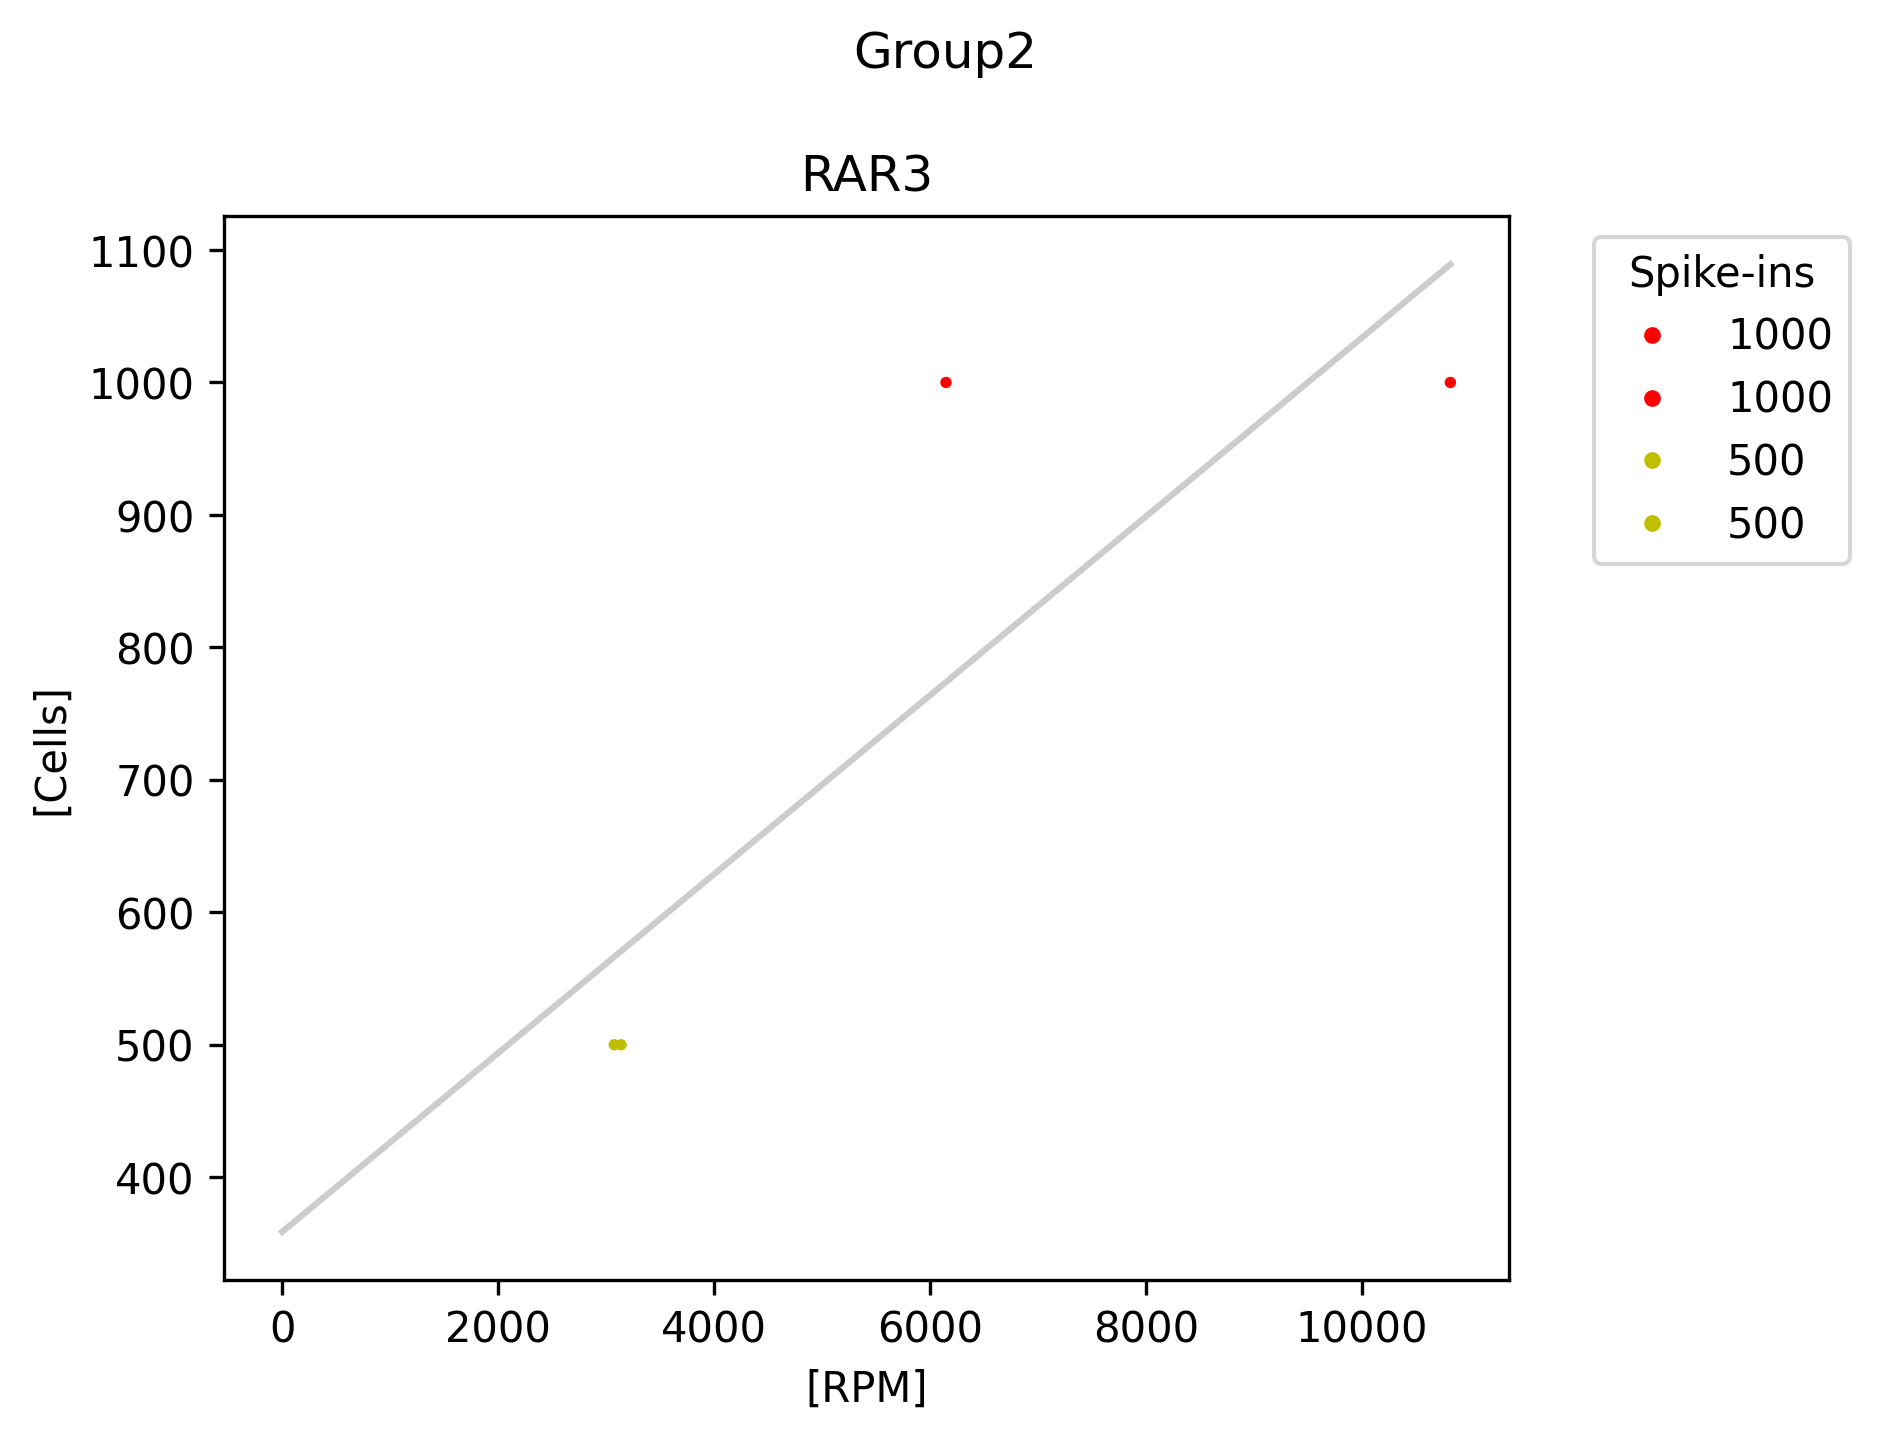

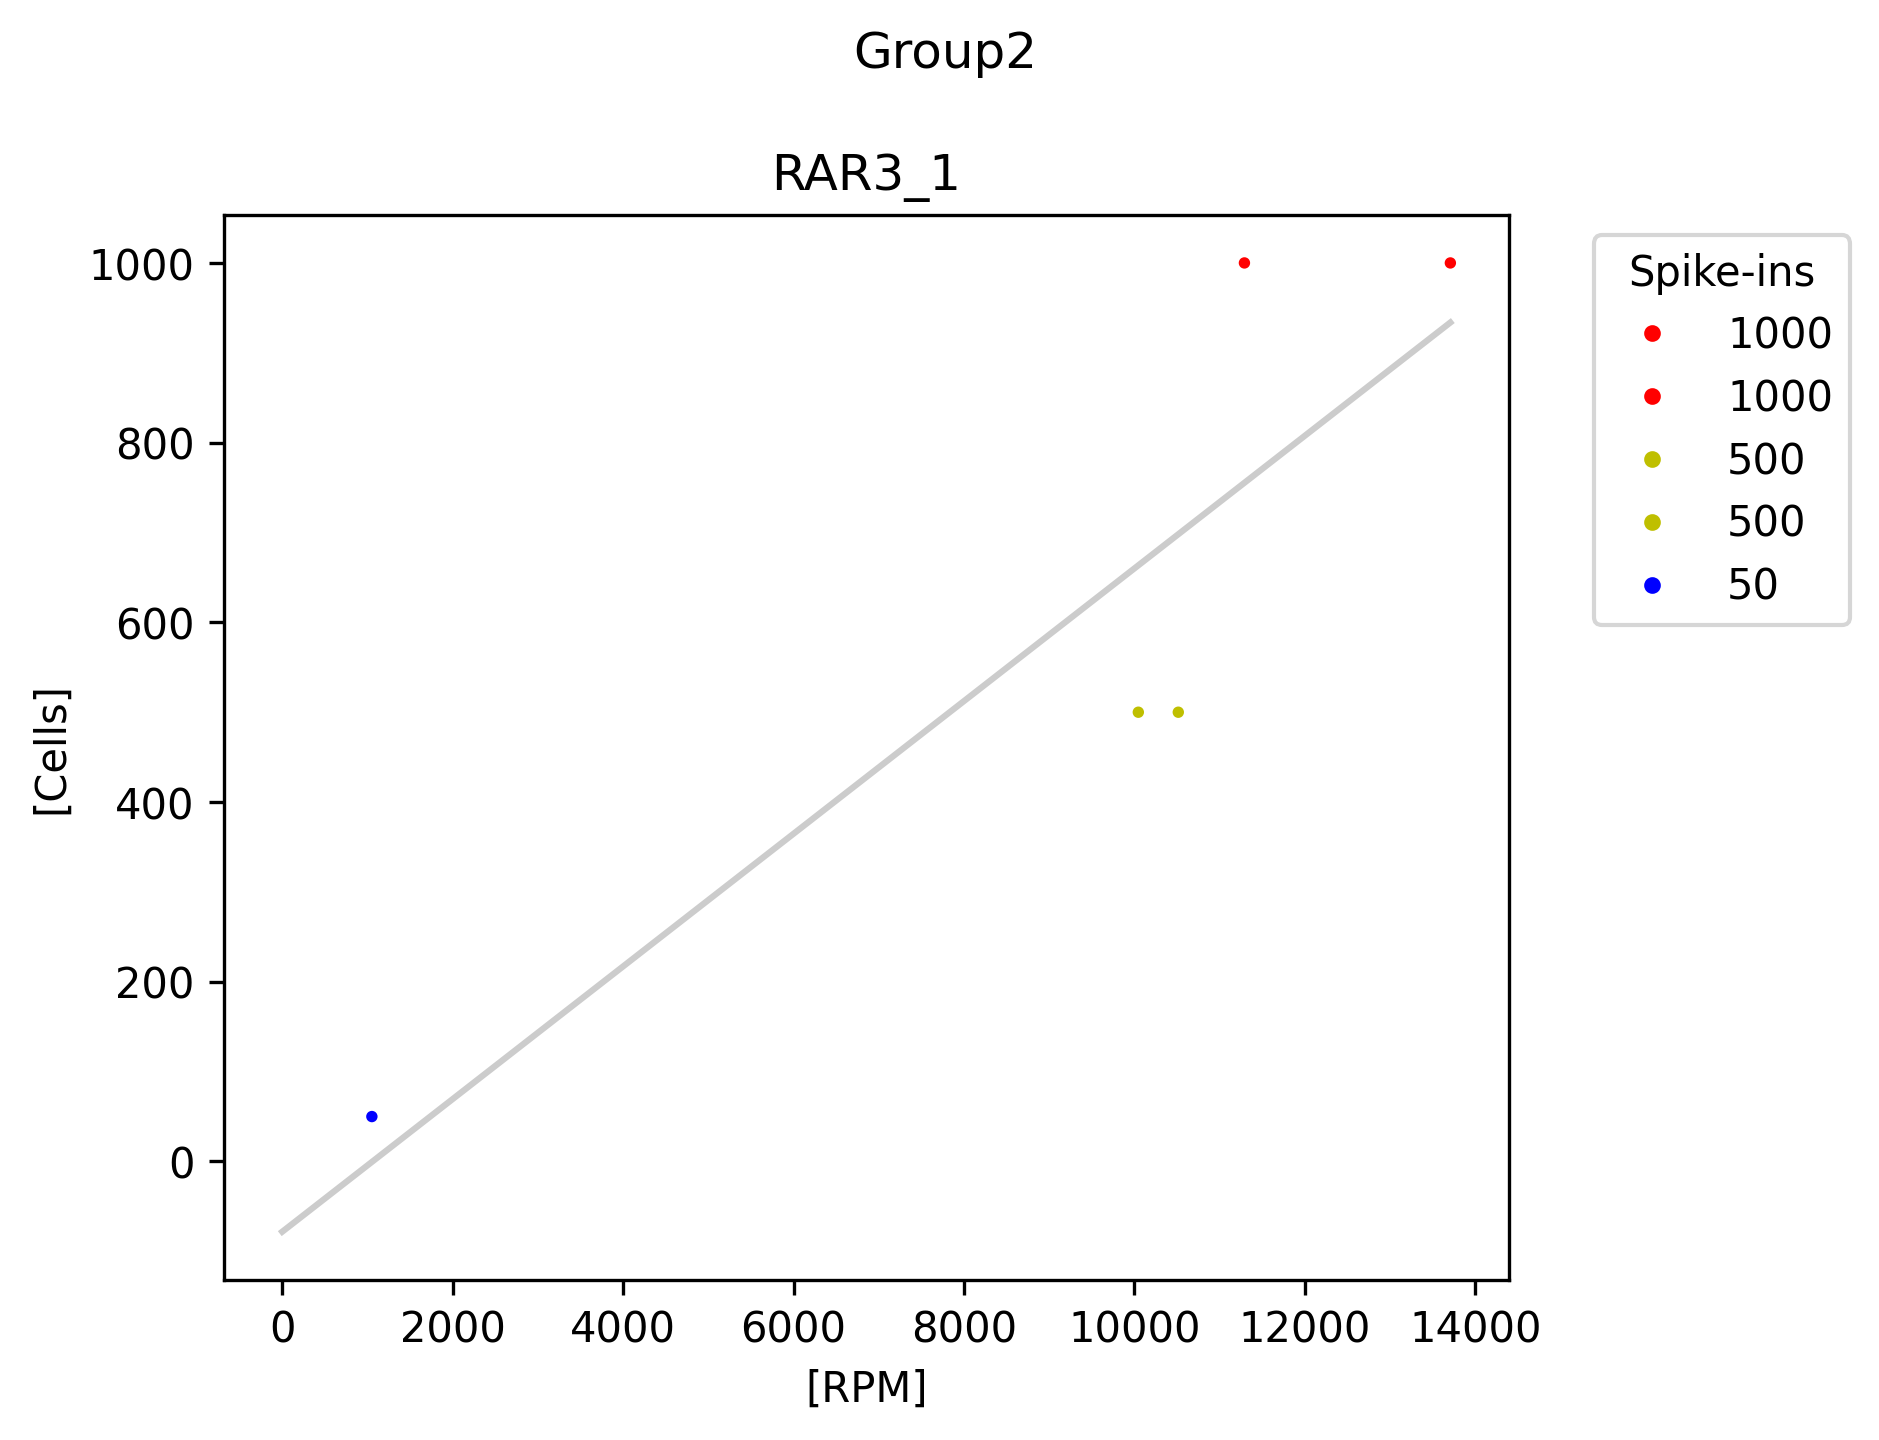

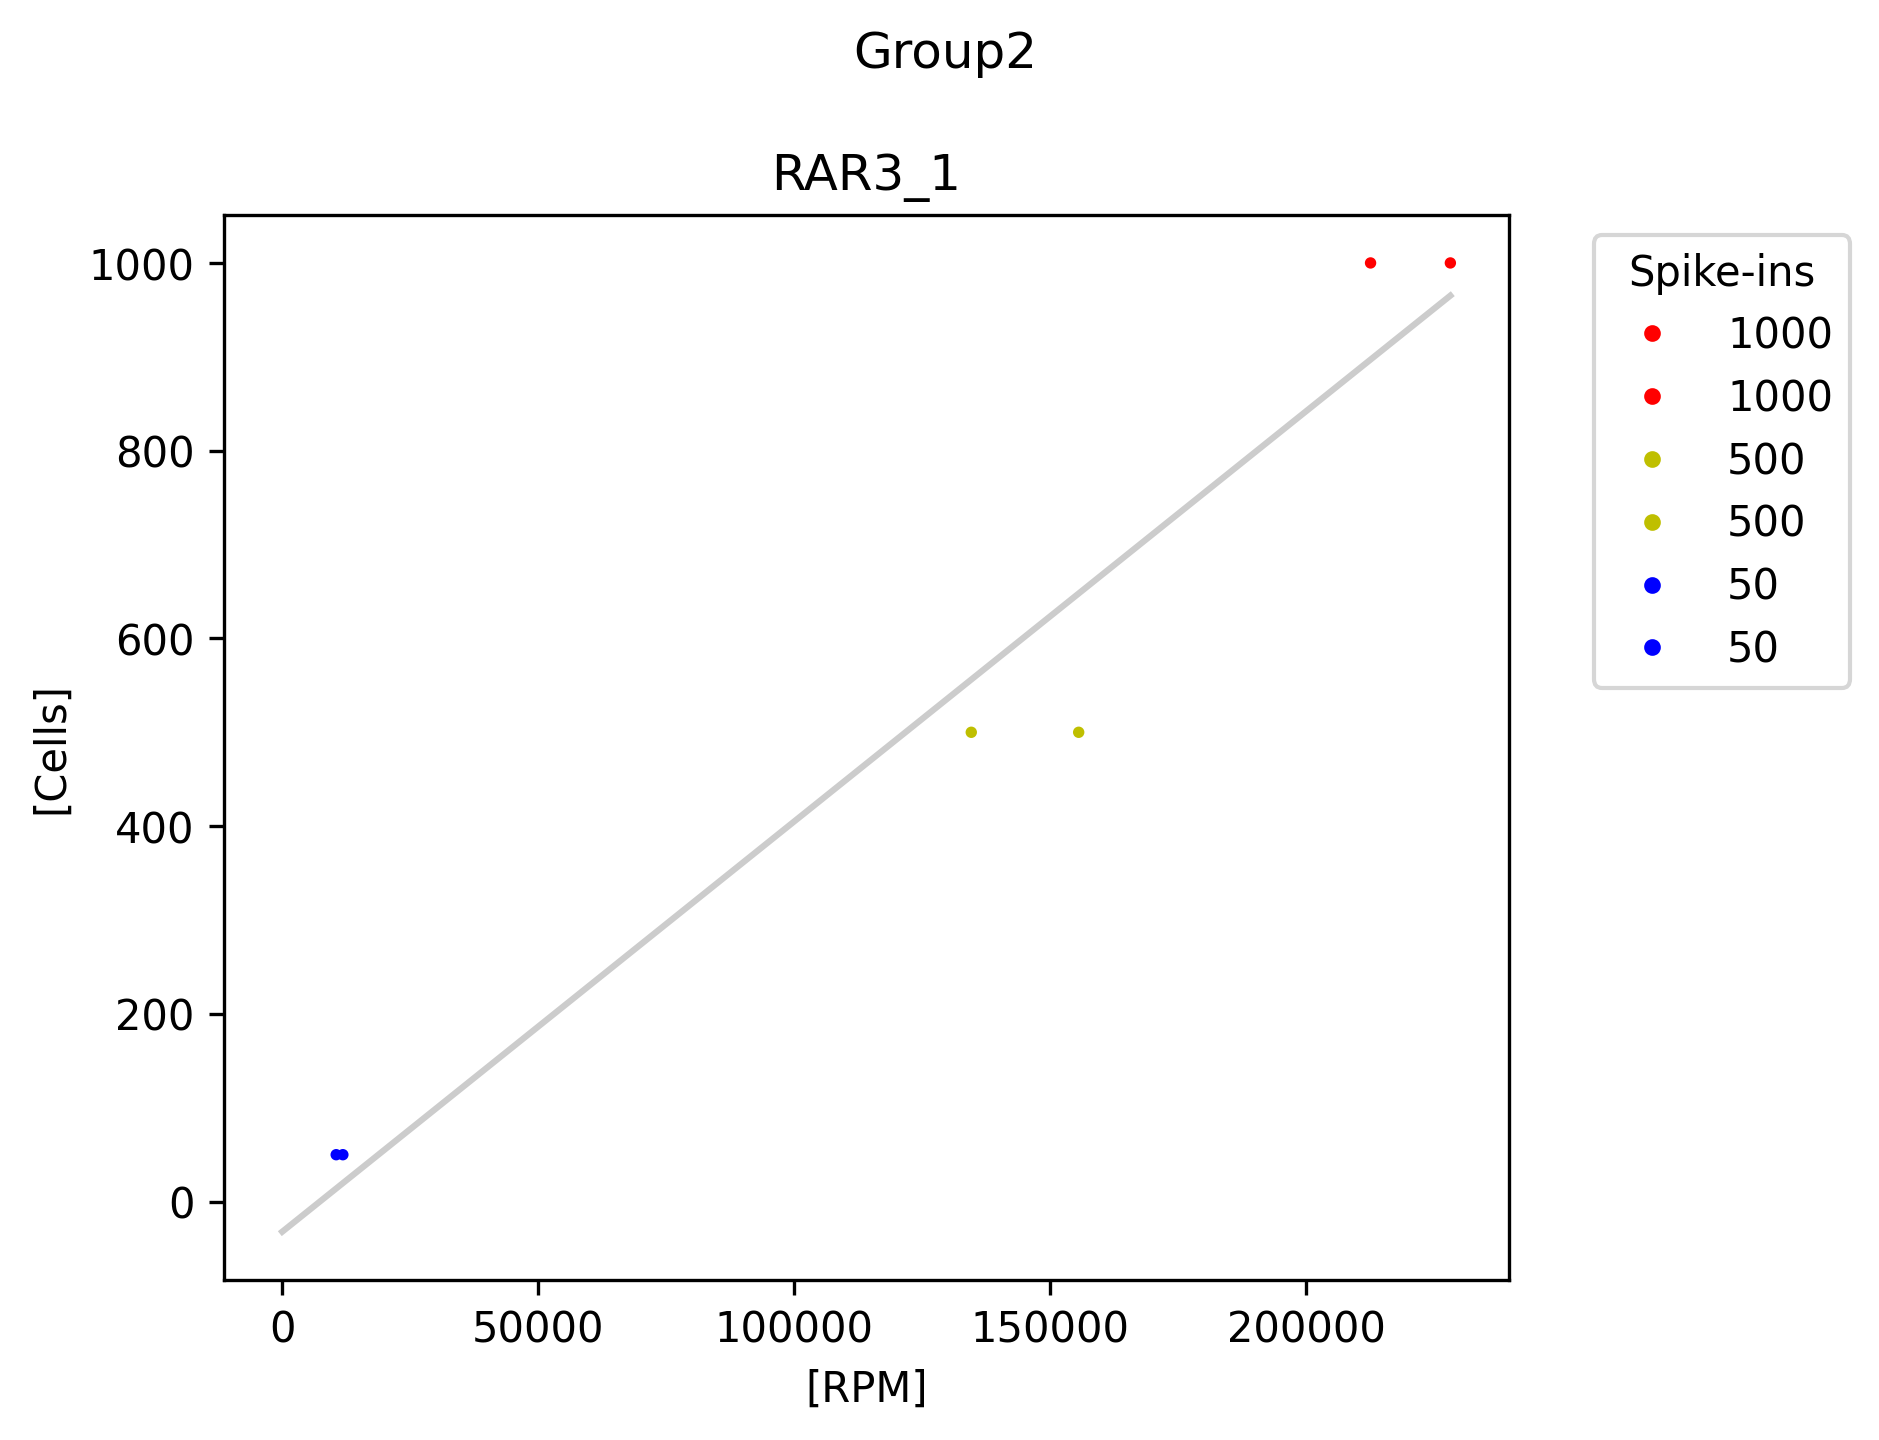

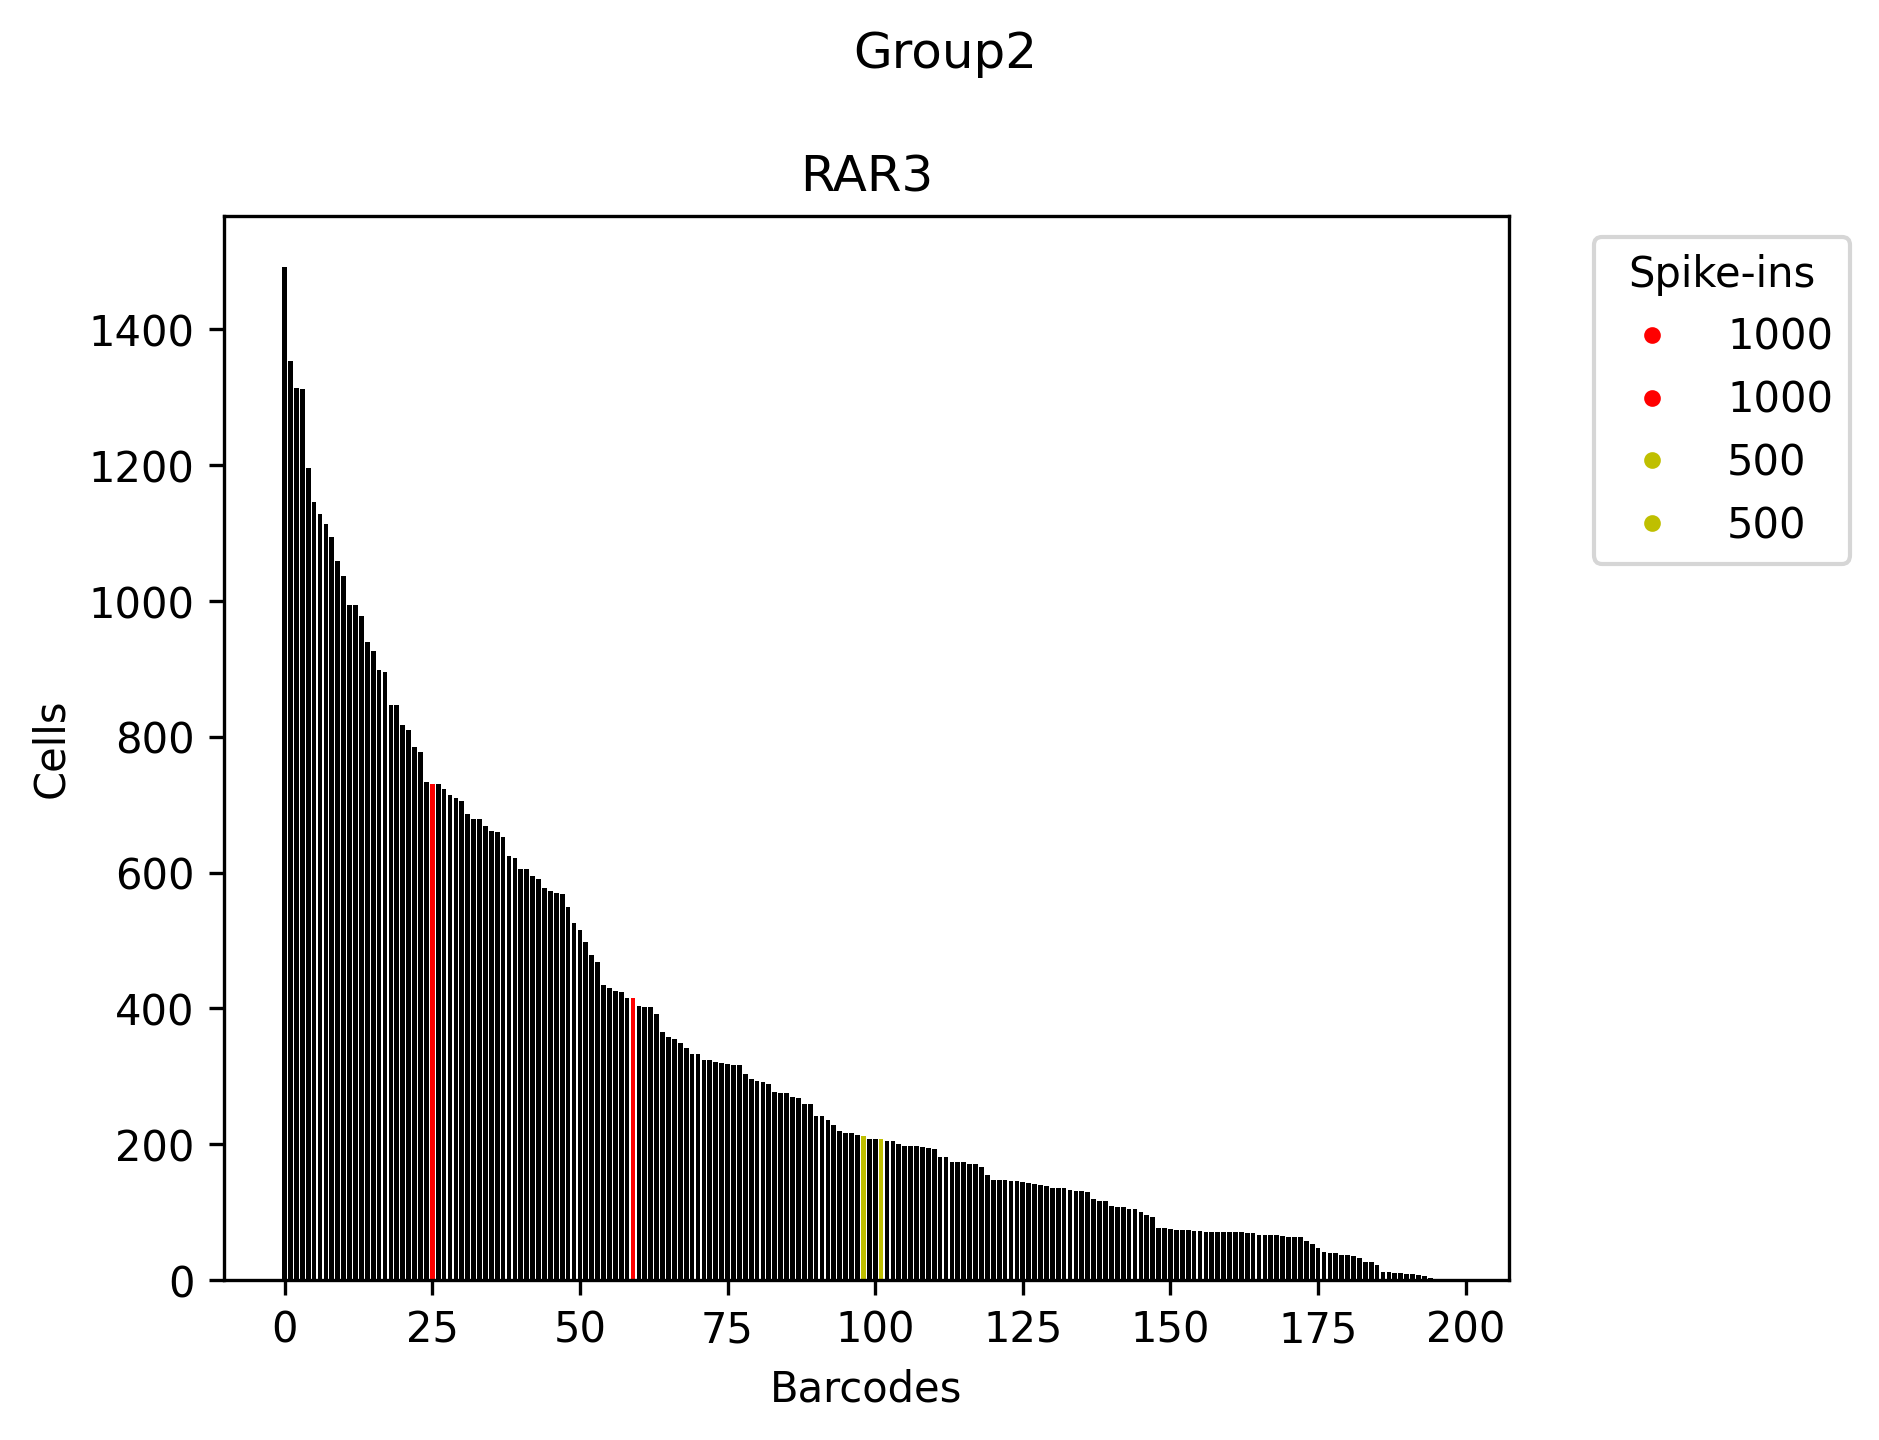

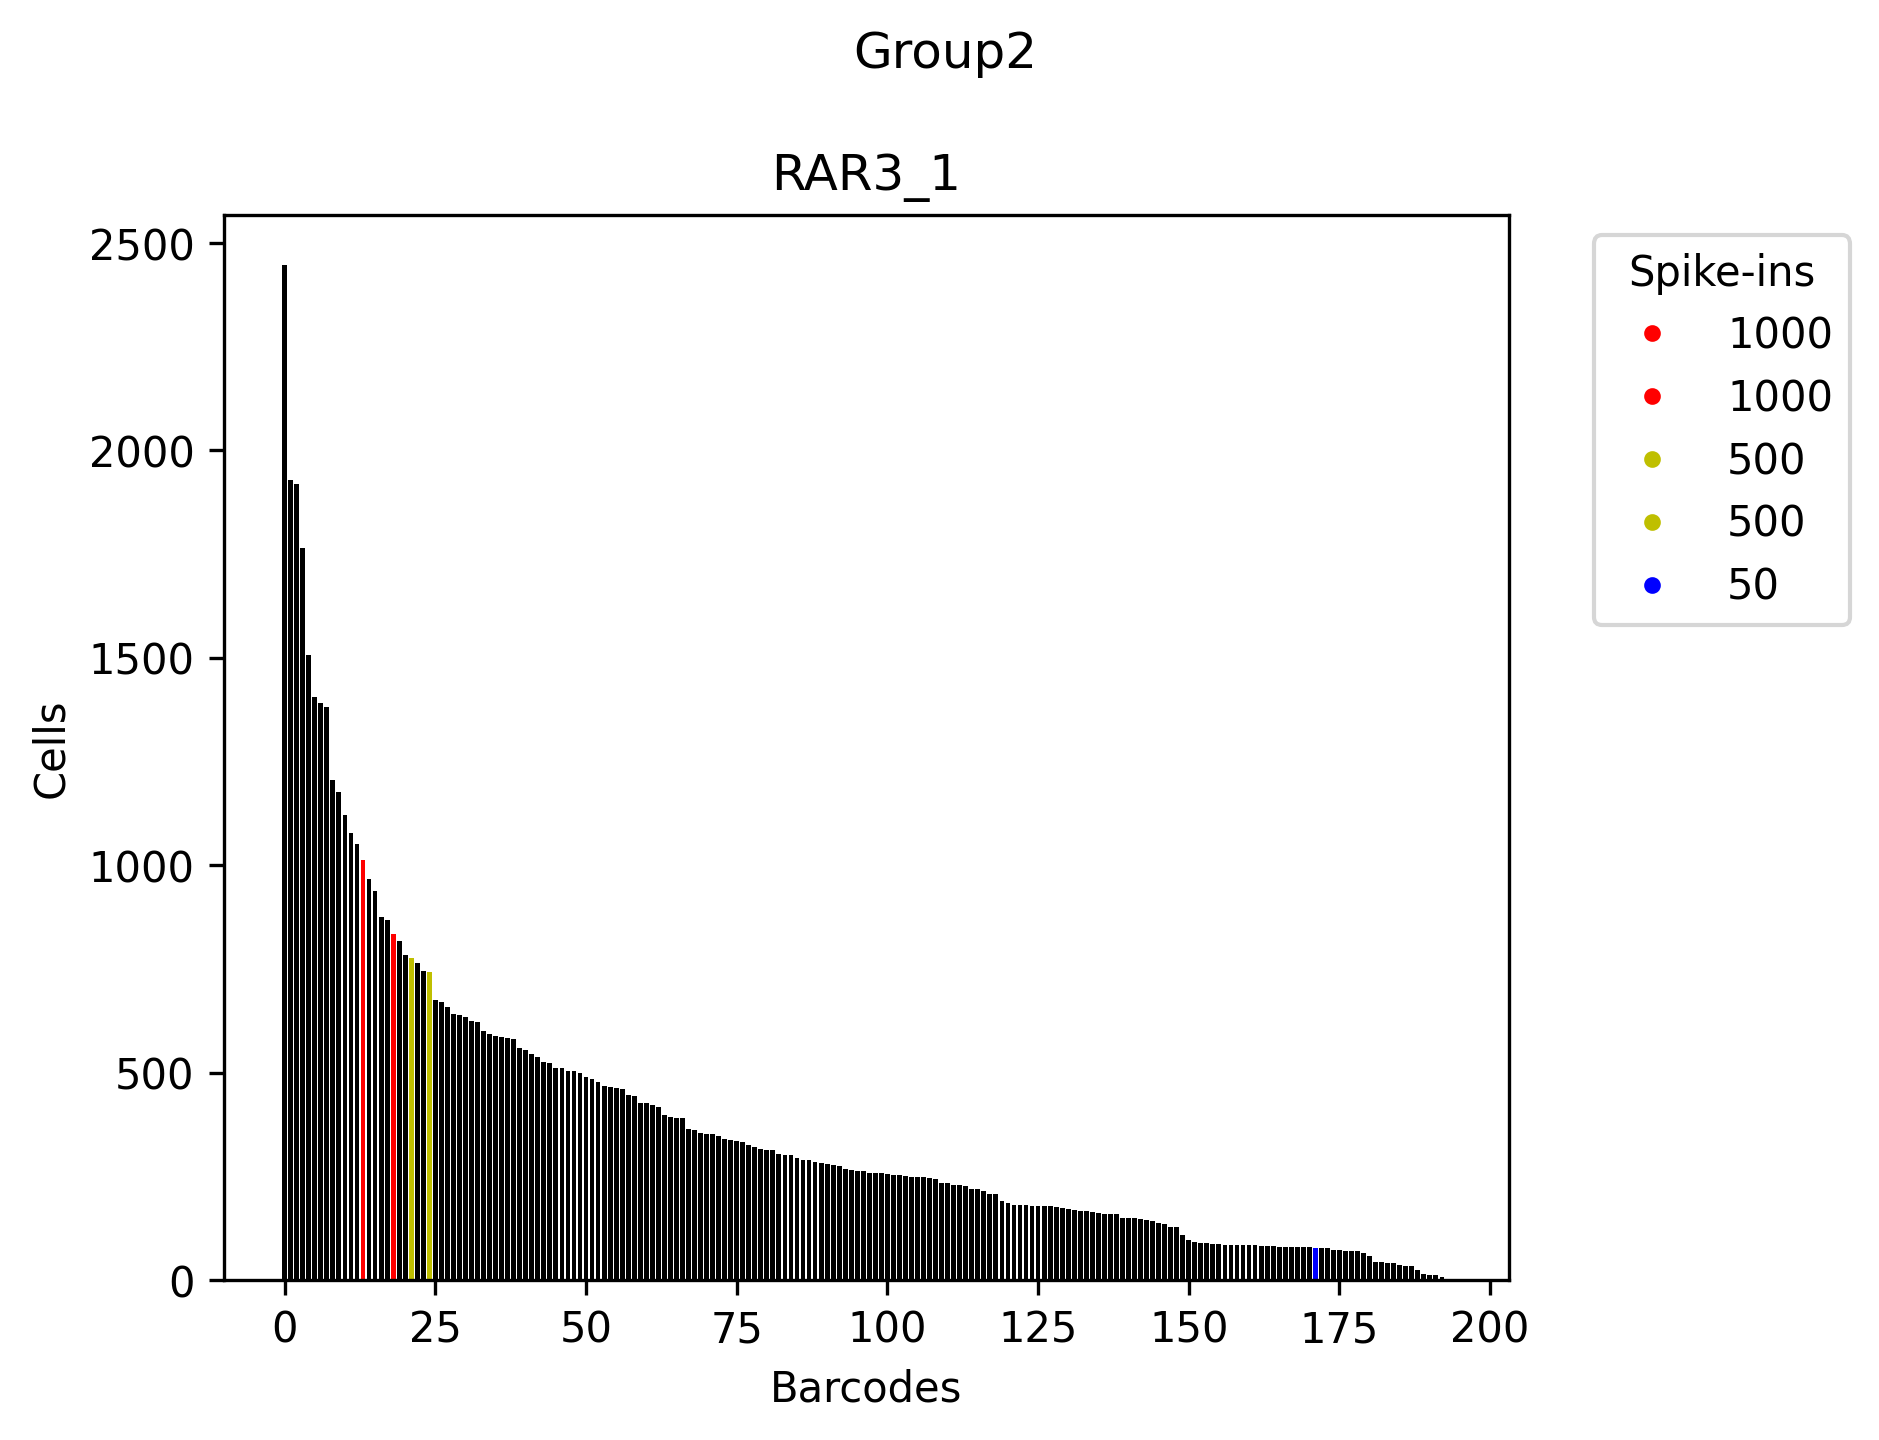

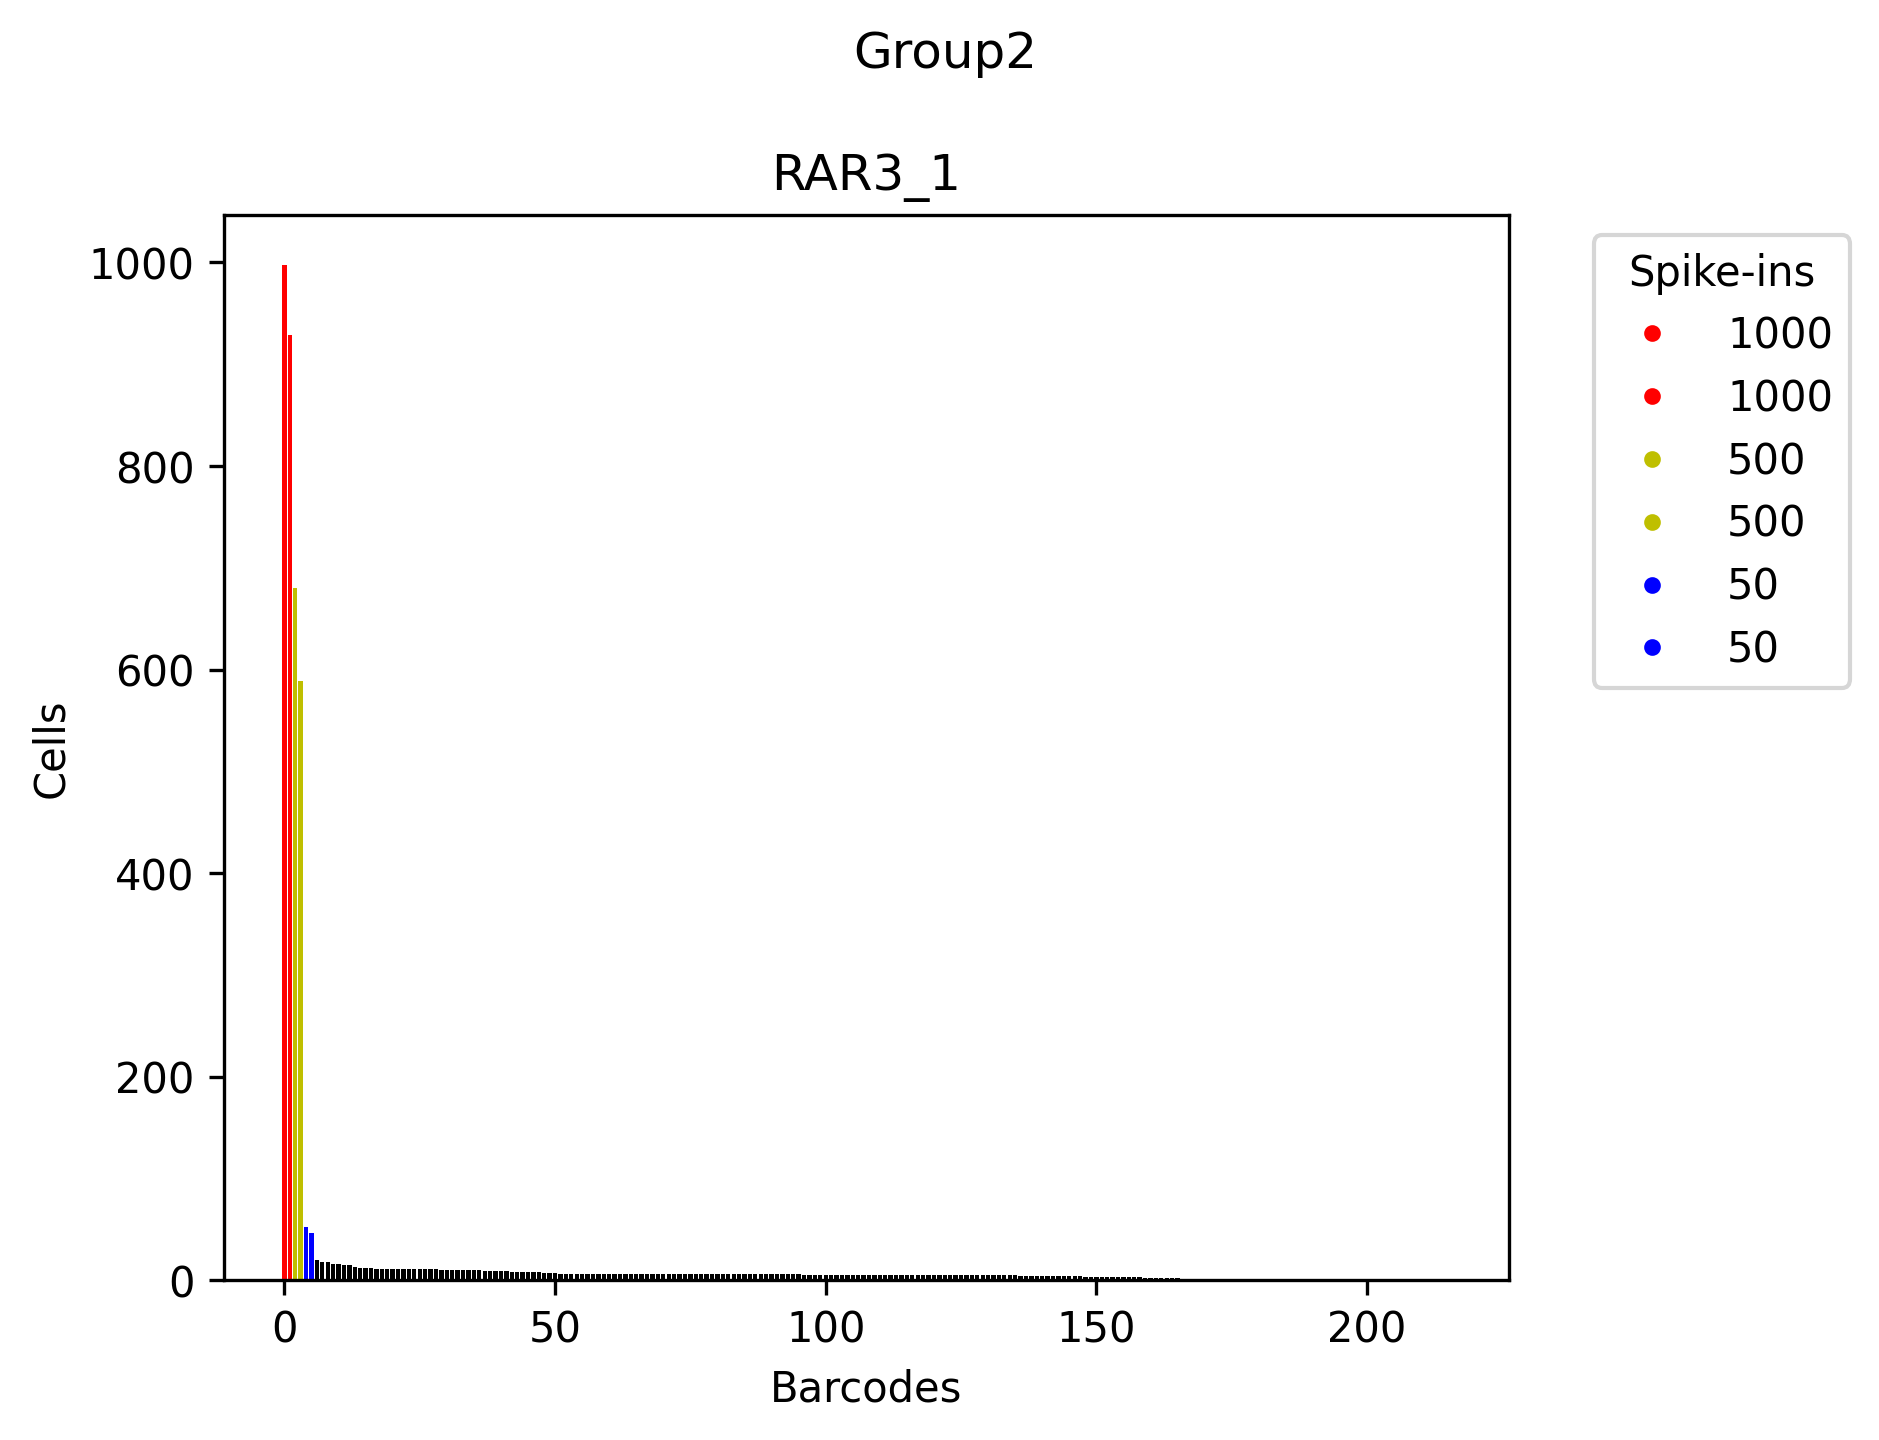

In [39]:
import pandas as pd
import itertools
GSAMP = [["RAR2","RAR2_1","RAR2_1"],["RAR3","RAR3_1","RAR3_1"]]
Outfolder = "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data_old/split_barcode/output"

barcode_quantify_folder =  Outfolder + "/barcode_quantify/"
path_to_feature_ref =      "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/20220110_gDNA_barcode/CellRanger_inputs/FeatureReference_filtered.csv"#Outfolder + "/CellRanger_inputs/" + "FeatureReference_filtered.csv" 
path_to_sc_output_files = "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/20220110_gDNA_barcode/starcode_outputs/sc_output_counts_*.txt"#Outfolder + "/starcode_outputs/sc_output_counts_*.txt"

spike_in_added = "yes"
spike_in_seqs =  ["TGGAGGTGAAGCTCCAGTTGCAGATCGACGACTAGGTCAAGATGAACTTCGAGCACTTGGACCTCCACGT",#//1000
                      "ATTCATGTTCTTGAAGGACATGATGGTGTTCTTGTACCTGTTGTACTACGACCTCATGATCGTCATCAAG",#//1000
                      "AGTTCGTCTACCTCATCTTGATGATGTTCAAGTAGGACGACGAGTAGCTCTACCAGGTGCAGATCGTGCA",#//500
                      "TGTAGATCTAGCTGATGTACGTGATCTTGGACATCTTCTTCATCCACCTCTTGATGAAGTACTACTTCAA",#//500
                      "ACCTGTAGATGTTCATGCTGTTCGAGTTGATGTTCTTGTTGCACAAGCACTACATGCTGTTGTACTTGGT",#//50
                      "ACCTCCTGGTGCTGTACATGCTCTAGATCTACGTGTTCTTGTAGCTCTTCGTGTACATGCTGGTGGAGAT"]#//5
        
spike_in_value = [1000,1000,500,500,50,50]

spike_in_color = ["r","r","y","y","b","b"]        
        
counter = 0
for grp in GSAMP:

    counter += 1
    print("     group"+ str(counter) +' :')
    print(" ")
    path_to_group_folder = barcode_quantify_folder + "plots_group"+ str(counter) + "/"
    #os.mkdir(path_to_group_folder)


    #Load in Data
    filepath = barcode_quantify_folder  + '/FeatureReference_filtered_group'+ str(counter) + '_counts.csv'
    df_ref = pd.read_csv(filepath)

    #----------------------------Find and label spike ins------------------
    df_ref['spike_in_c'] = ['k']*len(df_ref.iloc[:,0])

    if spike_in_added == 'yes':
        for sp,spike_in_seq in enumerate(spike_in_seqs):
            df_ref.loc[df_ref['sequence'].str.match(spike_in_seq),'spike_in_c'] = spike_in_color[sp]


    #----------------------------Remove 0 and 1----------------------------
    print("         Removing zeros and ones")
    print(" ")

    df_plot = df_ref.iloc[:,-len(grp)-1:]

    df_plot = df_plot.replace(0, np.nan, regex=True)
    df_plot = df_plot.replace(1, np.nan, regex=True)

    #----------------------------Reads per million--------------------------
    for i in range(len(grp)):
        df_plot.iloc[:,i] = rpm_norm(df_plot.iloc[:,i])

    #-------------------------Get all combinations--------------------------
    all_combinations = itertools.combinations([g for g in range(len(grp))],2)

    print("             Plot:")
    #Keep Spike-ins color
    all_spike_in_color_in_grp = []
    all_spike_in_value_in_grp = []
    all_line_fit = []
    summary_spike_in = []
    for i in range(len(grp)):

        print("                   Spike - "  + grp[i])
        plot_f = plt.figure()

        y = df_plot.iloc[:,i] 
        col_y = df_plot.iloc[:,-1]

        new_y =[]
        new_col_y =[]

        for n,m in enumerate(col_y):
            if m in spike_in_color:
                #Clean up any possibly lost barcodes
                if np.isnan(y[n]) == False:
                    new_y.append(y[n])
                    new_col_y.append(m)
        summary_spike_in.append(len(new_col_y))

        #Make the order of spike-ins found the same as the spike_in_values
        x = new_col_y
        test_list = list(zip( x,range(len(x))))
        sort_order = spike_in_color # initializing sort order
        test_list.sort(key = lambda i: sort_order.index(i[0])) 

        new_y = [new_y[a] for _,a in test_list]

        #Remove colors that had a nan
        new_spike_in_color = []
        new_spike_in_value = []
        remove_new_col_y = new_col_y
        for c,col in enumerate(spike_in_color):
            if col in remove_new_col_y:
                remove_new_col_y.remove(col)

                new_spike_in_color.append(col)
                new_spike_in_value.append(spike_in_value[c])

        #Fit line
        m, b = np.polyfit(new_y,new_spike_in_value, 1)

        all_line_fit.append([m,b])

        x_line = np.linspace(0, max(new_y), 2)
        y_line = [k*m+b for k in x_line]


        #Plot
        scatt = plt.scatter(new_y,new_spike_in_value, s=3, c=new_spike_in_color)

        plt.suptitle('Group'+ str(counter), y=0.99);
        plt.title(grp[i])
        plt.xlabel('[RPM]')
        plt.ylabel('[Cells]')
        plt.plot(x_line,y_line,'-',color = 'k', alpha=0.2)


        for c,cop in enumerate(new_spike_in_color):
            plt.plot([], [], '.'+cop, label=new_spike_in_value[c])
        plt.legend(title="Spike-ins",bbox_to_anchor=(1.05, 1.0), loc='upper left')

        plt.tight_layout()



        all_spike_in_color_in_grp.append(new_spike_in_color)
        all_spike_in_value_in_grp.append(new_spike_in_value)
    
    
    summary_filter_in = []
    print("             ")
    for i in range(len(grp)):

        print("                   Bar - " + grp[i])
        plot_f = plt.figure()

        y = df_plot.iloc[:,i]
        col_y = df_plot.iloc[:,-1]

        new_y =[]
        new_col_y =[]
        for x,m in enumerate(y):
            if np.isnan(m) == False:
                new_y.append(m)
                new_col_y.append(col_y[x])
        summary_filter_in.append(len(new_y))

        if spike_in_added == 'yes':
            #Convert from RPM to Cells
            m,b = all_line_fit[i]
            new_y = [k*m for k in new_y]

        #Order
        index_y = sorted(range(len(new_y)), reverse=True,key=new_y.__getitem__)
        new_col_y = [new_col_y[k] for k in index_y]
        new_y = sorted(new_y, reverse=True)

        #Plot
        plt.bar(range(len(new_y)),new_y, color=new_col_y)
        plt.suptitle('Group'+ str(counter), y=0.99);
        plt.title(grp[i])
        plt.xlabel('Barcodes')
        if spike_in_added == 'yes':

            plt.ylabel('Cells')
            new_spike_in_color = all_spike_in_color_in_grp[i]
            new_spike_in_value = all_spike_in_value_in_grp[i]

            for c,cop in enumerate(new_spike_in_color):
                plt.plot([], [], '.'+cop, label=new_spike_in_value[c] )
            plt.legend(title="Spike-ins",bbox_to_anchor=(1.05, 1.0), loc='upper left')
        else:
            plt.ylabel('RPM')

        plt.tight_layout()

### Lets calculate the Pearson

     group1 :
 
         Removing zeros and ones
 
             Plot:
                   Spike - RAR2
                   Spike - RAR2_1
                   Spike - RAR2_1
             
                   Scatt - RAR2 and RAR2_1
(0, 1)
                   Scatt - RAR2 and RAR2_1
(0, 2)
                   Scatt - RAR2_1 and RAR2_1
(1, 2)
     group2 :
 
         Removing zeros and ones
 
             Plot:
                   Spike - RAR3
                   Spike - RAR3_1
                   Spike - RAR3_1
             
                   Scatt - RAR3 and RAR3_1
(0, 1)
                   Scatt - RAR3 and RAR3_1
(0, 2)
                   Scatt - RAR3_1 and RAR3_1
(1, 2)


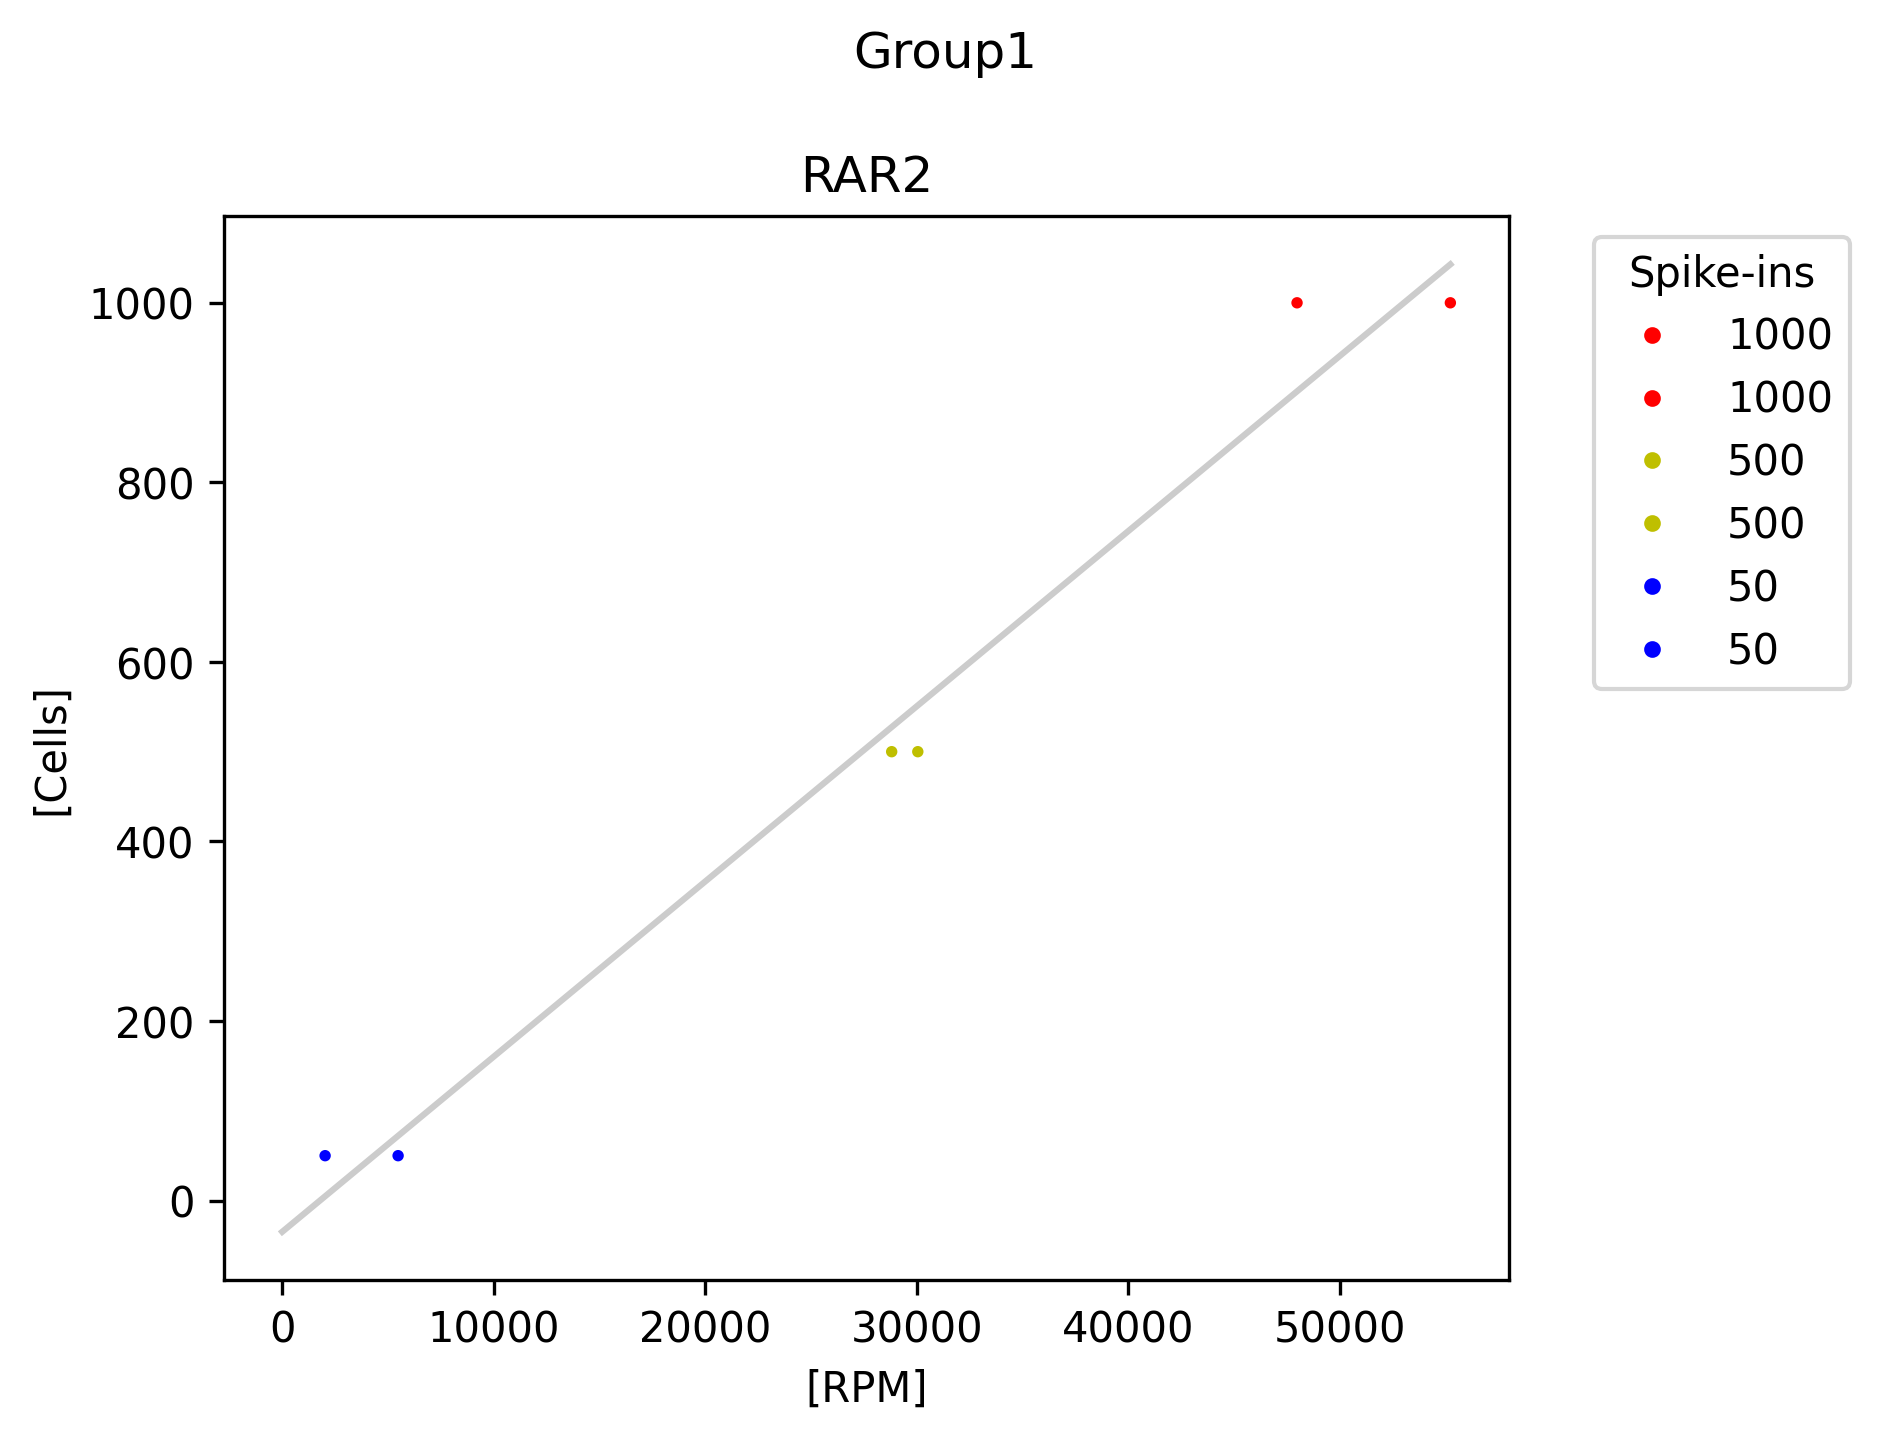

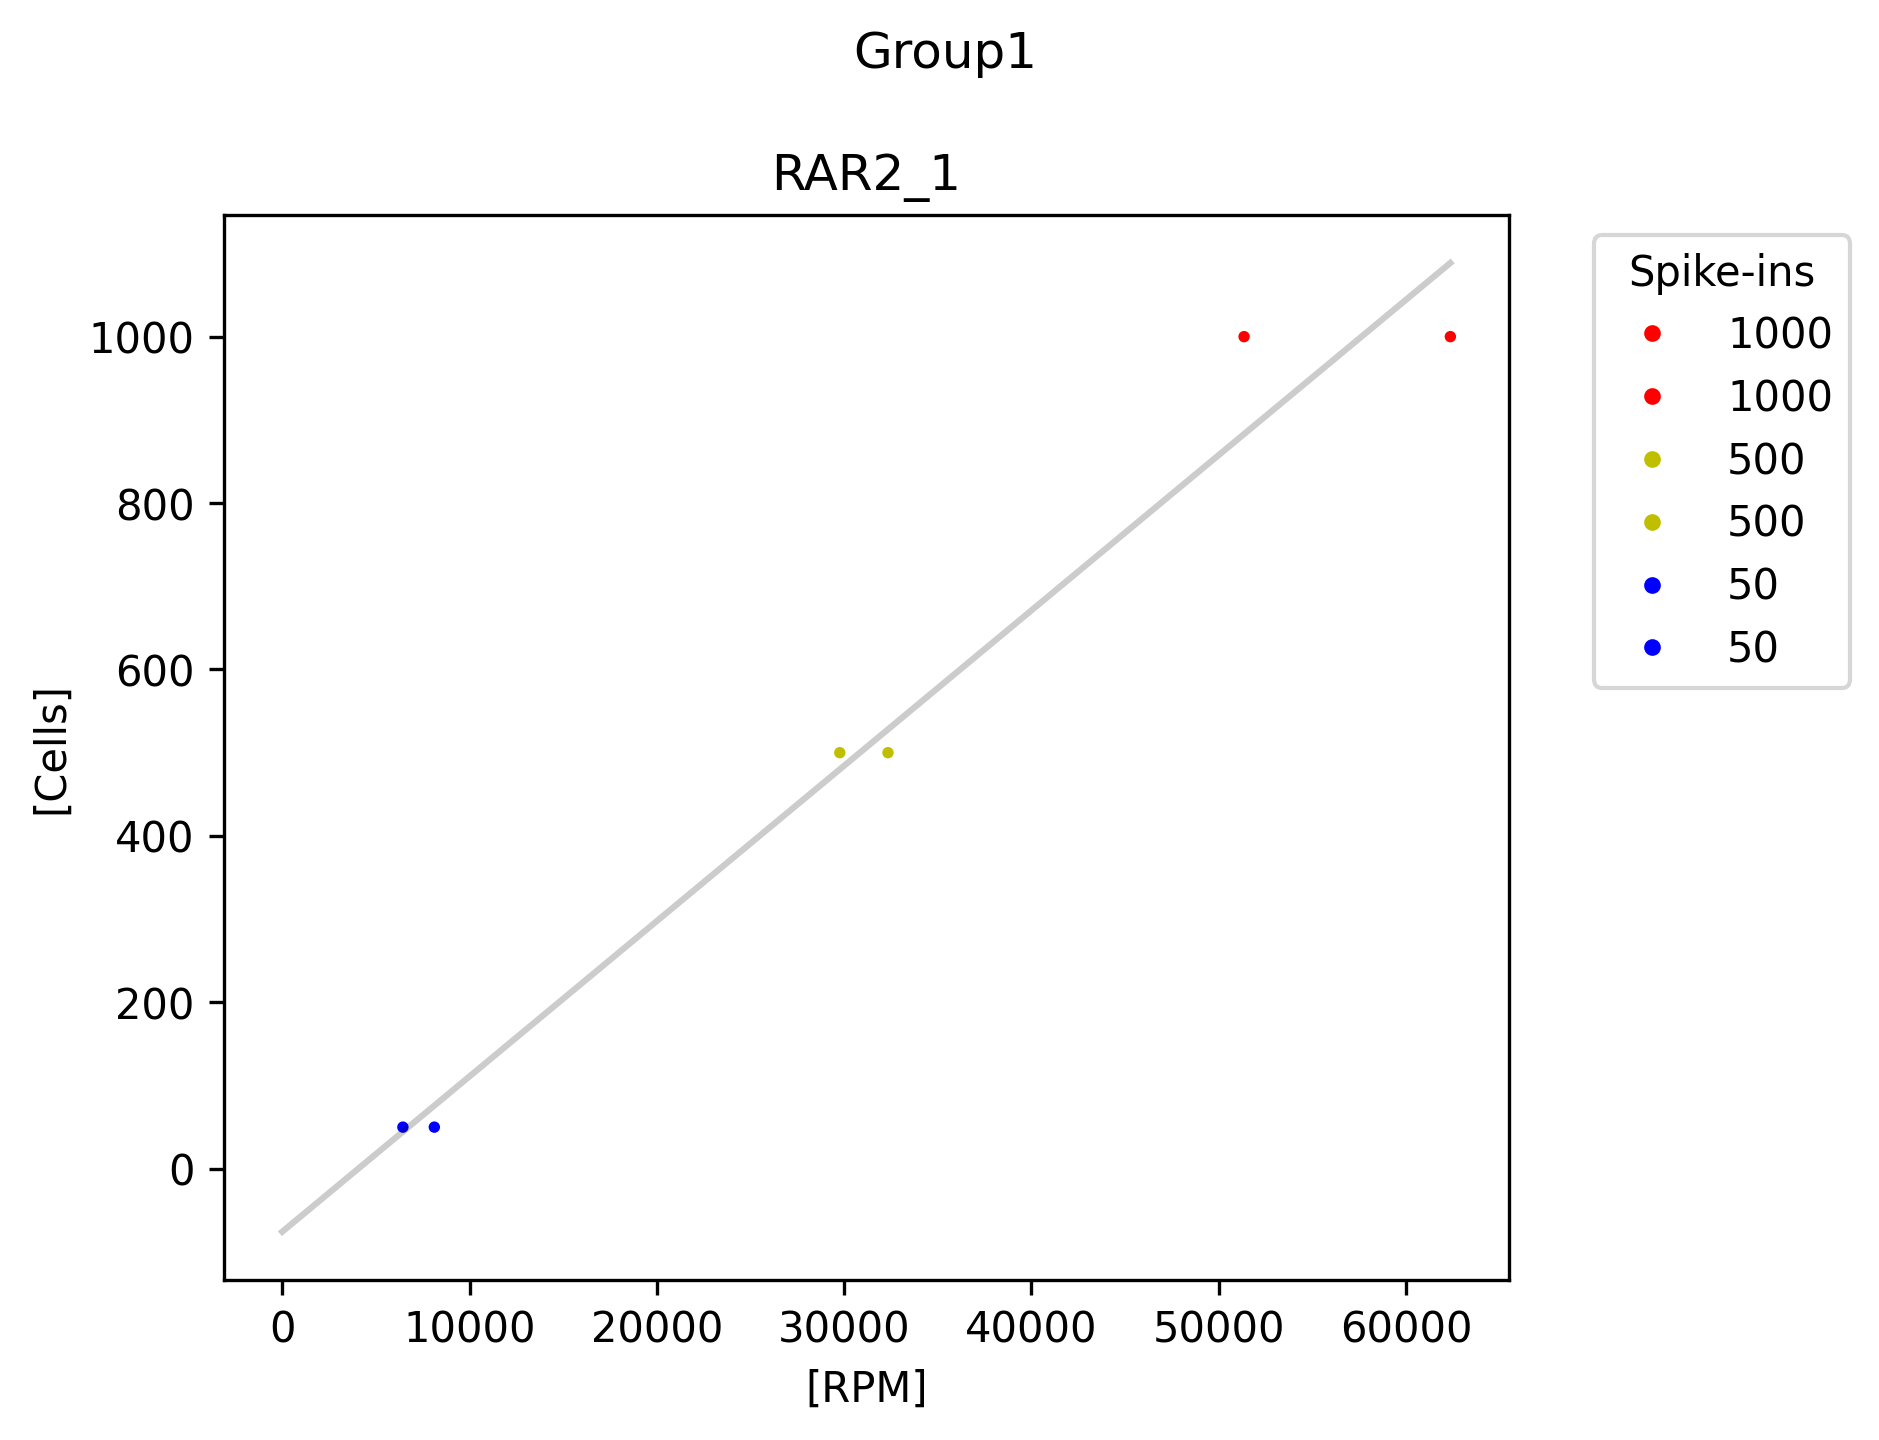

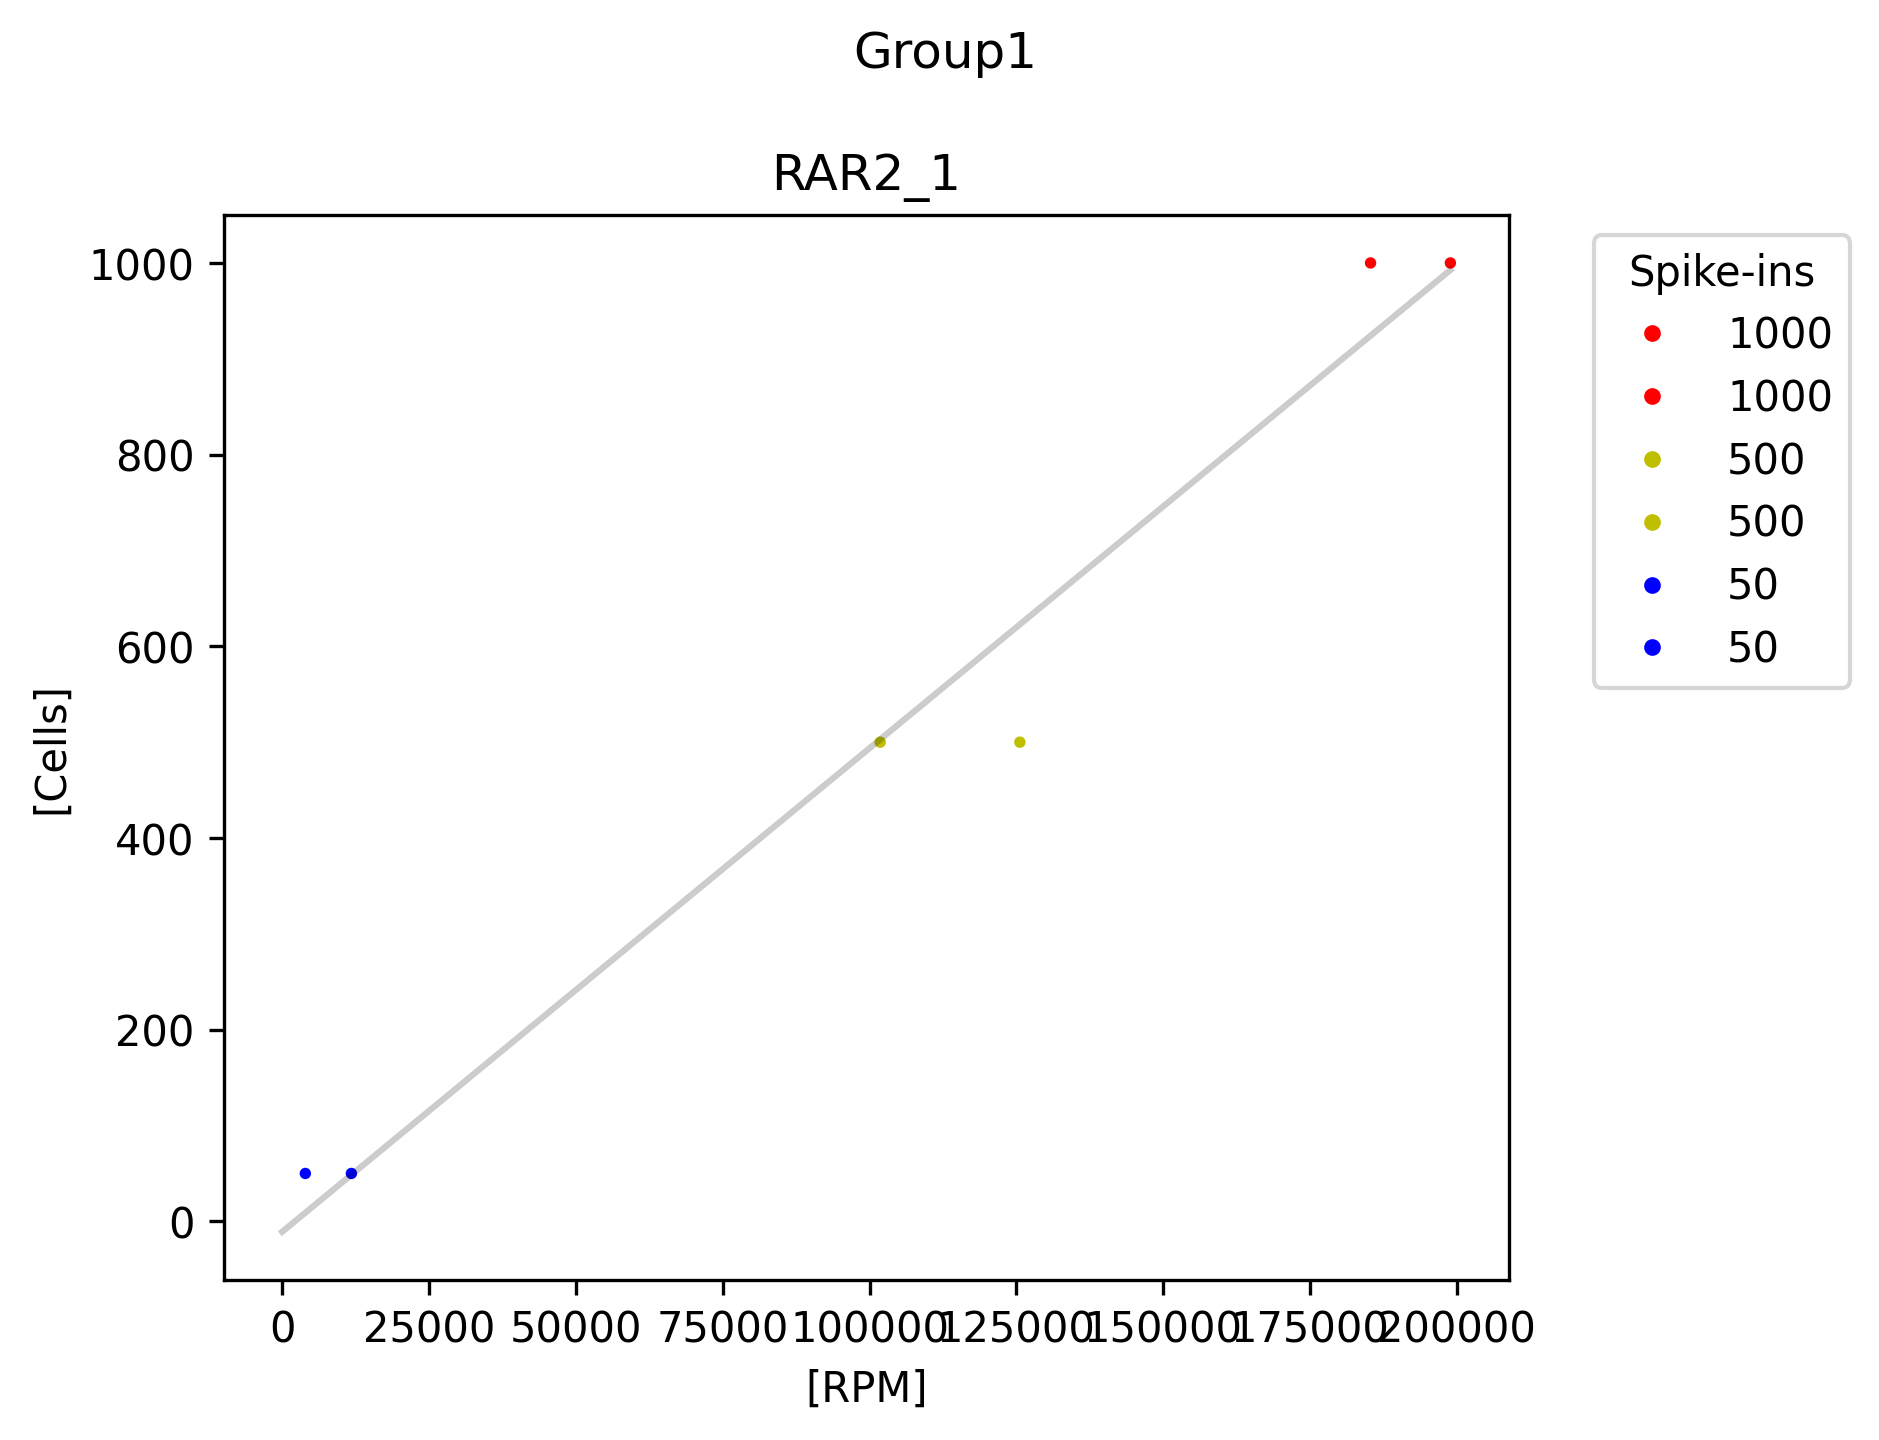

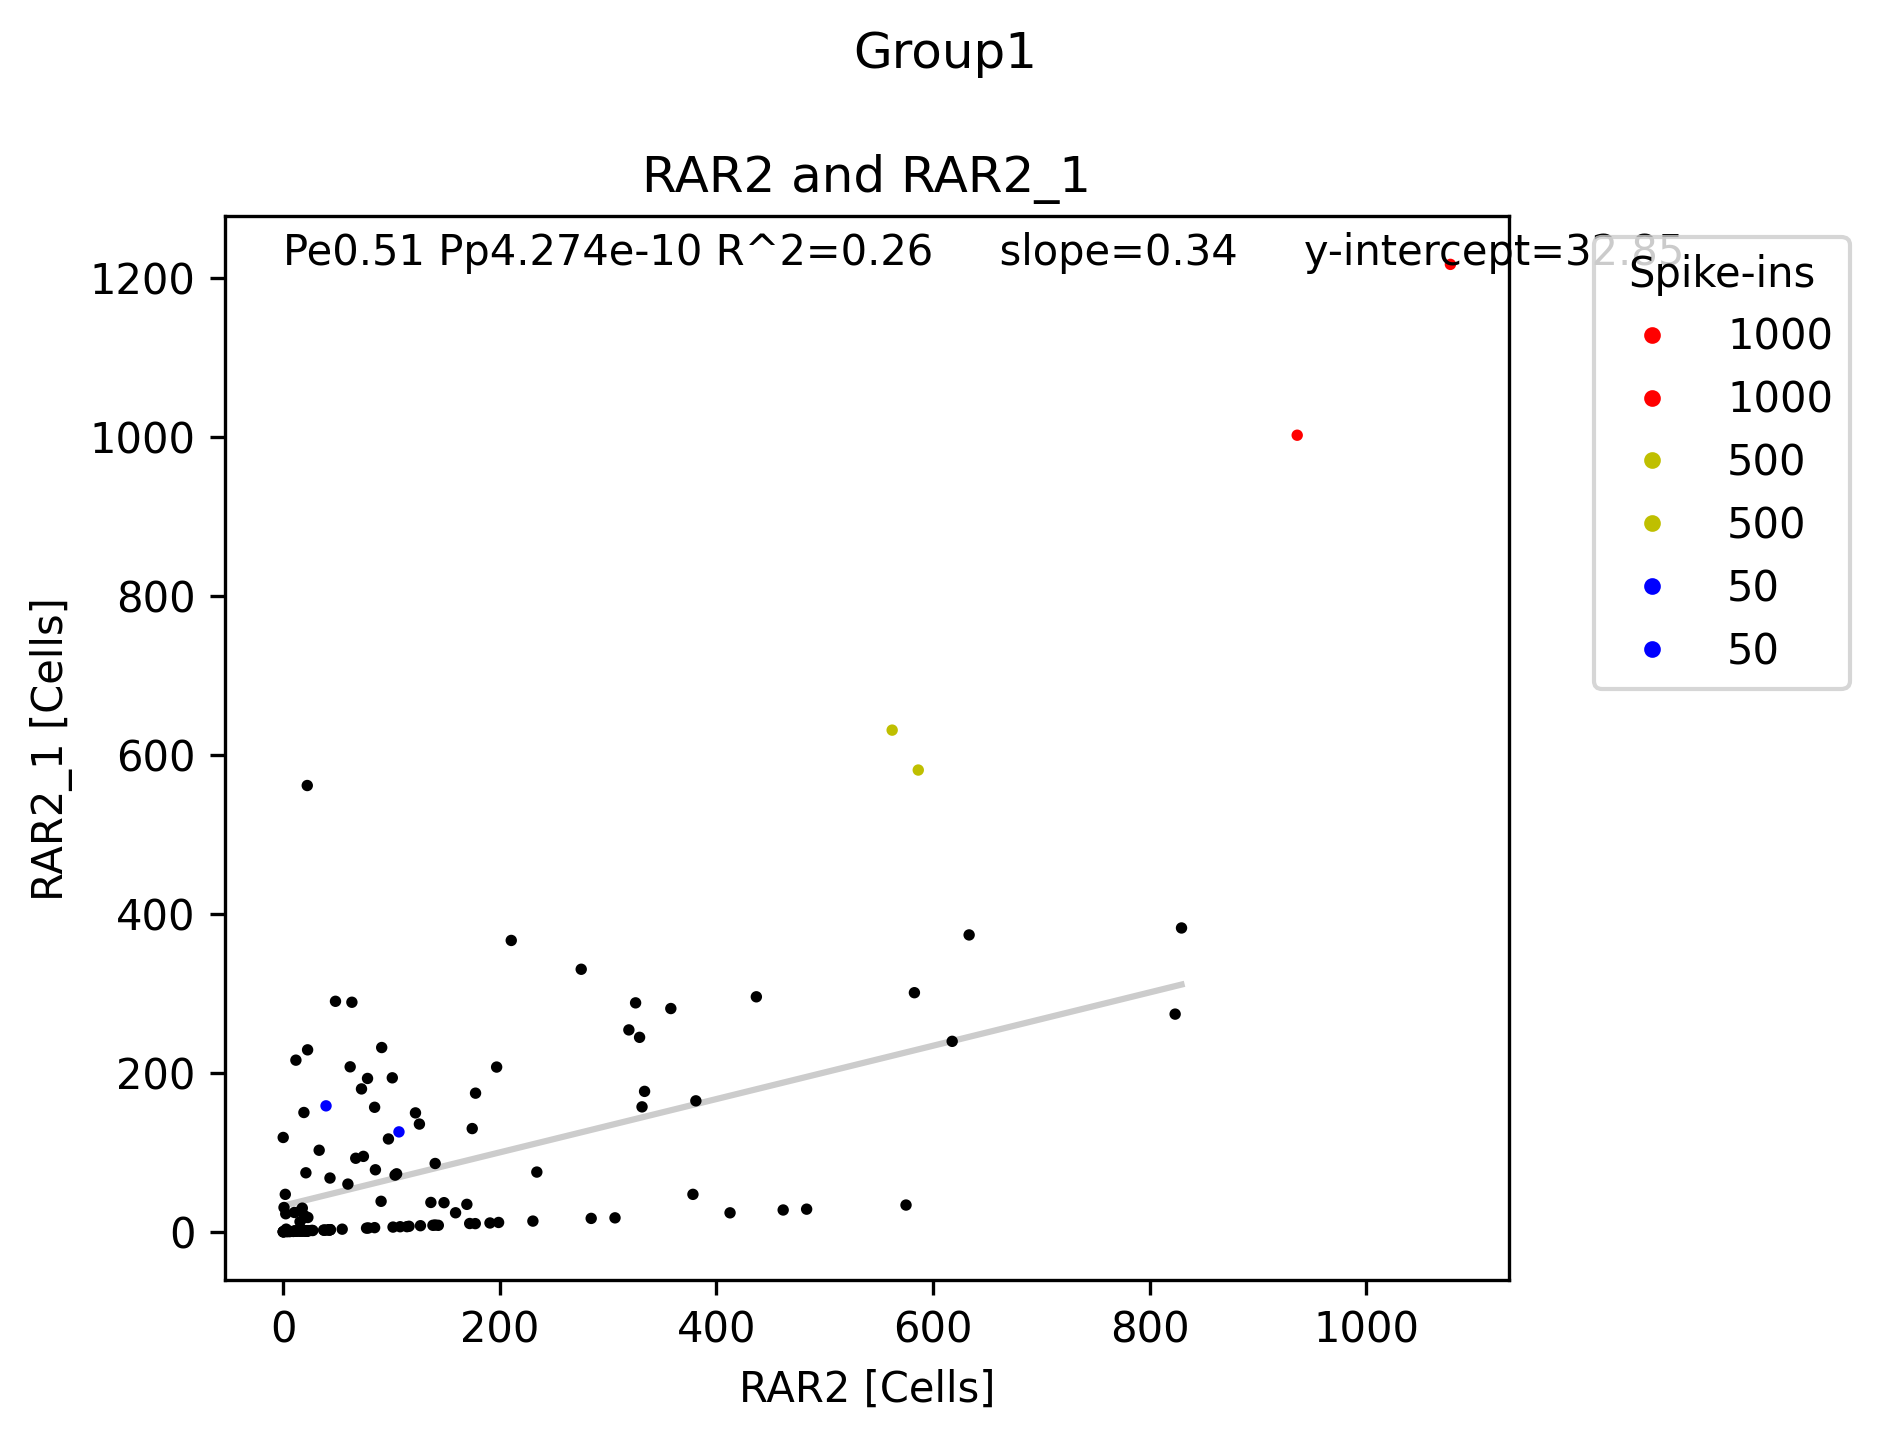

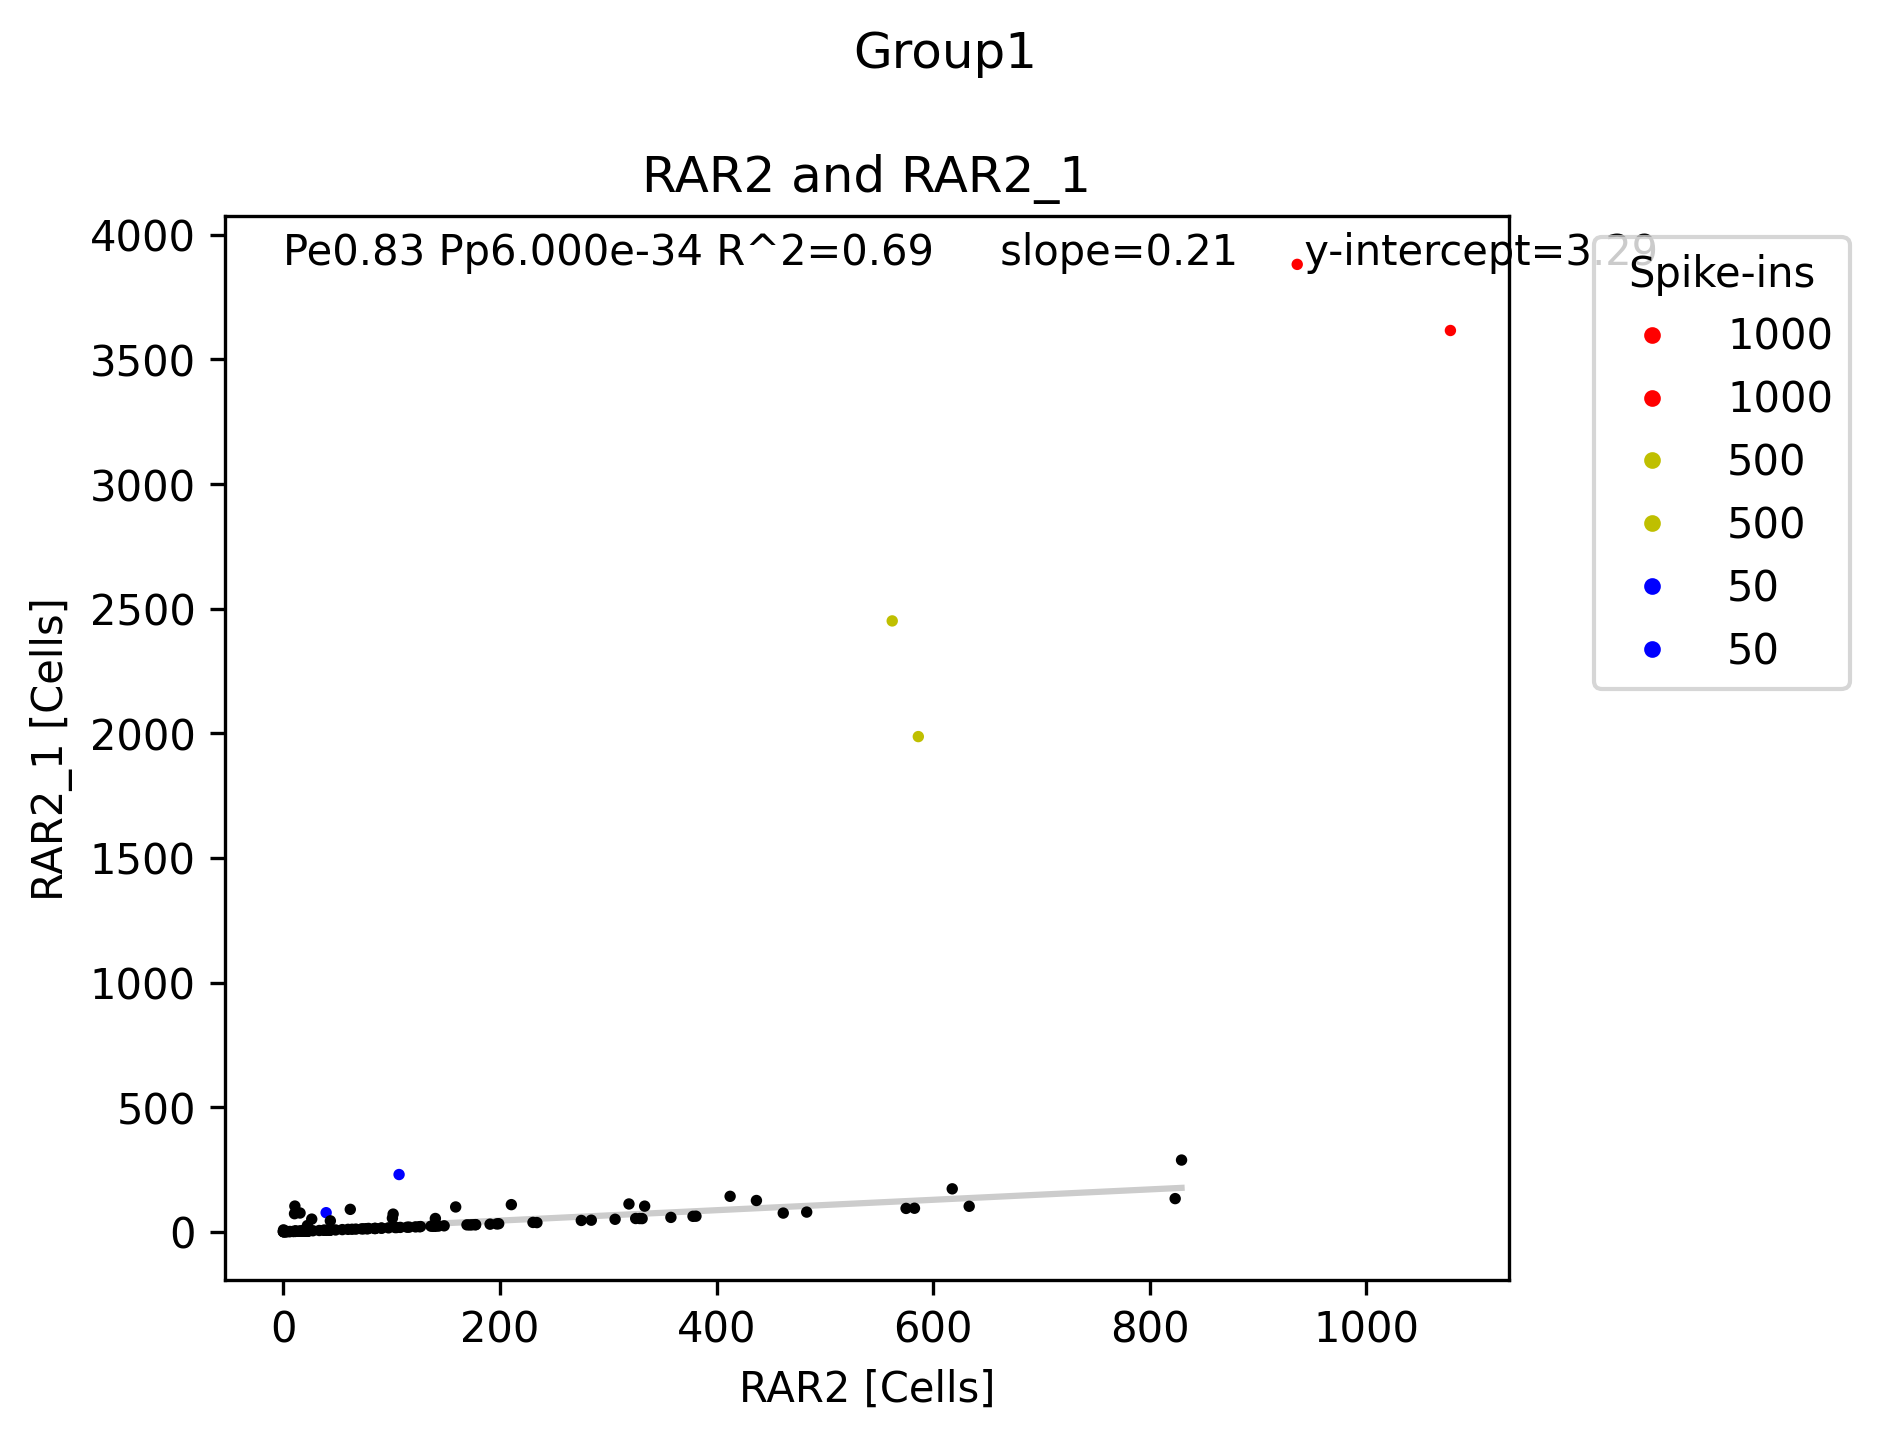

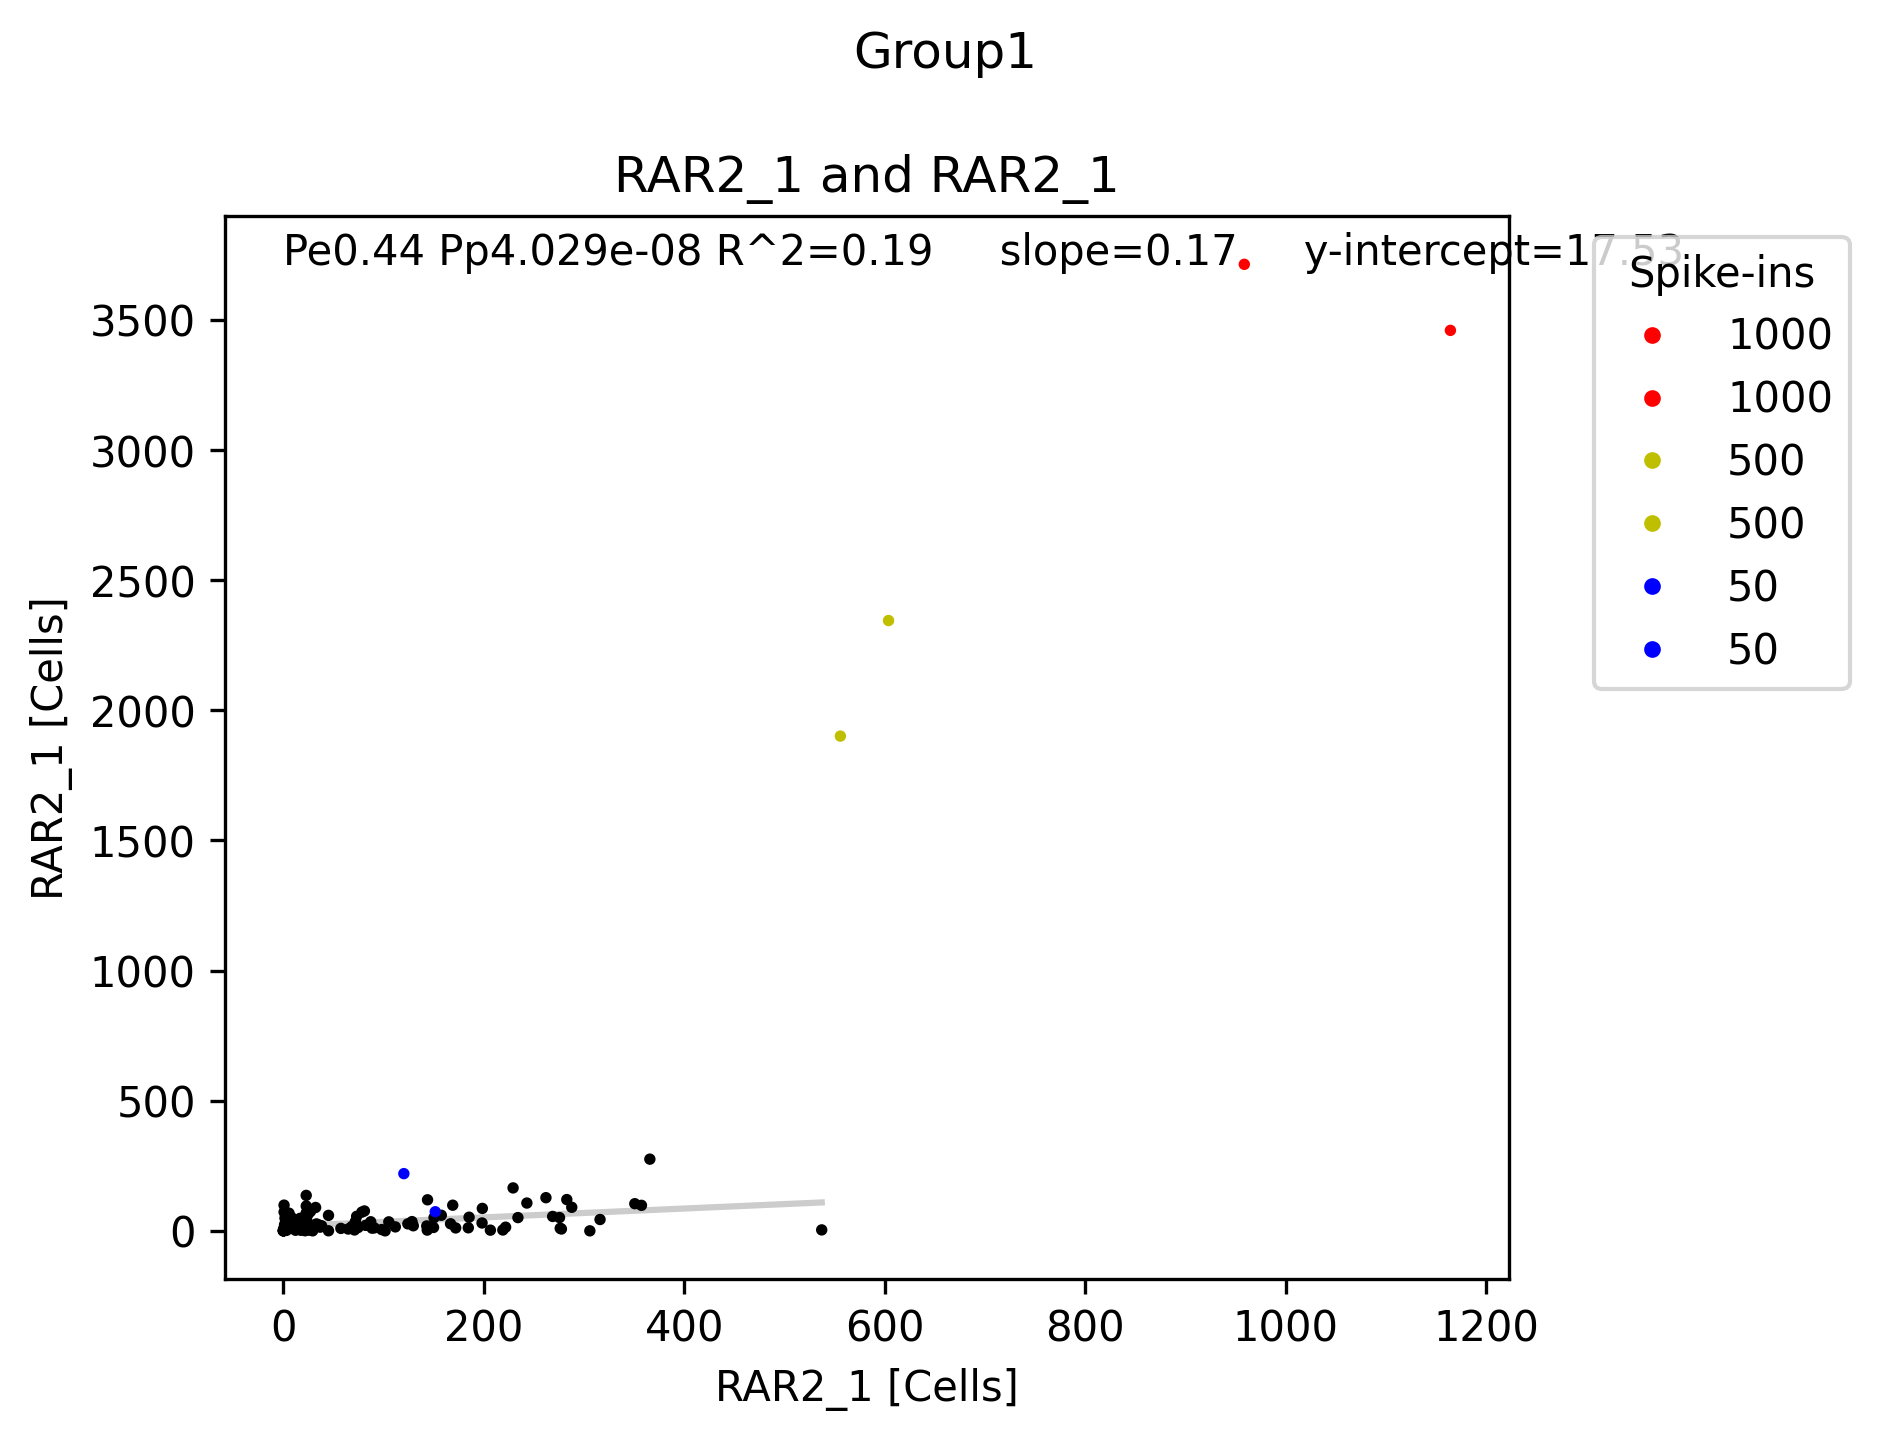

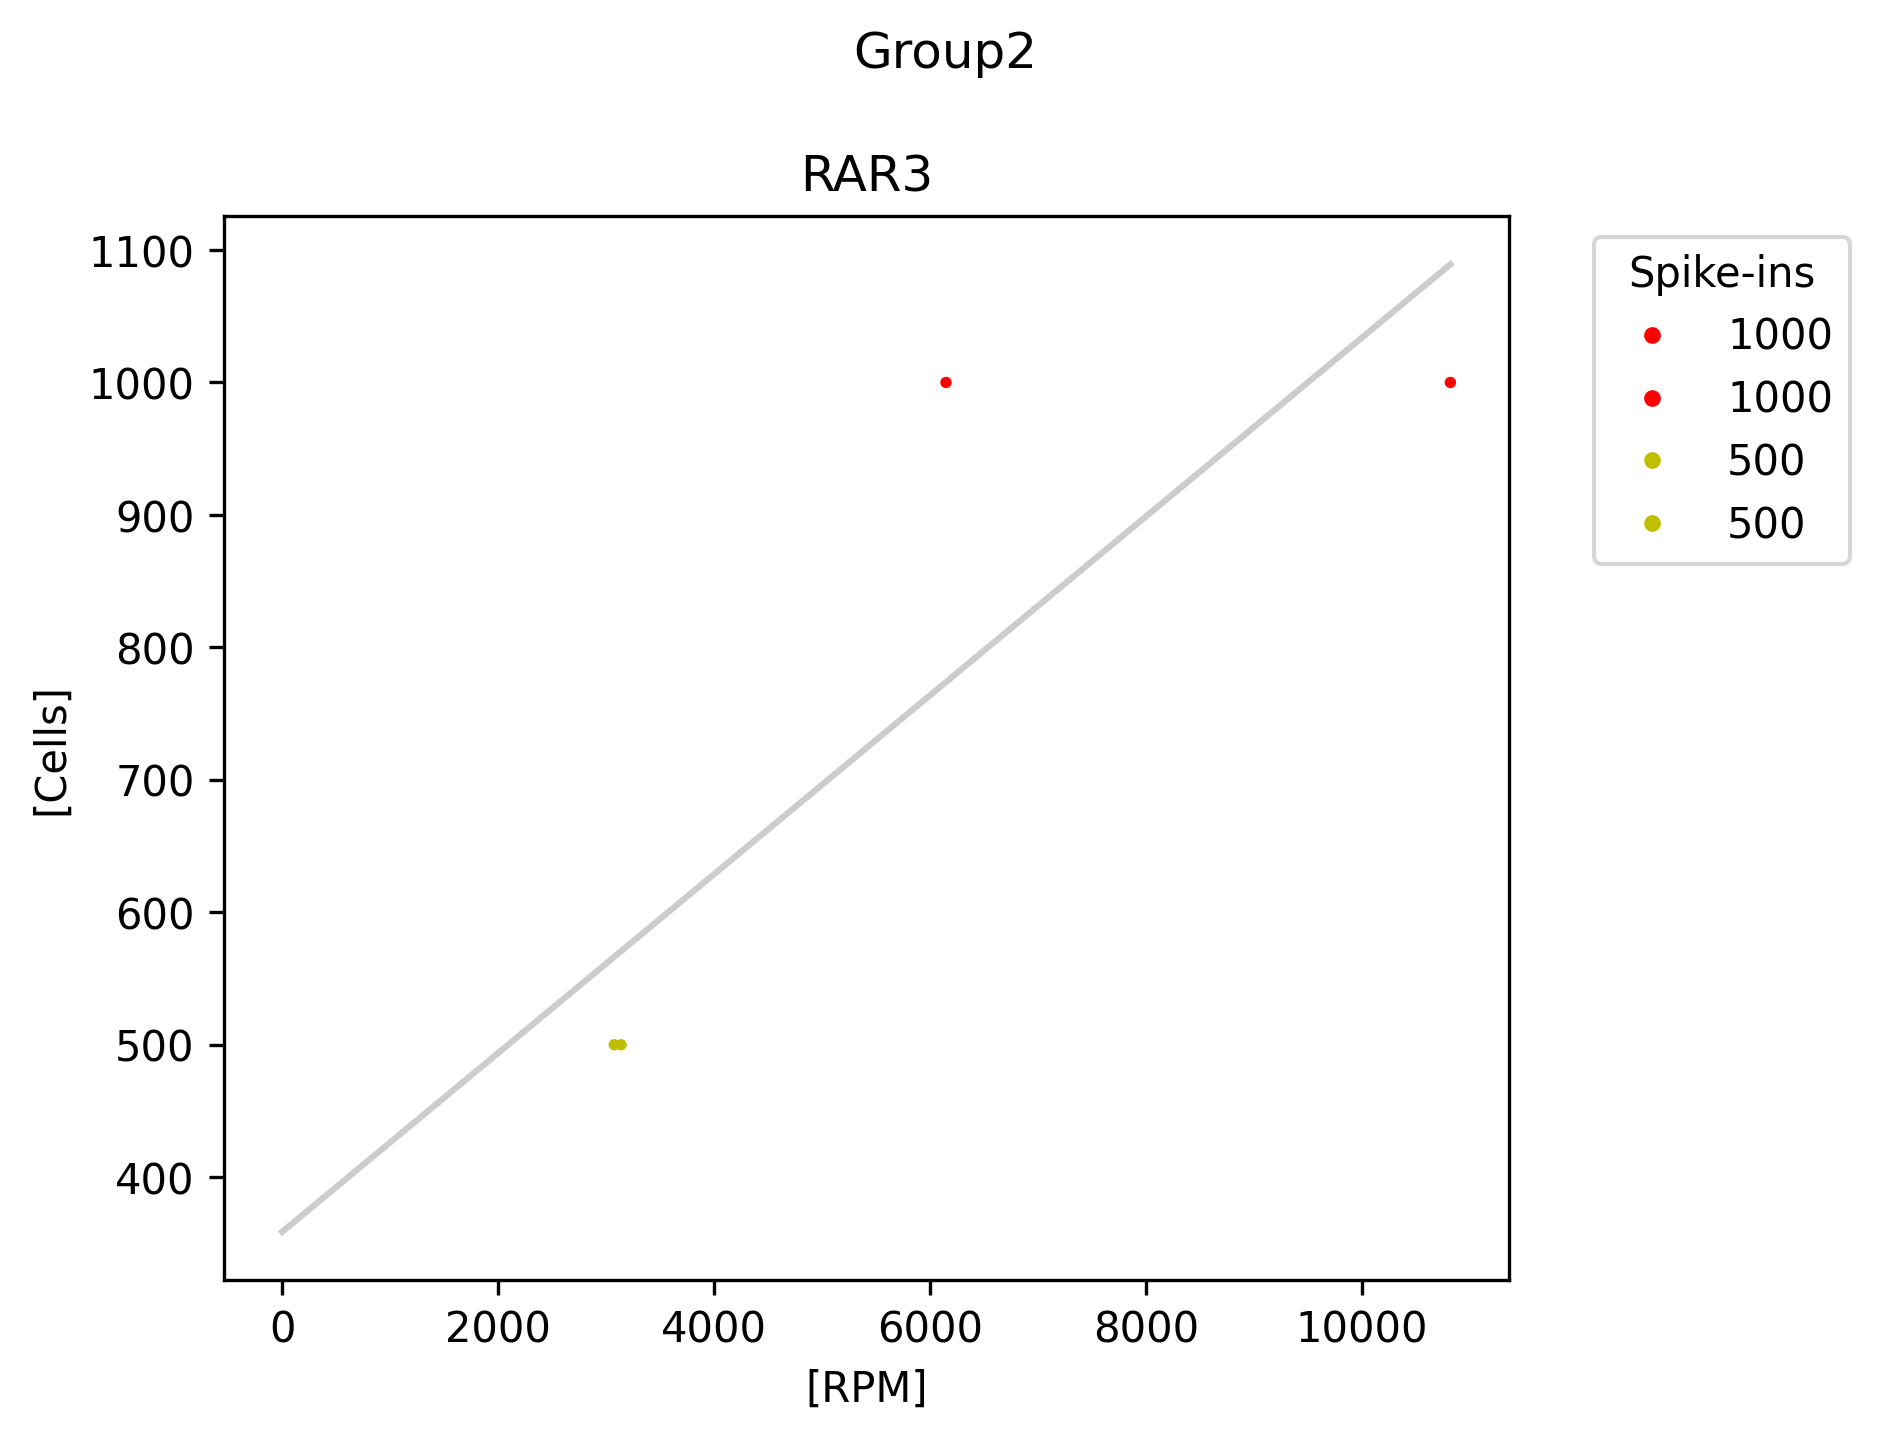

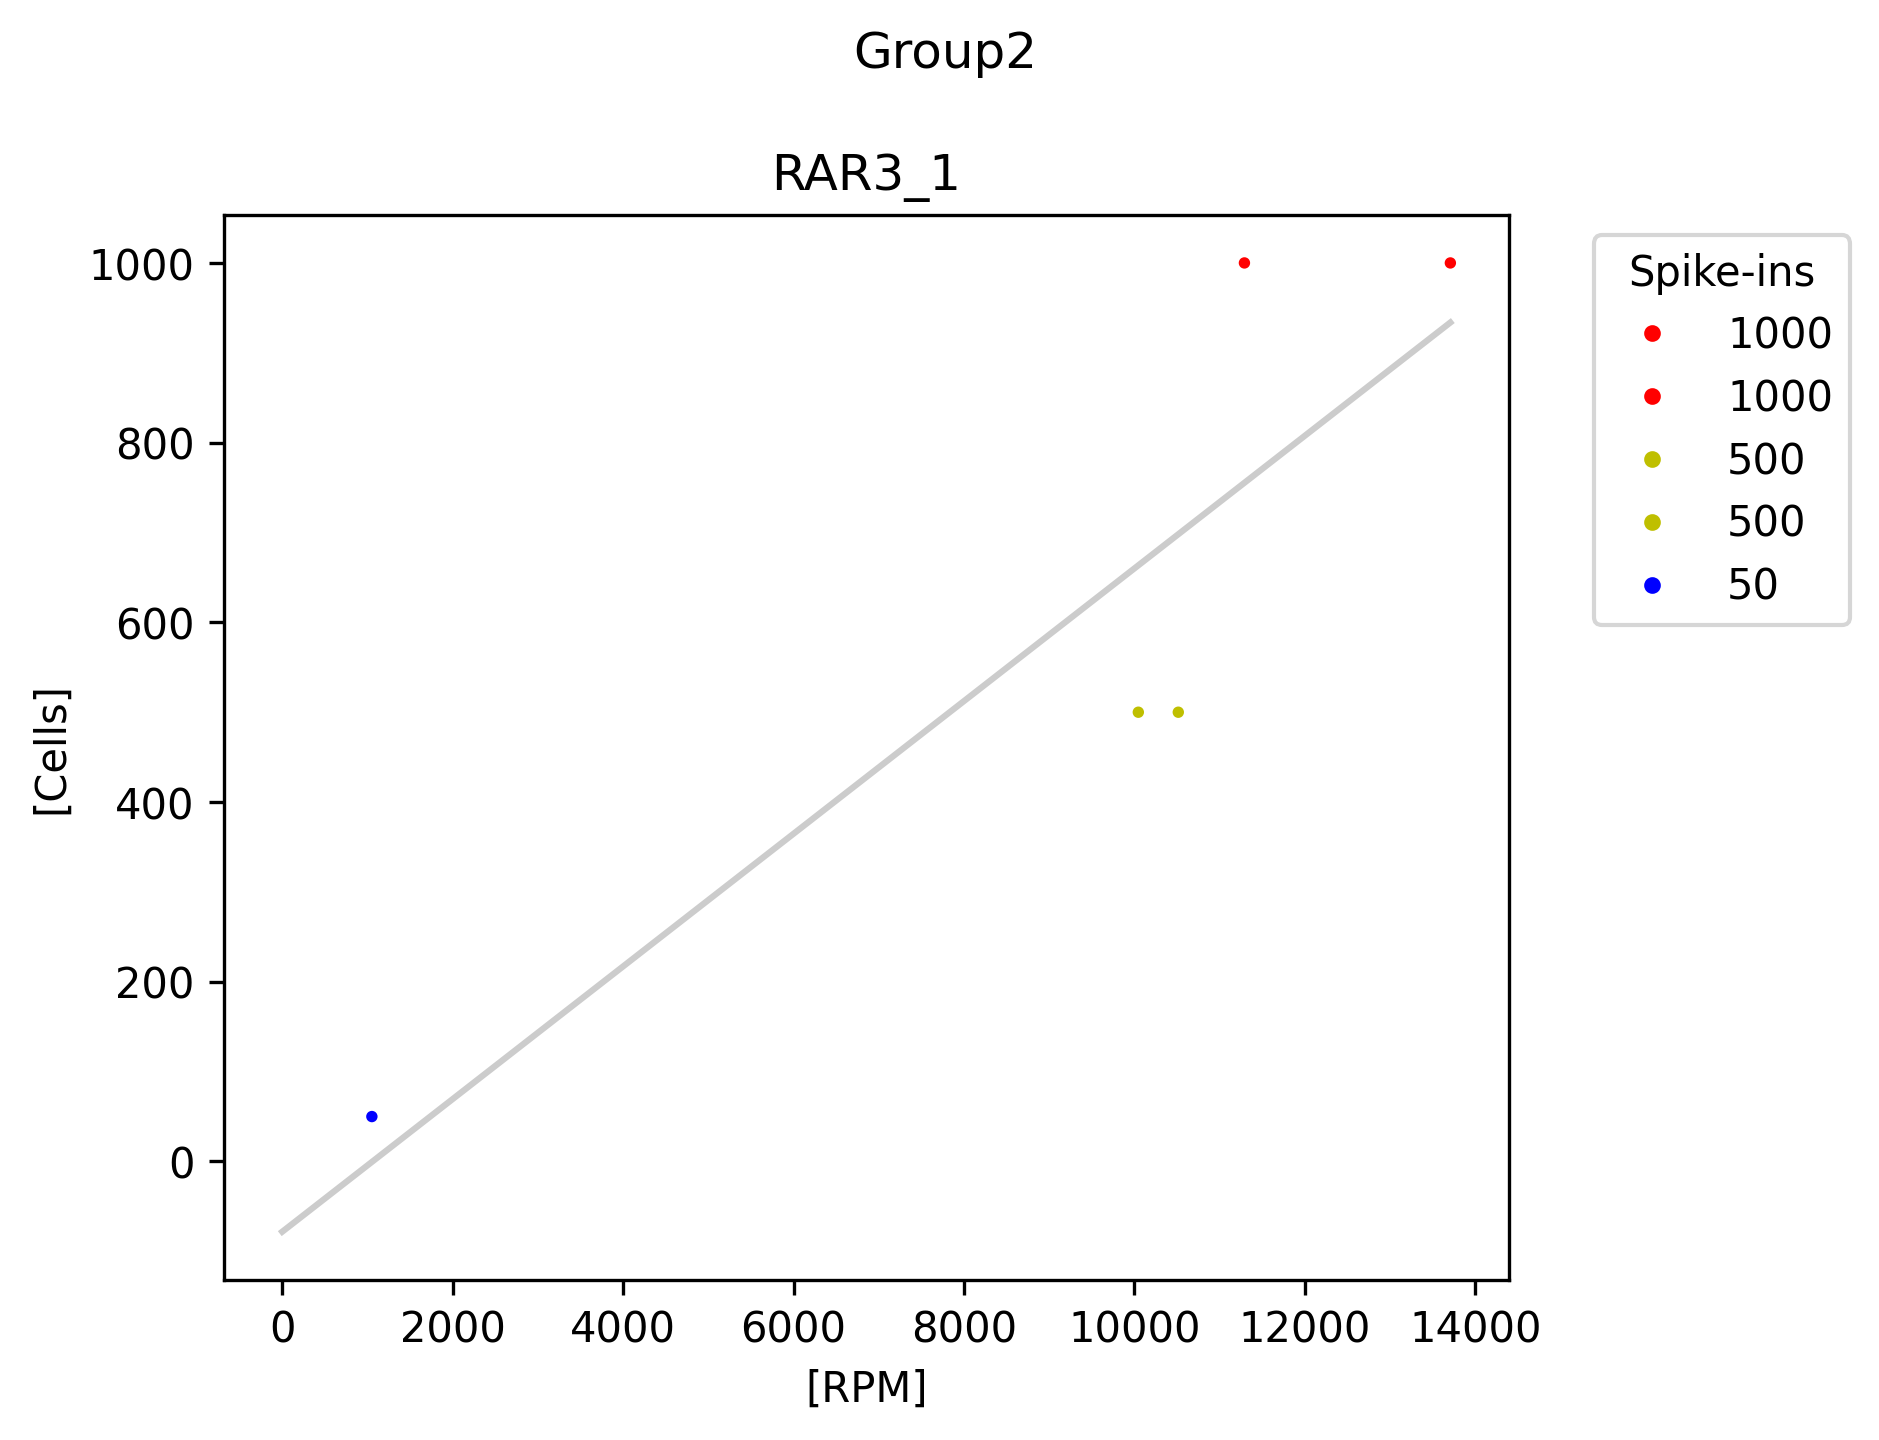

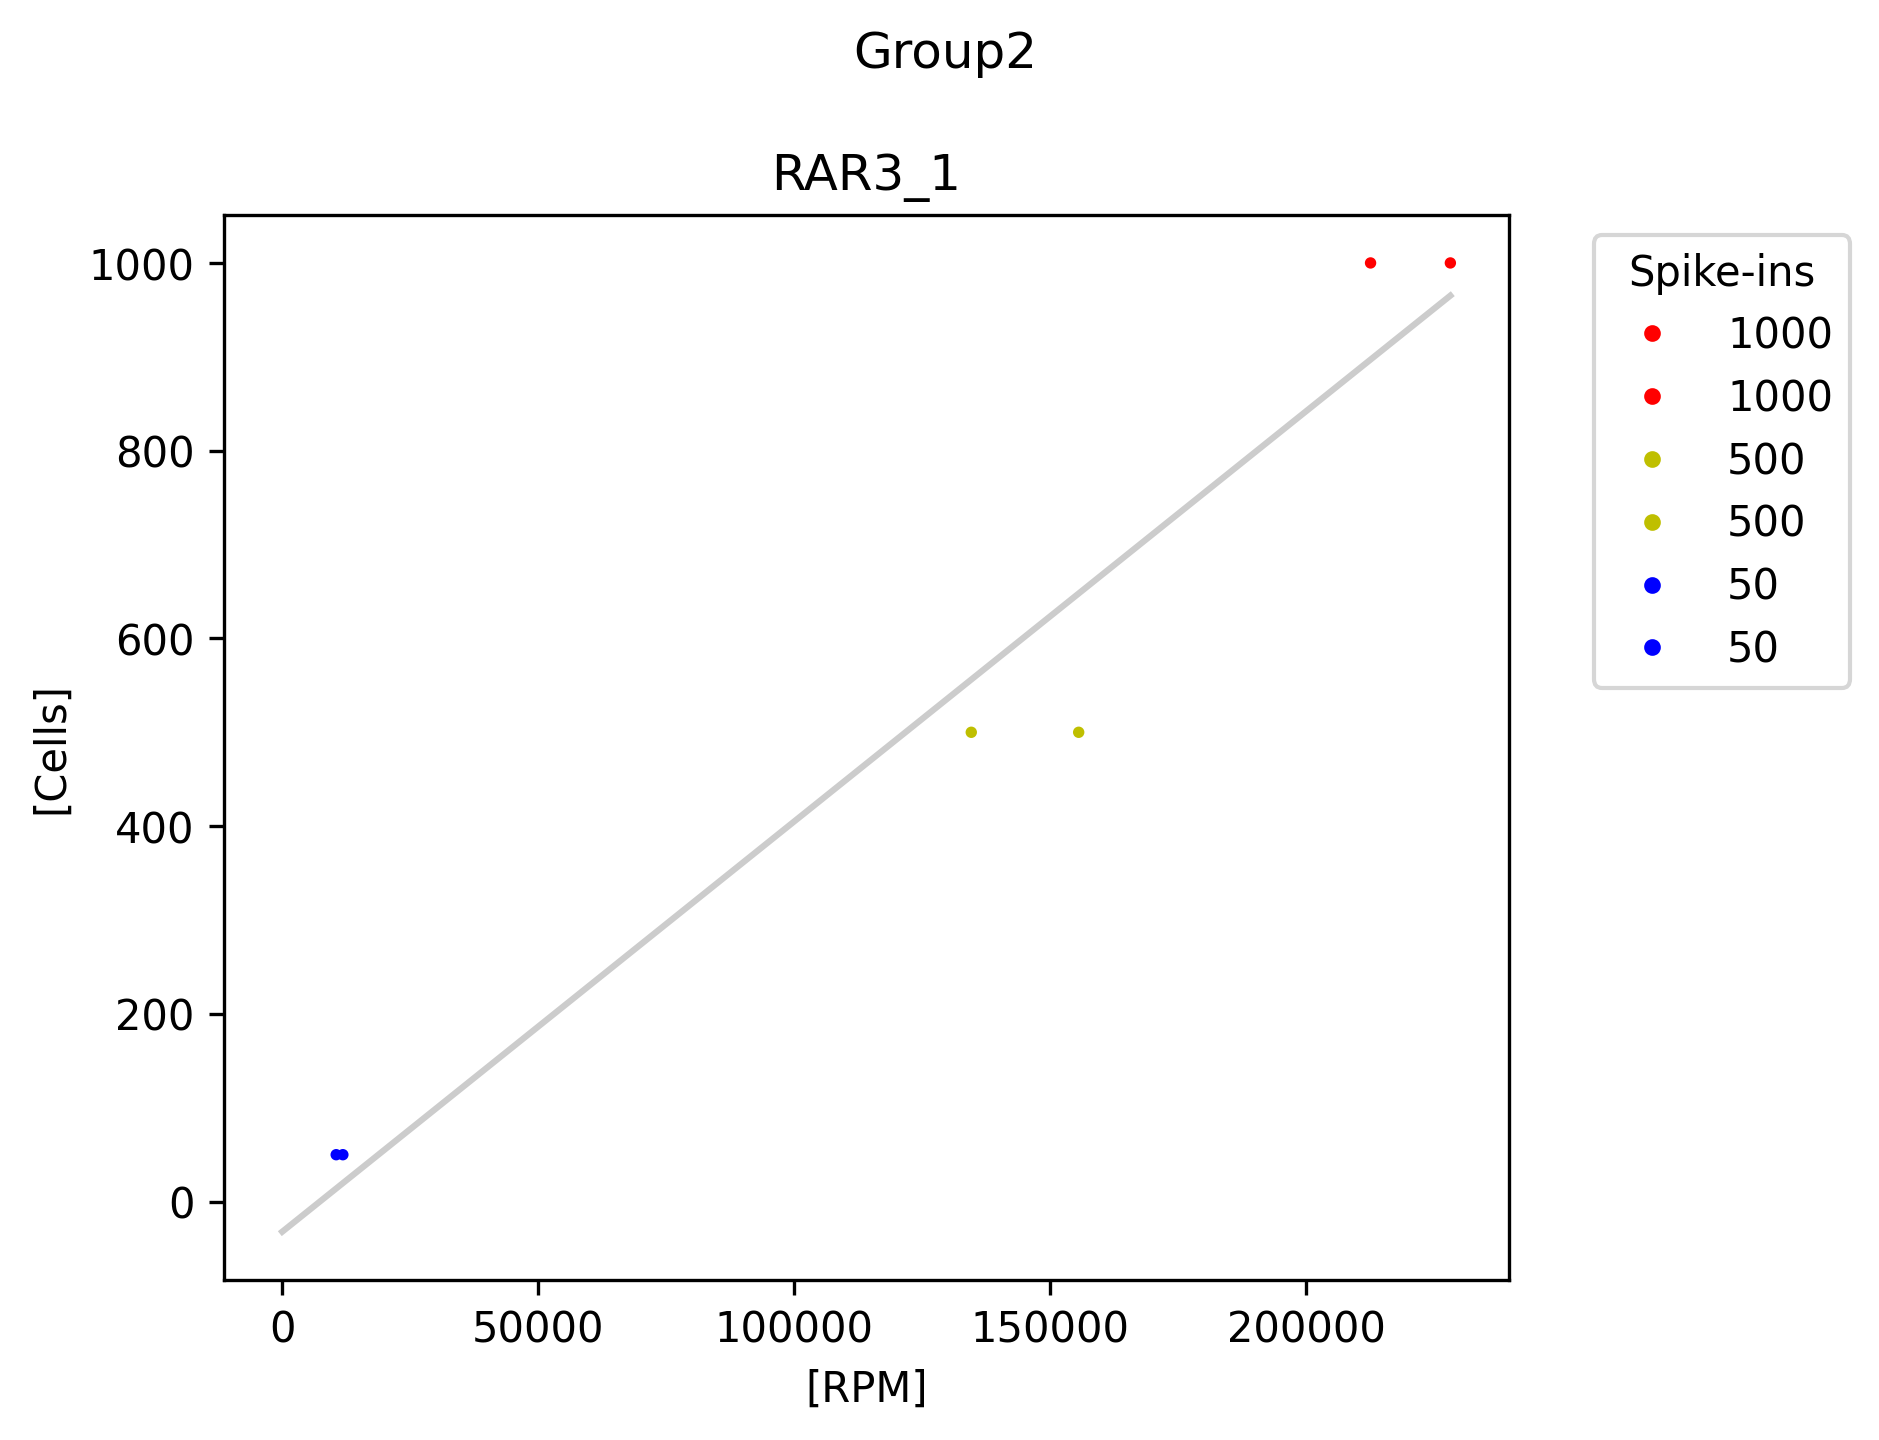

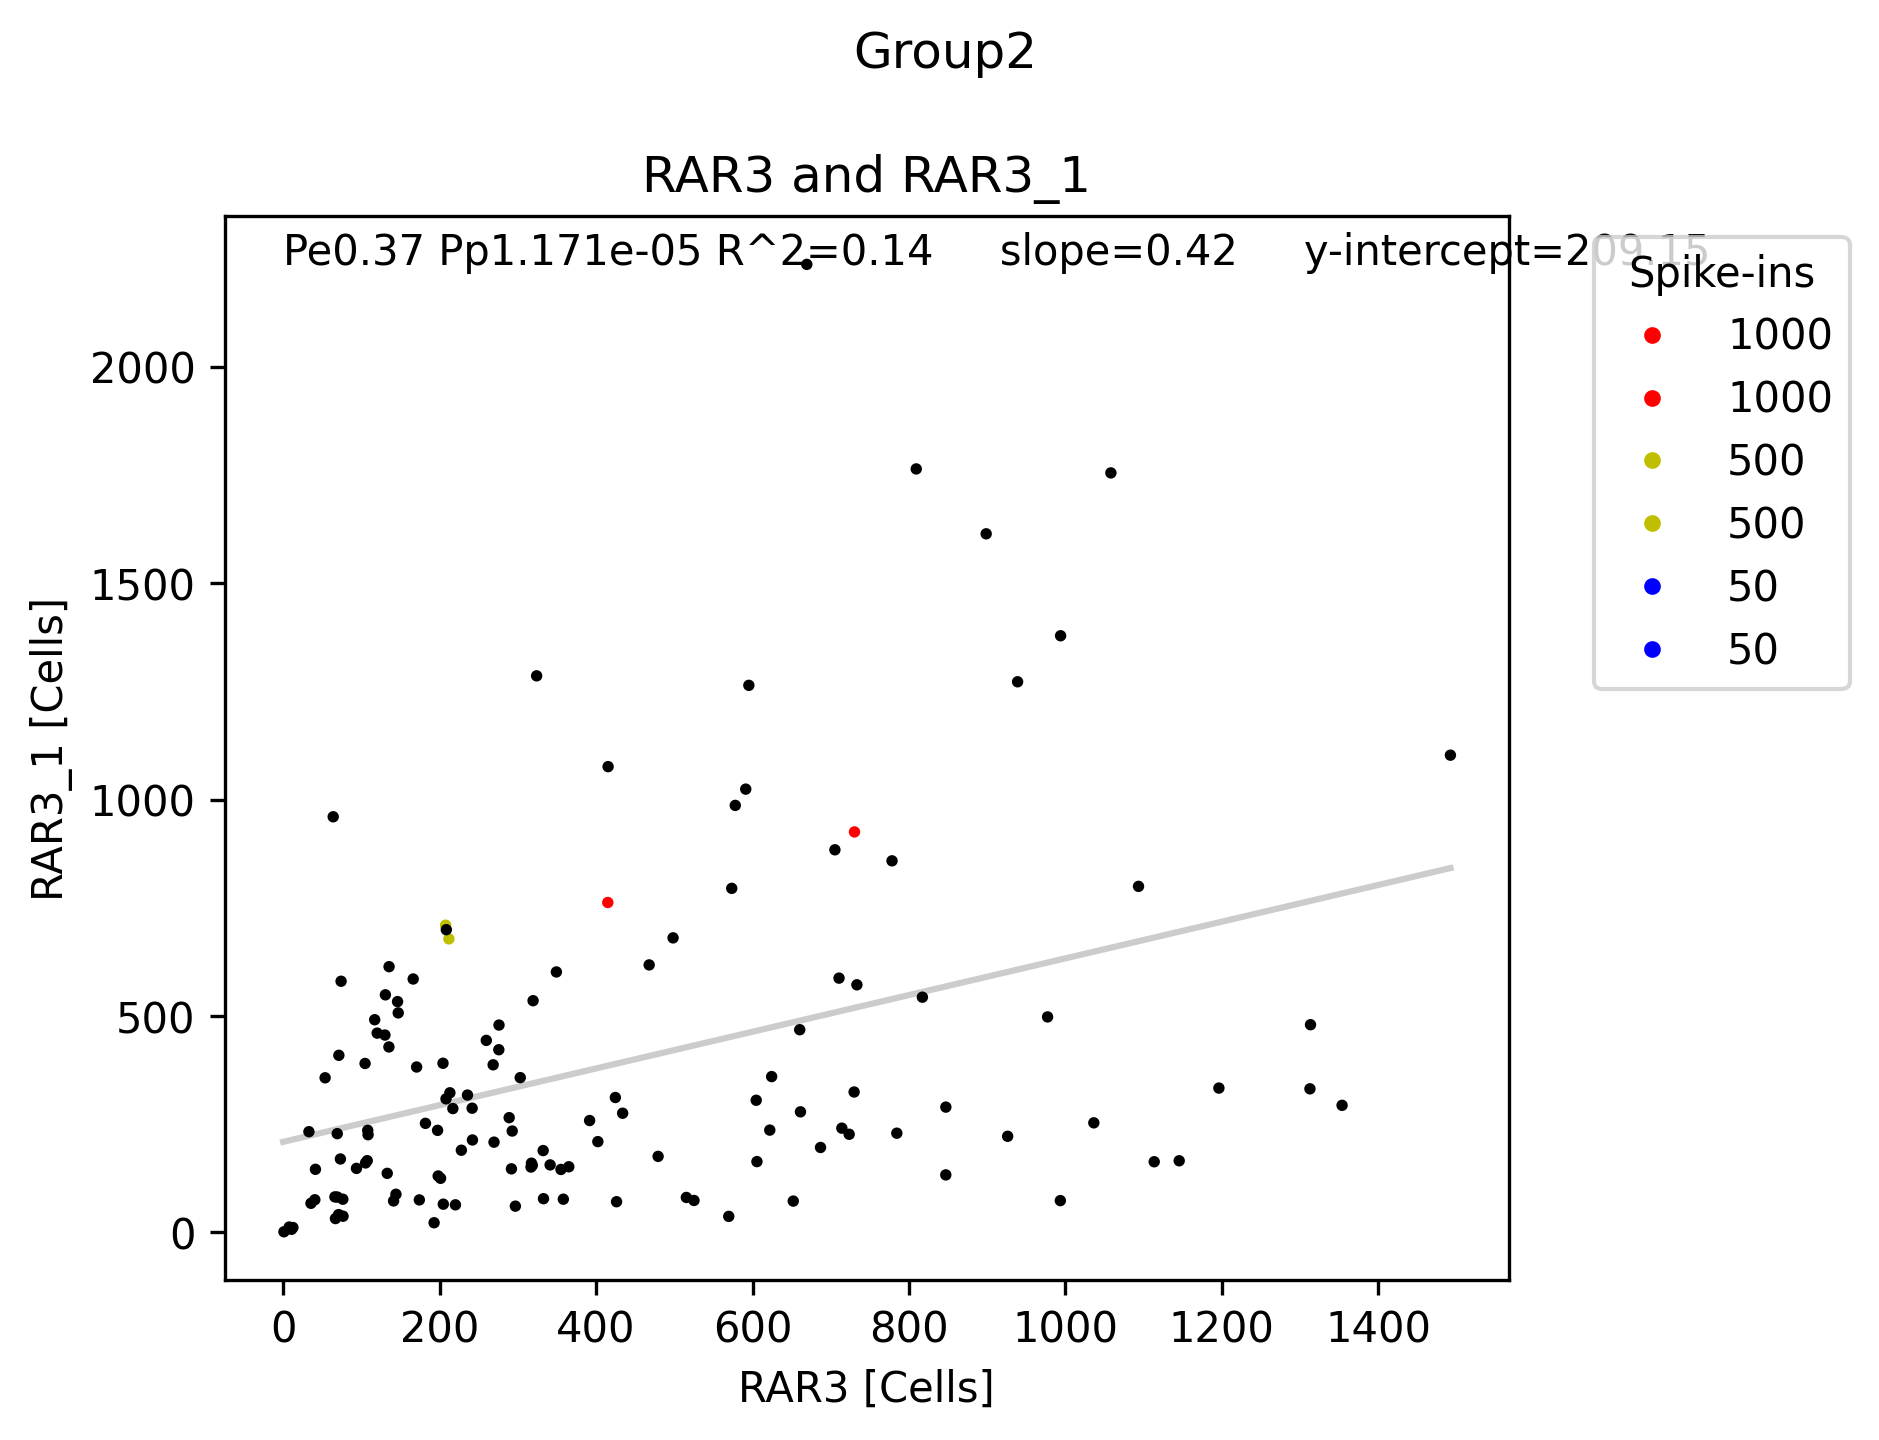

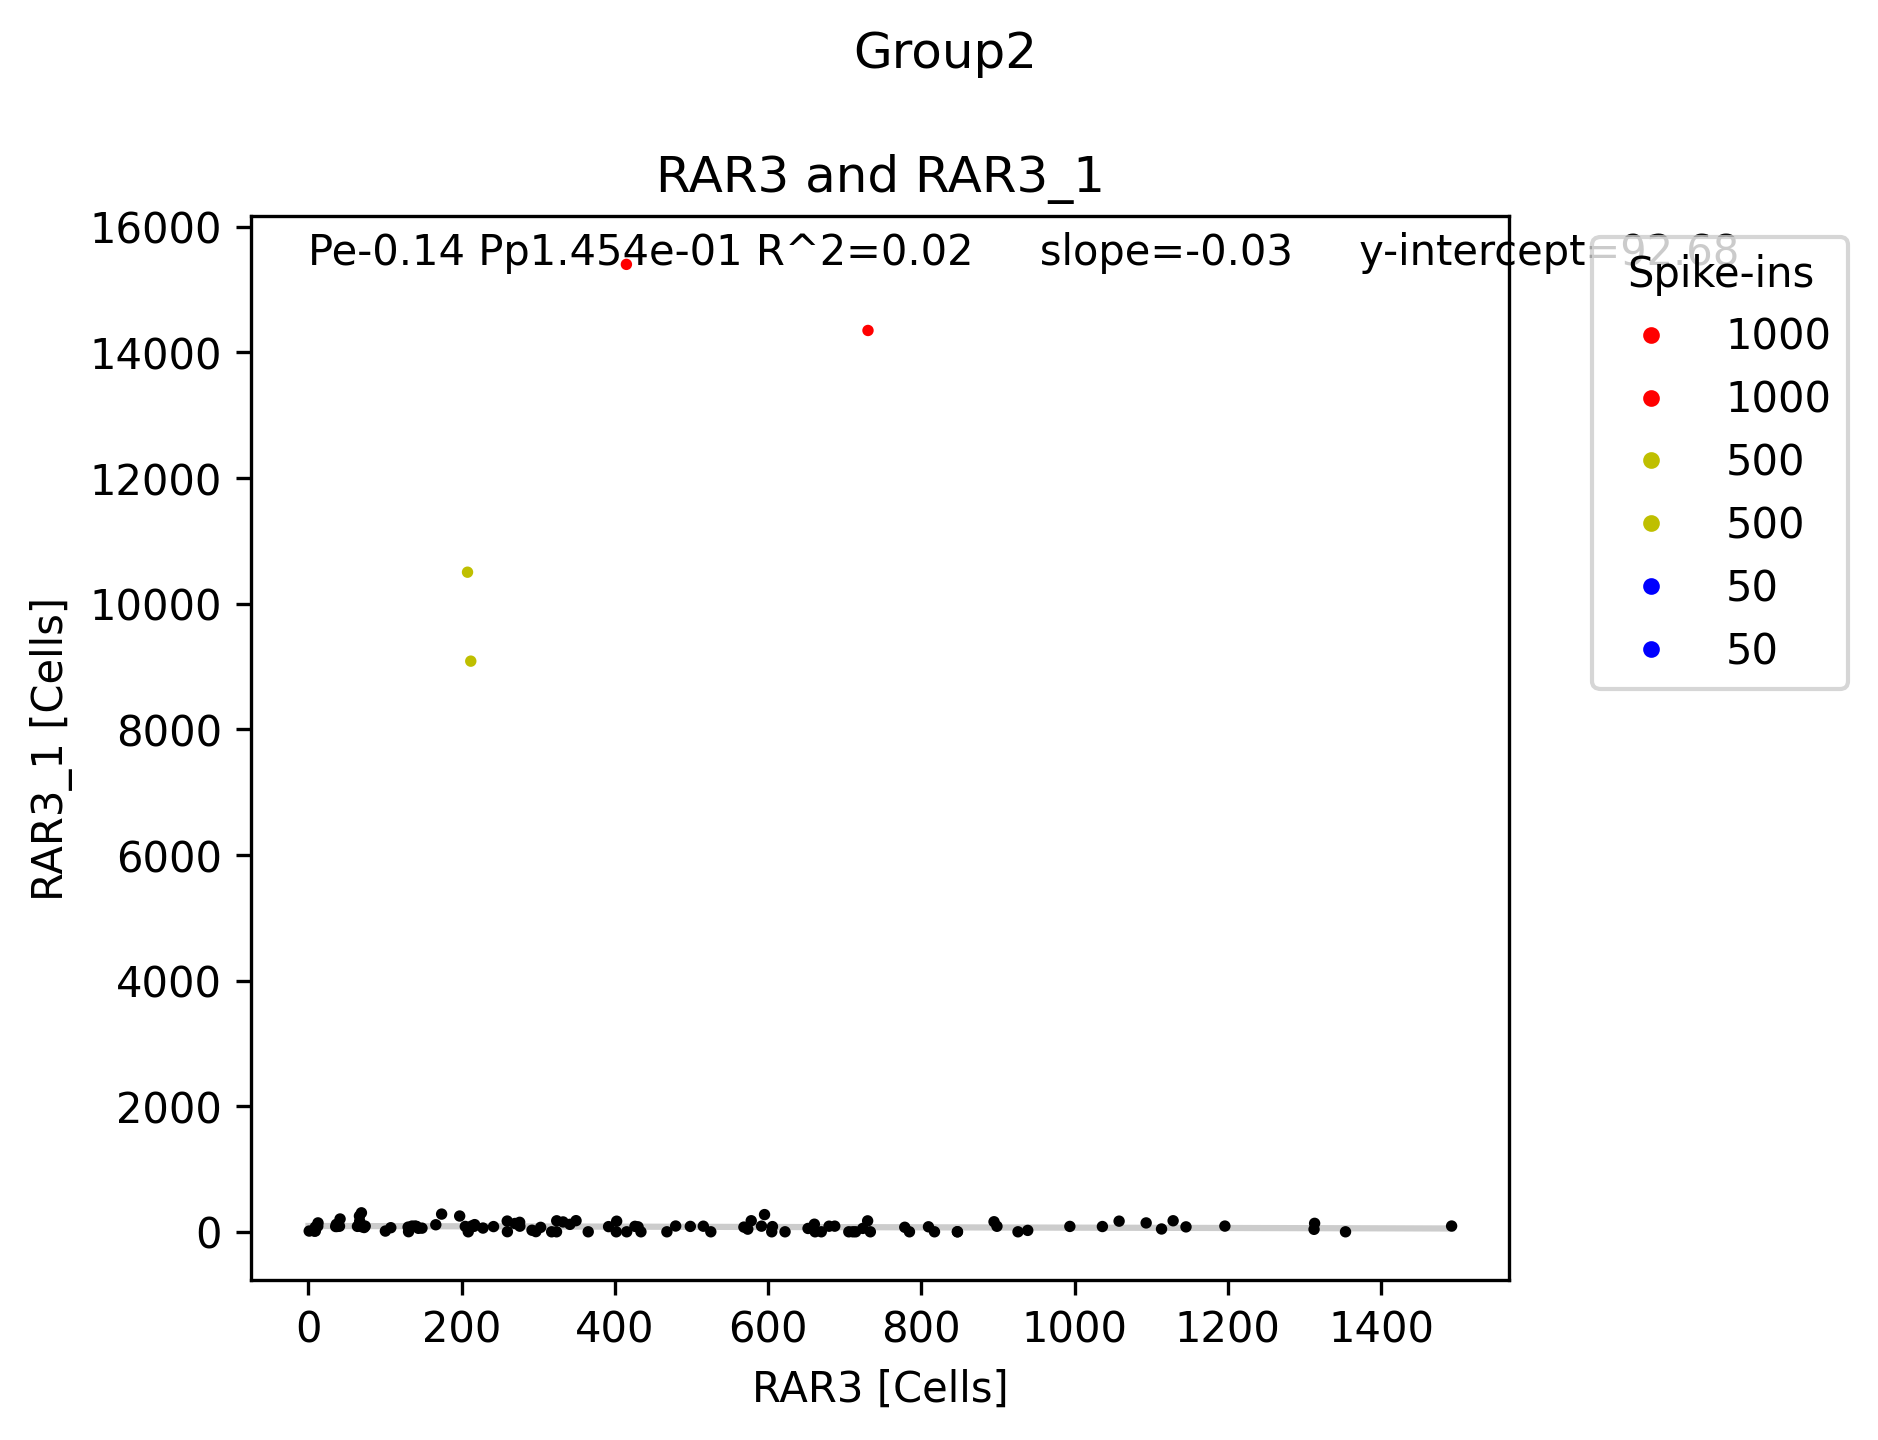

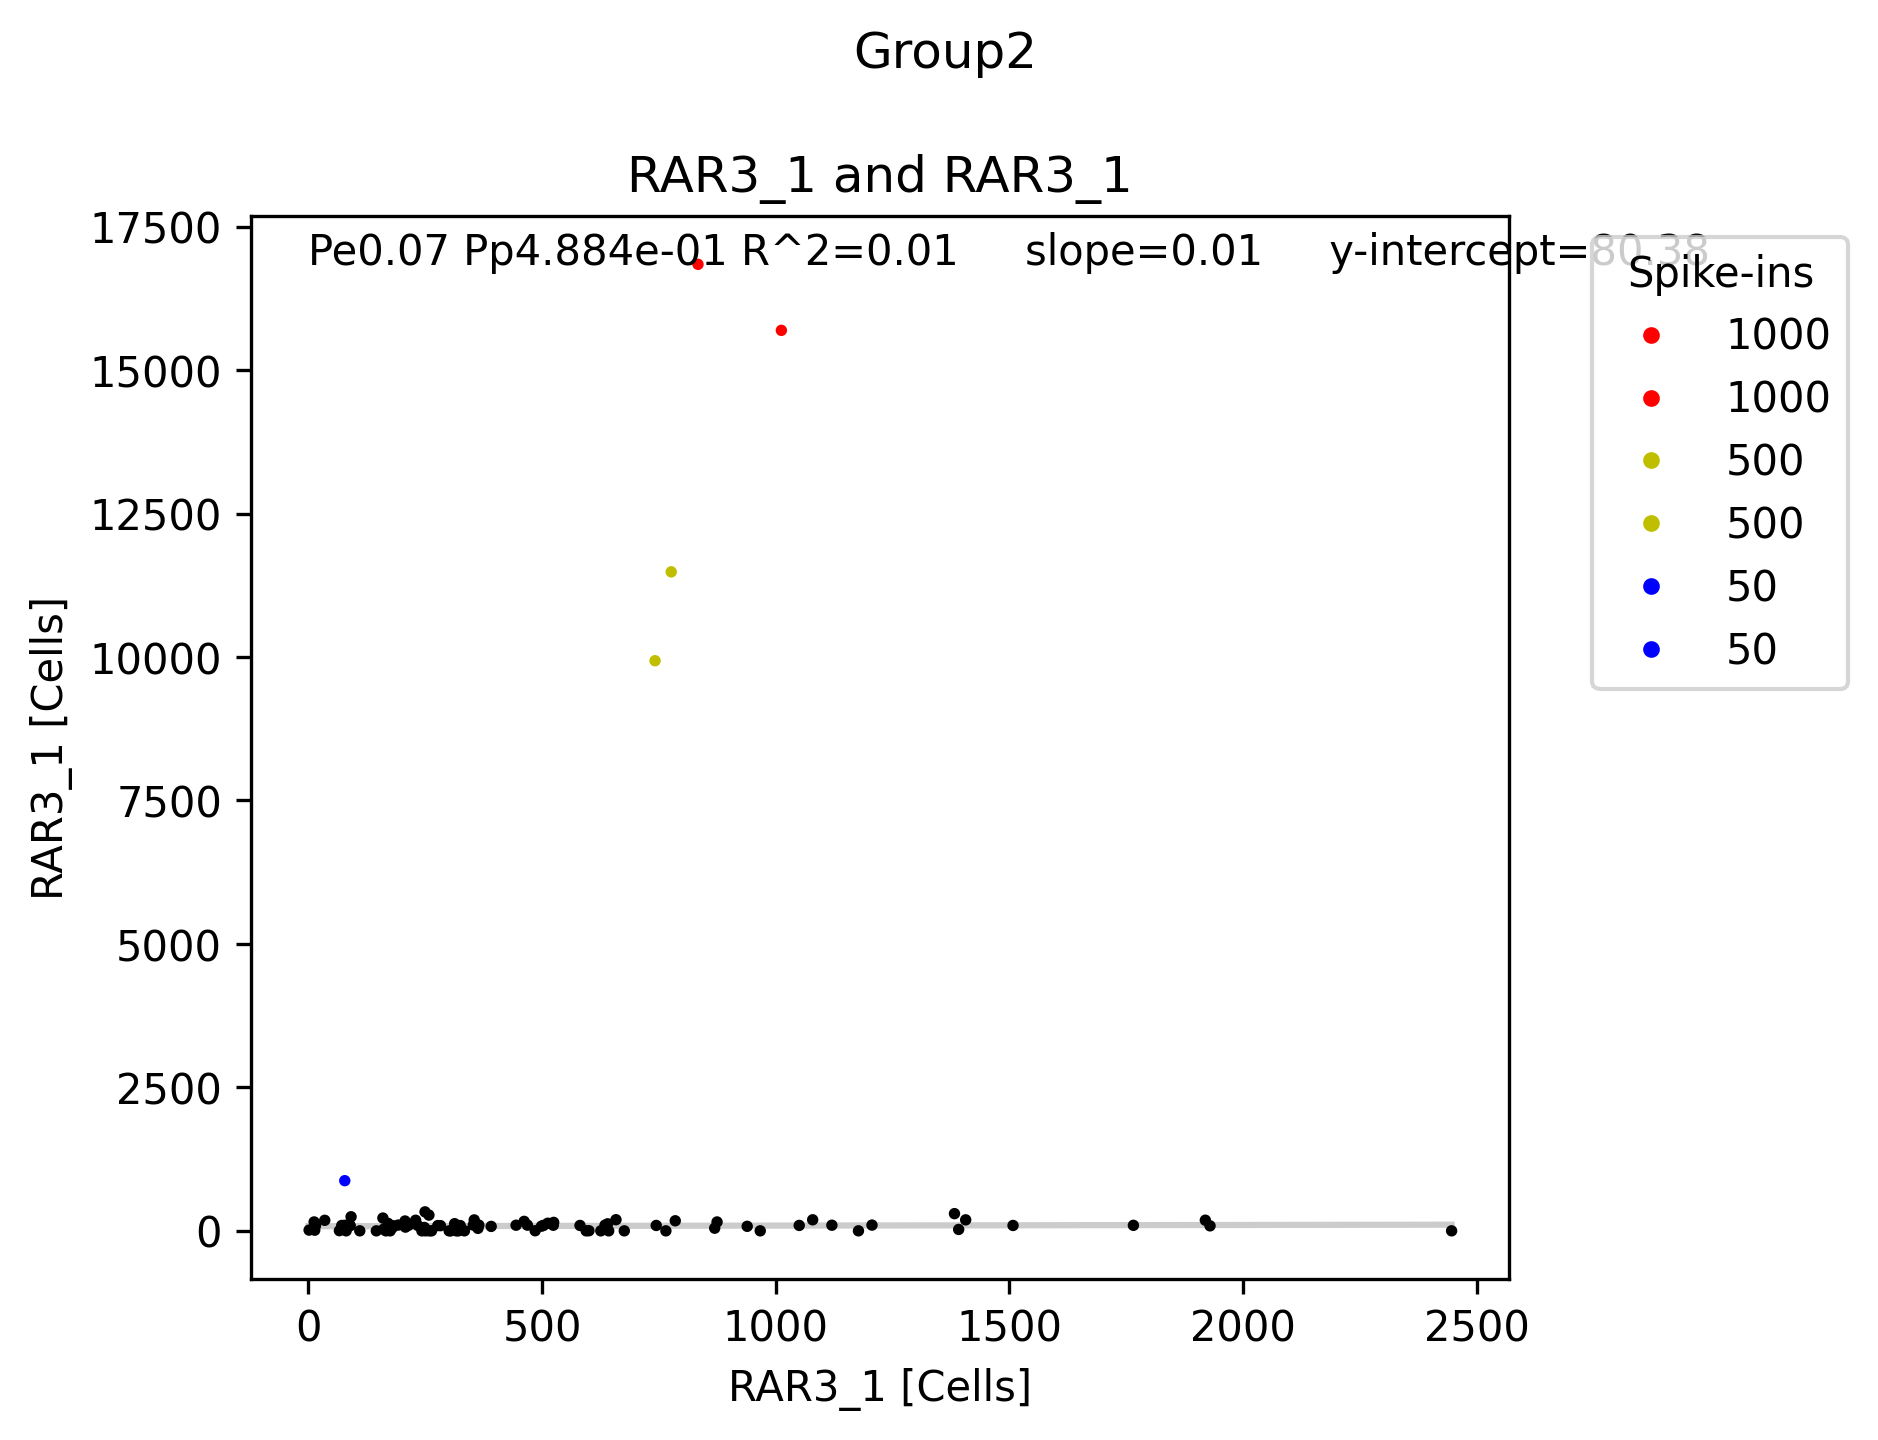

In [40]:
import pandas as pd
import itertools
GSAMP = [["RAR2","RAR2_1","RAR2_1"],["RAR3","RAR3_1","RAR3_1"]]
Outfolder = "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data_old/split_barcode/output"

barcode_quantify_folder =  Outfolder + "/barcode_quantify/"
path_to_feature_ref =      "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/20220110_gDNA_barcode/CellRanger_inputs/FeatureReference_filtered.csv"#Outfolder + "/CellRanger_inputs/" + "FeatureReference_filtered.csv" 
path_to_sc_output_files = "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/20220110_gDNA_barcode/starcode_outputs/sc_output_counts_*.txt"#Outfolder + "/starcode_outputs/sc_output_counts_*.txt"

spike_in_added = "yes"
spike_in_seqs =  ["TGGAGGTGAAGCTCCAGTTGCAGATCGACGACTAGGTCAAGATGAACTTCGAGCACTTGGACCTCCACGT",#//1000
                      "ATTCATGTTCTTGAAGGACATGATGGTGTTCTTGTACCTGTTGTACTACGACCTCATGATCGTCATCAAG",#//1000
                      "AGTTCGTCTACCTCATCTTGATGATGTTCAAGTAGGACGACGAGTAGCTCTACCAGGTGCAGATCGTGCA",#//500
                      "TGTAGATCTAGCTGATGTACGTGATCTTGGACATCTTCTTCATCCACCTCTTGATGAAGTACTACTTCAA",#//500
                      "ACCTGTAGATGTTCATGCTGTTCGAGTTGATGTTCTTGTTGCACAAGCACTACATGCTGTTGTACTTGGT",#//50
                      "ACCTCCTGGTGCTGTACATGCTCTAGATCTACGTGTTCTTGTAGCTCTTCGTGTACATGCTGGTGGAGAT"]#//5
        
spike_in_value = [1000,1000,500,500,50,50]

spike_in_color = ["r","r","y","y","b","b"]        
spike_in_for_pearson = []
data_pearson = []
data_pearson_P = []
counter = 0
for grp in GSAMP:

    counter += 1
    print("     group"+ str(counter) +' :')
    print(" ")
    path_to_group_folder = barcode_quantify_folder + "plots_group"+ str(counter) + "/"
    #os.mkdir(path_to_group_folder)


    #Load in Data
    filepath = barcode_quantify_folder  + '/FeatureReference_filtered_group'+ str(counter) + '_counts.csv'
    df_ref = pd.read_csv(filepath)

    #----------------------------Find and label spike ins------------------
    df_ref['spike_in_c'] = ['k']*len(df_ref.iloc[:,0])

    if spike_in_added == 'yes':
        for sp,spike_in_seq in enumerate(spike_in_seqs):
            df_ref.loc[df_ref['sequence'].str.match(spike_in_seq),'spike_in_c'] = spike_in_color[sp]


    #----------------------------Remove 0 and 1----------------------------
    print("         Removing zeros and ones")
    print(" ")

    df_plot = df_ref.iloc[:,-len(grp)-1:]

    df_plot = df_plot.replace(0, np.nan, regex=True)
    df_plot = df_plot.replace(1, np.nan, regex=True)

    #----------------------------Reads per million--------------------------
    for i in range(len(grp)):
        df_plot.iloc[:,i] = rpm_norm(df_plot.iloc[:,i])

    #-------------------------Get all combinations--------------------------
    all_combinations = itertools.combinations([g for g in range(len(grp))],2)

    print("             Plot:")
    #Keep Spike-ins color
    all_spike_in_color_in_grp = []
    all_spike_in_value_in_grp = []
    all_line_fit = []
    summary_spike_in = []
    
    for i in range(len(grp)):

        print("                   Spike - "  + grp[i])
        plot_f = plt.figure()

        y = df_plot.iloc[:,i] 
        col_y = df_plot.iloc[:,-1]

        new_y =[]
        new_col_y =[]

        for n,m in enumerate(col_y):
            if m in spike_in_color:
                #Clean up any possibly lost barcodes
                if np.isnan(y[n]) == False:
                    new_y.append(y[n])
                    new_col_y.append(m)
        summary_spike_in.append(len(new_col_y))

        #Make the order of spike-ins found the same as the spike_in_values
        x = new_col_y
        test_list = list(zip( x,range(len(x))))
        sort_order = spike_in_color # initializing sort order
        test_list.sort(key = lambda i: sort_order.index(i[0])) 

        new_y = [new_y[a] for _,a in test_list]

        #Remove colors that had a nan
        new_spike_in_color = []
        new_spike_in_value = []
        remove_new_col_y = new_col_y
        for c,col in enumerate(spike_in_color):
            if col in remove_new_col_y:
                remove_new_col_y.remove(col)

                new_spike_in_color.append(col)
                new_spike_in_value.append(spike_in_value[c])

        #Fit line
        m, b = np.polyfit(new_y,new_spike_in_value, 1)

        all_line_fit.append([m,b])

        x_line = np.linspace(0, max(new_y), 2)
        y_line = [k*m+b for k in x_line]


        #Plot
        scatt = plt.scatter(new_y,new_spike_in_value, s=3, c=new_spike_in_color)

        plt.suptitle('Group'+ str(counter), y=0.99);
        plt.title(grp[i])
        plt.xlabel('[RPM]')
        plt.ylabel('[Cells]')
        plt.plot(x_line,y_line,'-',color = 'k', alpha=0.2)


        for c,cop in enumerate(new_spike_in_color):
            plt.plot([], [], '.'+cop, label=new_spike_in_value[c])
        plt.legend(title="Spike-ins",bbox_to_anchor=(1.05, 1.0), loc='upper left')

        plt.tight_layout()

        all_spike_in_color_in_grp.append(new_spike_in_color)
        all_spike_in_value_in_grp.append(new_spike_in_value)
        spike_in_for_pearson.append(new_y)
        
    print("             ")
    for combination in all_combinations:

            print("                   Scatt - " + grp[combination[0]] + " and " + grp[combination[1]])
            plot_f = plt.figure()

            x = df_plot.iloc[:,combination[0]] 
            y = df_plot.iloc[:,combination[1]] 
            col_y = df_plot.iloc[:,-1]

            if spike_in_added == 'yes':
                #Convert from RPM to Cells
                m_x,b_x = all_line_fit[combination[0]]
                x = rpm_to_cells(m_x,0,x)

                m_y,b_y = all_line_fit[combination[0]]
                y = rpm_to_cells(m_y,0,y)

            
            new_x =[]
            new_y =[]
            no_pike_x = []
            no_pike_y = []
            new_col_y =[]
            for i,m in enumerate(x):
                if np.isnan(m) == False:
                    if np.isnan(y[i]) == False:


                        new_x.append(m)
                        new_y.append(y[i])
                        new_col_y.append(col_y[i])

                        if col_y[i] == 'k':    # without spike in
                            no_pike_x.append(m)
                            no_pike_y.append(y[i])

            # fit line and get r^2
            slope, intercept, r_squared = get_r2_numpy(np.array(no_pike_x), np.array(no_pike_y) ) 
            data_pearson.append(stats.pearsonr(np.array(no_pike_x), np.array(no_pike_y))[0])
            data_pearson_P.append(stats.pearsonr(np.array(no_pike_x), np.array(no_pike_y))[1])
            print(combination)
            

            x_fit = [0,max(no_pike_x)]
            y_fit =[k*slope +intercept for k in x_fit]

            #Plot
            plt.scatter(new_x,new_y, s=3, c=new_col_y)
            plt.plot(x_fit,y_fit,'-',color = 'k', alpha=0.2)
            plt.suptitle('Group'+ str(counter), y=0.99);
            plt.title(grp[combination[0]] + " and " + grp[combination[1]])

            w = stats.pearsonr(np.array(no_pike_x), np.array(no_pike_y))[0]
            wp = stats.pearsonr(np.array(no_pike_x), np.array(no_pike_y))[1]
            fit_name = "Pe" +"{:.2f}".format(w) + " Pp"+ "{:.3e}".format(wp) + " R^2=" +"{:.2f}".format(r_squared) + "     slope=" + "{:.2f}".format(slope)+ "     y-intercept=" + "{:.2f}".format(intercept)

            plt.text(0,np.max(new_y),fit_name)

            if spike_in_added == 'yes':
                plt.xlabel(grp[combination[0]] + ' [Cells]')
                plt.ylabel(grp[combination[1]] + ' [Cells]')
                for c,cop in enumerate(spike_in_color ):
                    plt.plot([], [], '.'+cop, label=spike_in_value[c])
                plt.legend(title="Spike-ins",bbox_to_anchor=(1.05, 1.0), loc='upper left')
            else:
                plt.xlabel(grp[combination[0]] + ' [RPM]')
                plt.ylabel(grp[combination[1]] + ' [RPM]')

            plt.tight_layout()
            
            



    

In [42]:
data_pearson,data_pearson_P

([0.5115209968004694,
  0.8279322640382631,
  0.4379584274650614,
  0.37263084865852597,
  -0.1410410112350567,
  0.07194122717154736],
 [4.273765661788751e-10,
  6.00043809771296e-34,
  4.0294538855529445e-08,
  1.1705786056043016e-05,
  0.14539970402366062,
  0.4884274112649118])

     group1 :
 
         Removing zeros and ones
 
             Plot:
                   Spike - RAR2
0.990265256980804
0.00014168657493471483
                   Spike - RAR2_1
0.9869469272034752
0.0002544620551923248
                   Spike - RAR2_1
0.9874138678089897
0.00023661919614097182
             
                   Scatt - RAR2 and RAR2_1
(0, 1)
                   Scatt - RAR2 and RAR2_1
(0, 2)
                   Scatt - RAR2_1 and RAR2_1
(1, 2)
     group2 :
 
         Removing zeros and ones
 
             Plot:
                   Spike - RAR3
0.8520215297070242
0.14797847029297584
                   Spike - RAR3_1
0.8906455310598627
0.042690723298090656
                   Spike - RAR3_1
0.9781475326777745
0.0007110778841586409
             
                   Scatt - RAR3 and RAR3_1
(0, 1)
                   Scatt - RAR3 and RAR3_1
(0, 2)


/var/folders/hs/3dbj5ws97_z0vv2zh1fbrjj40000gr/T/ipykernel_98129/55537299.py:216: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


                   Scatt - RAR3_1 and RAR3_1
(1, 2)


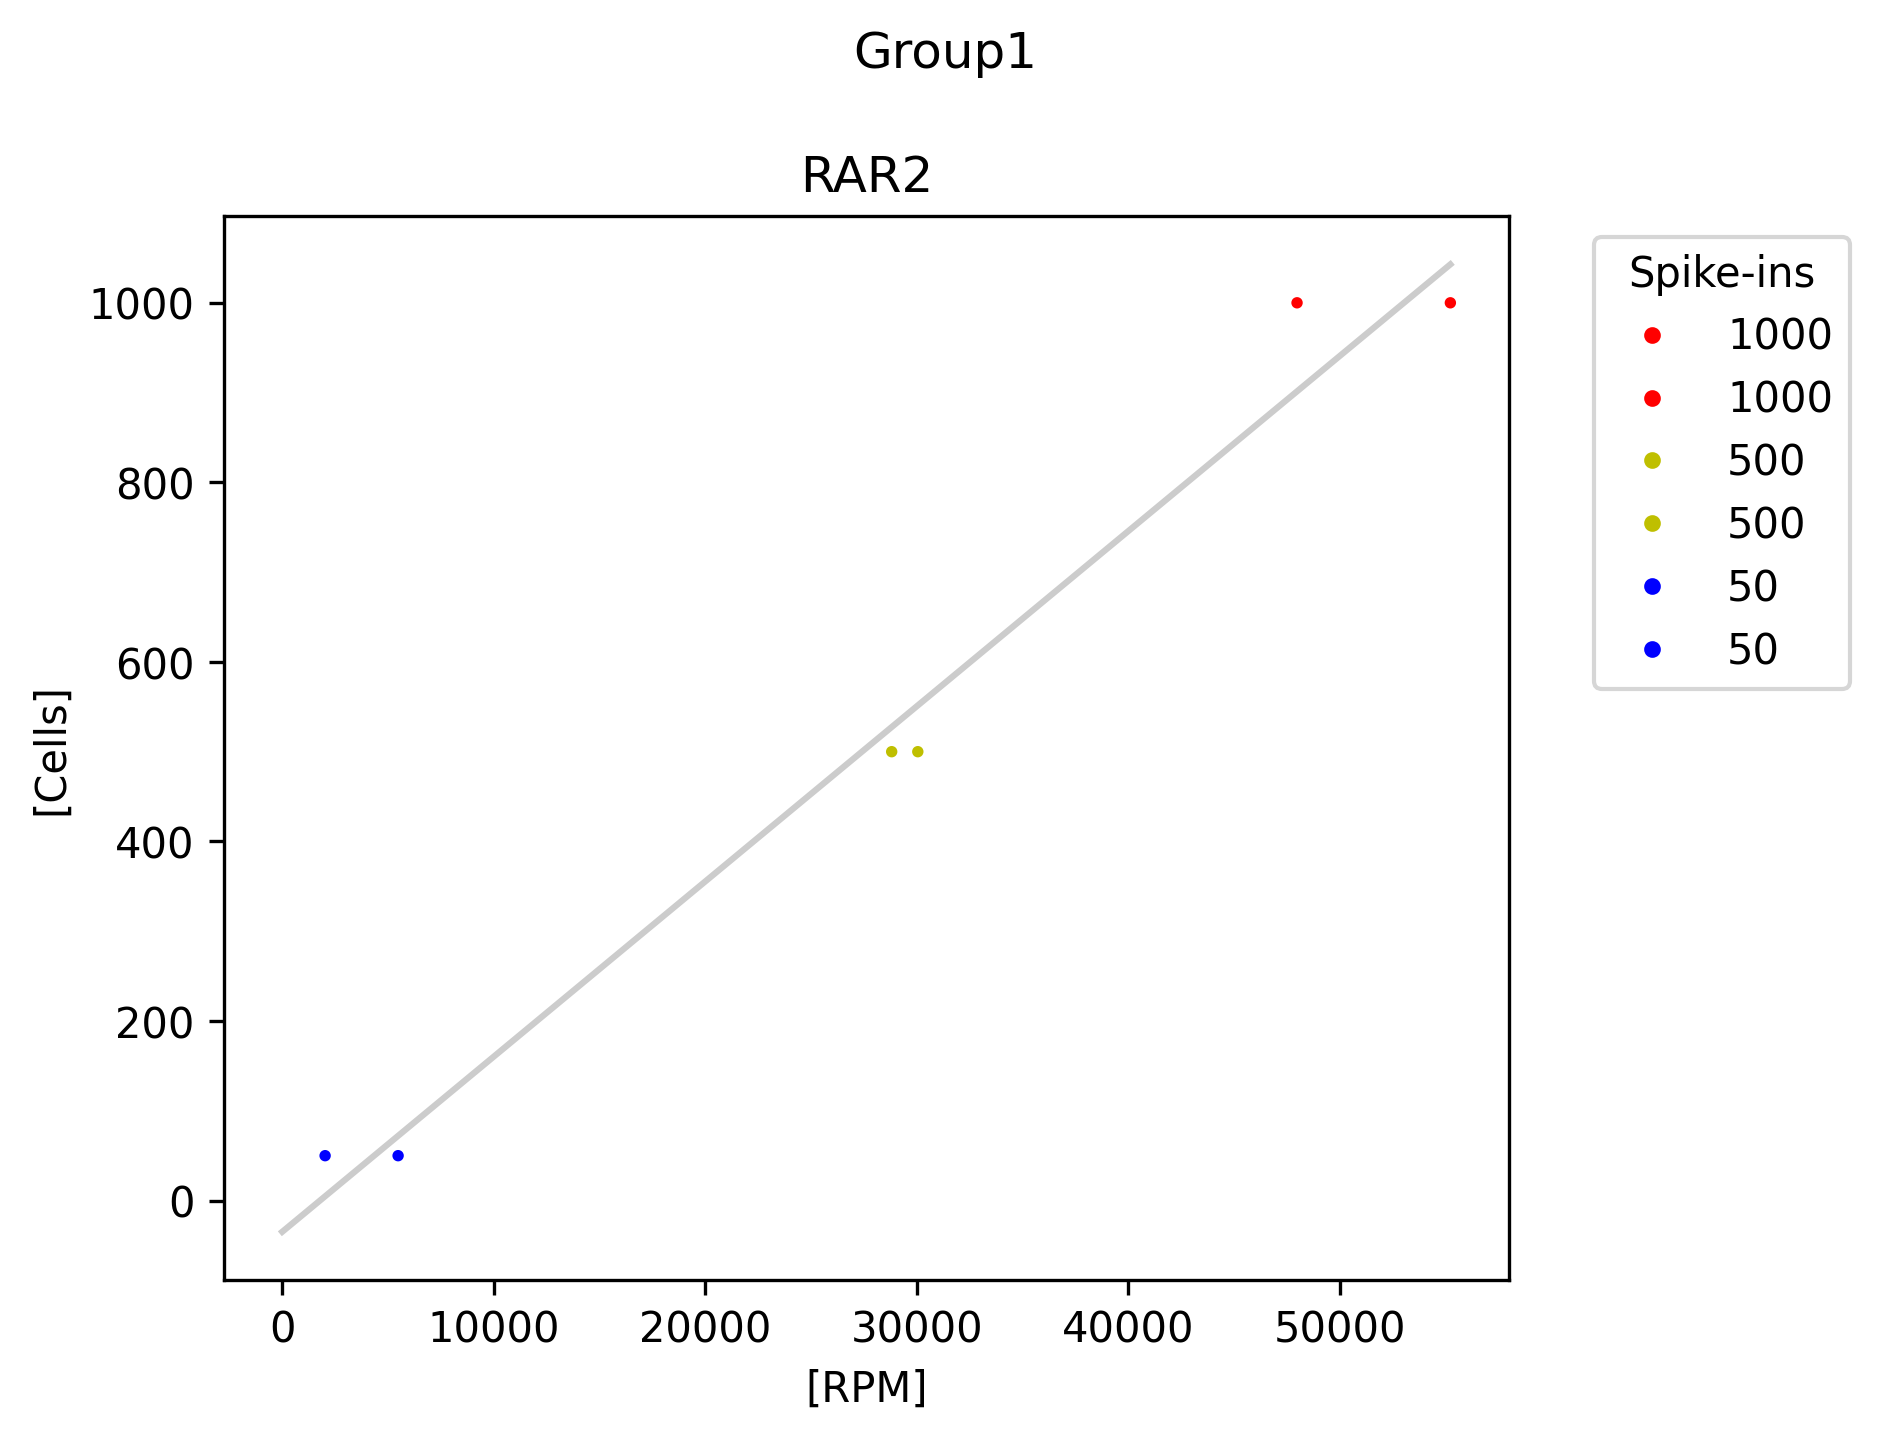

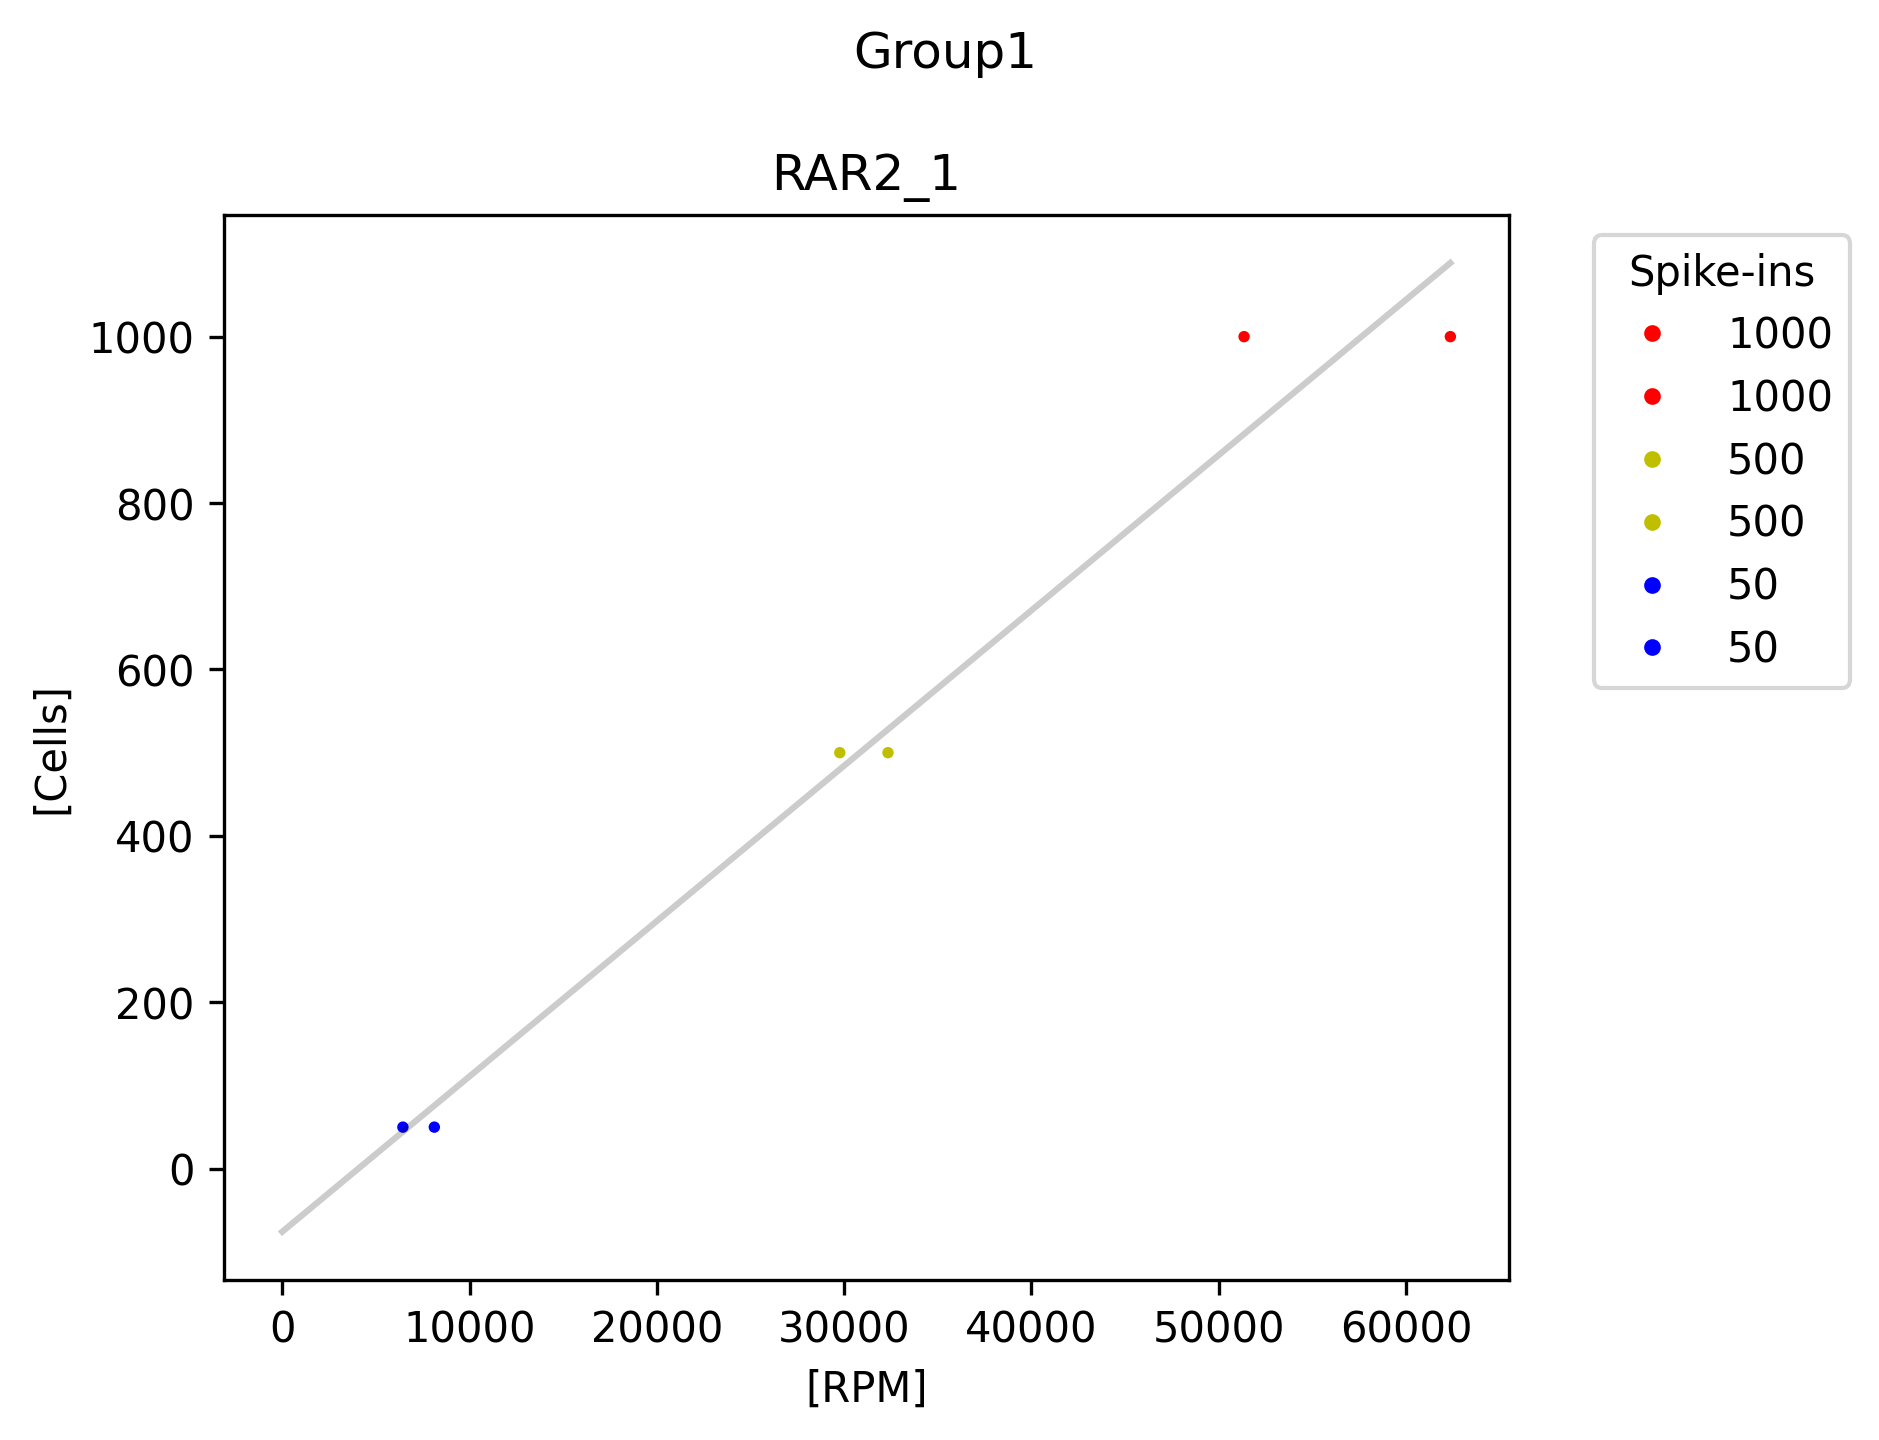

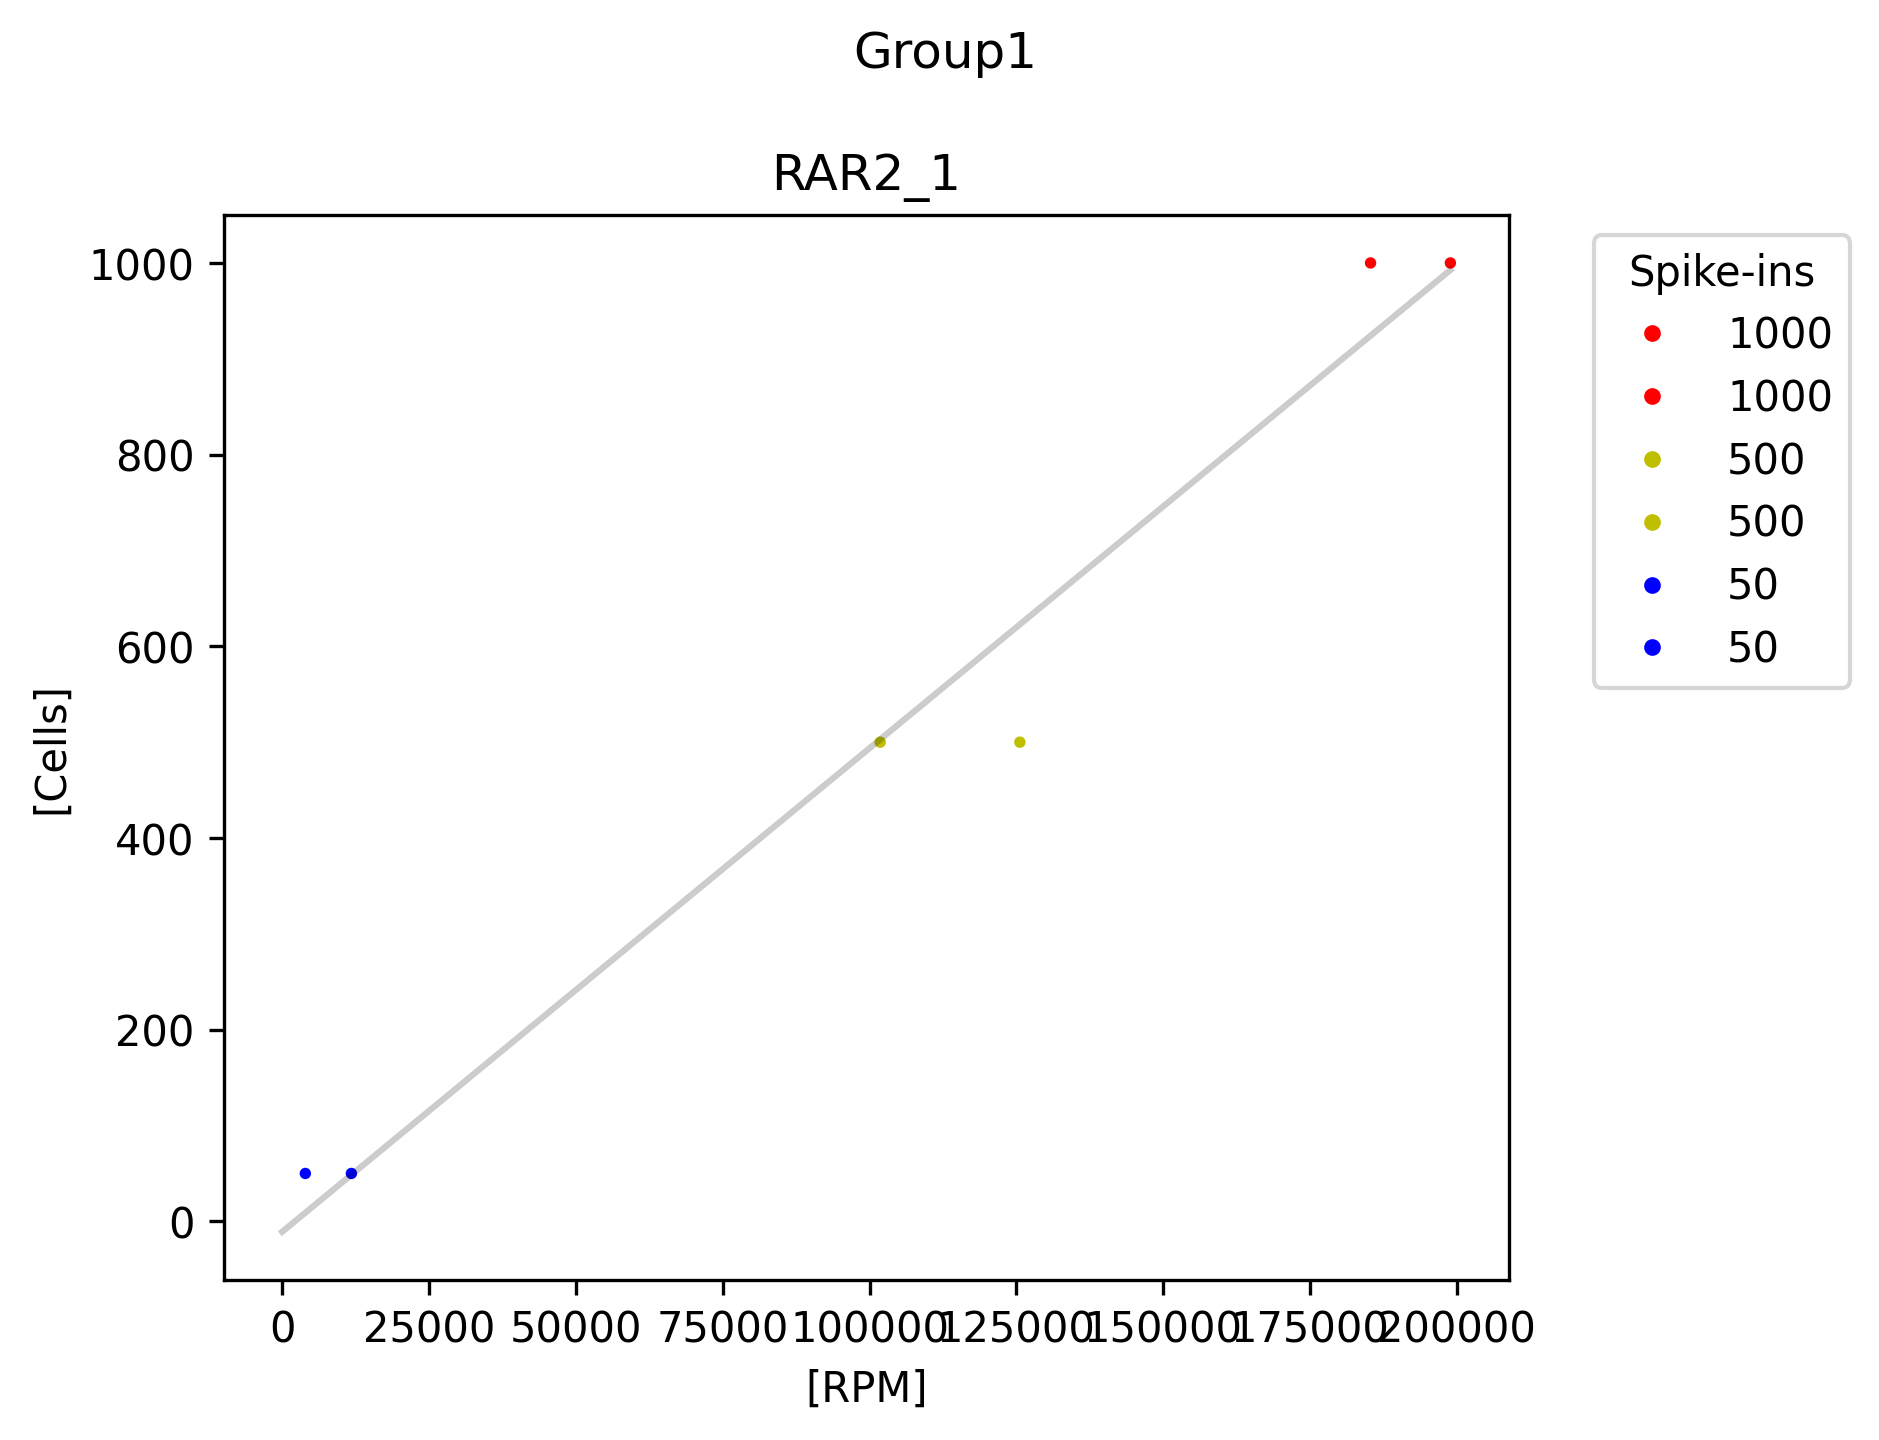

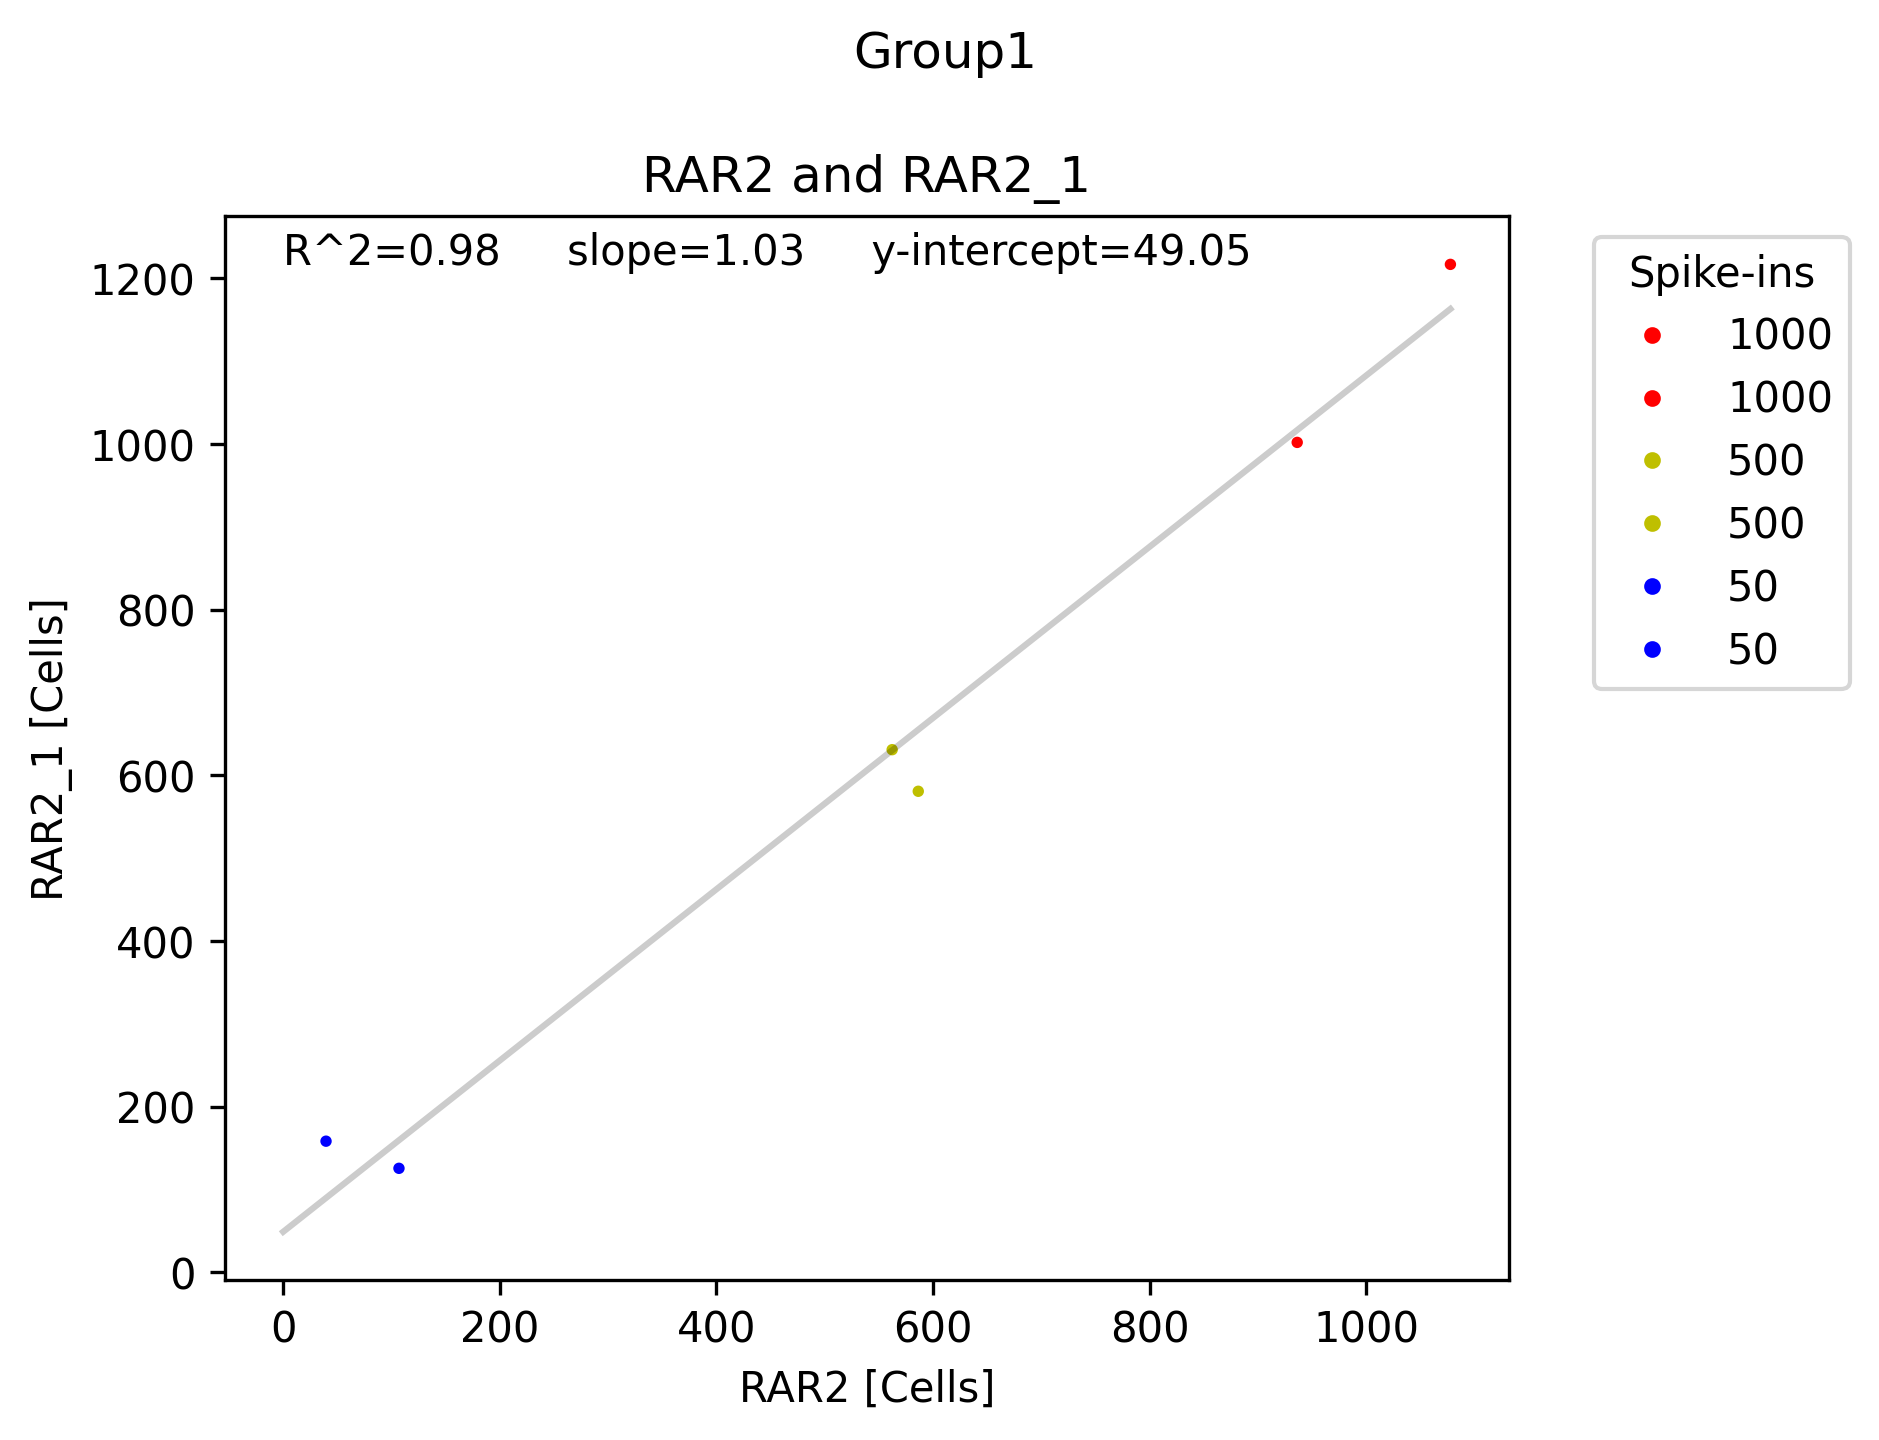

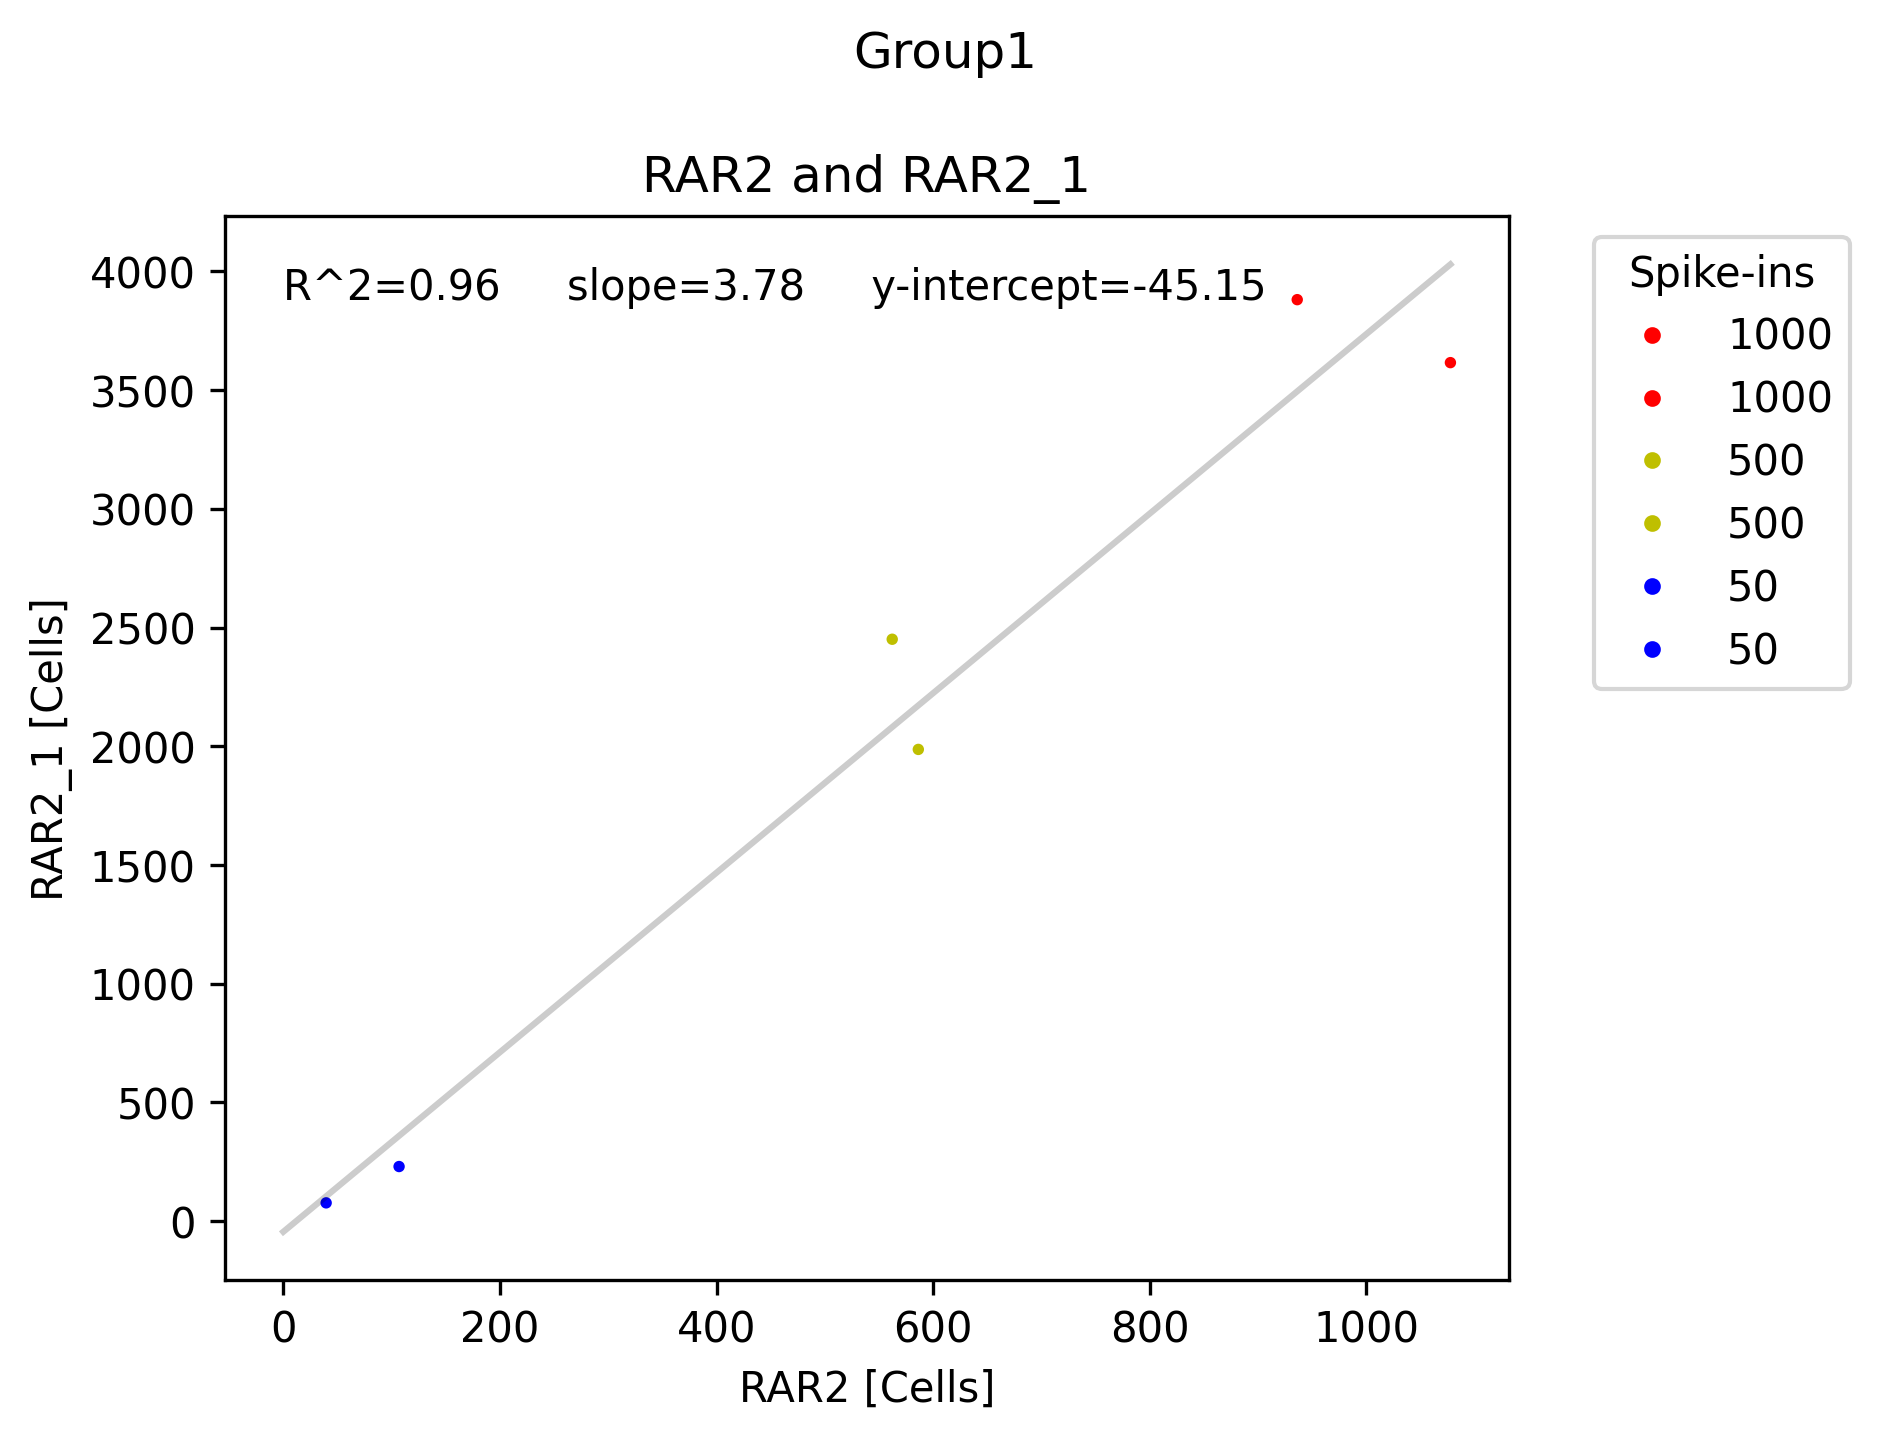

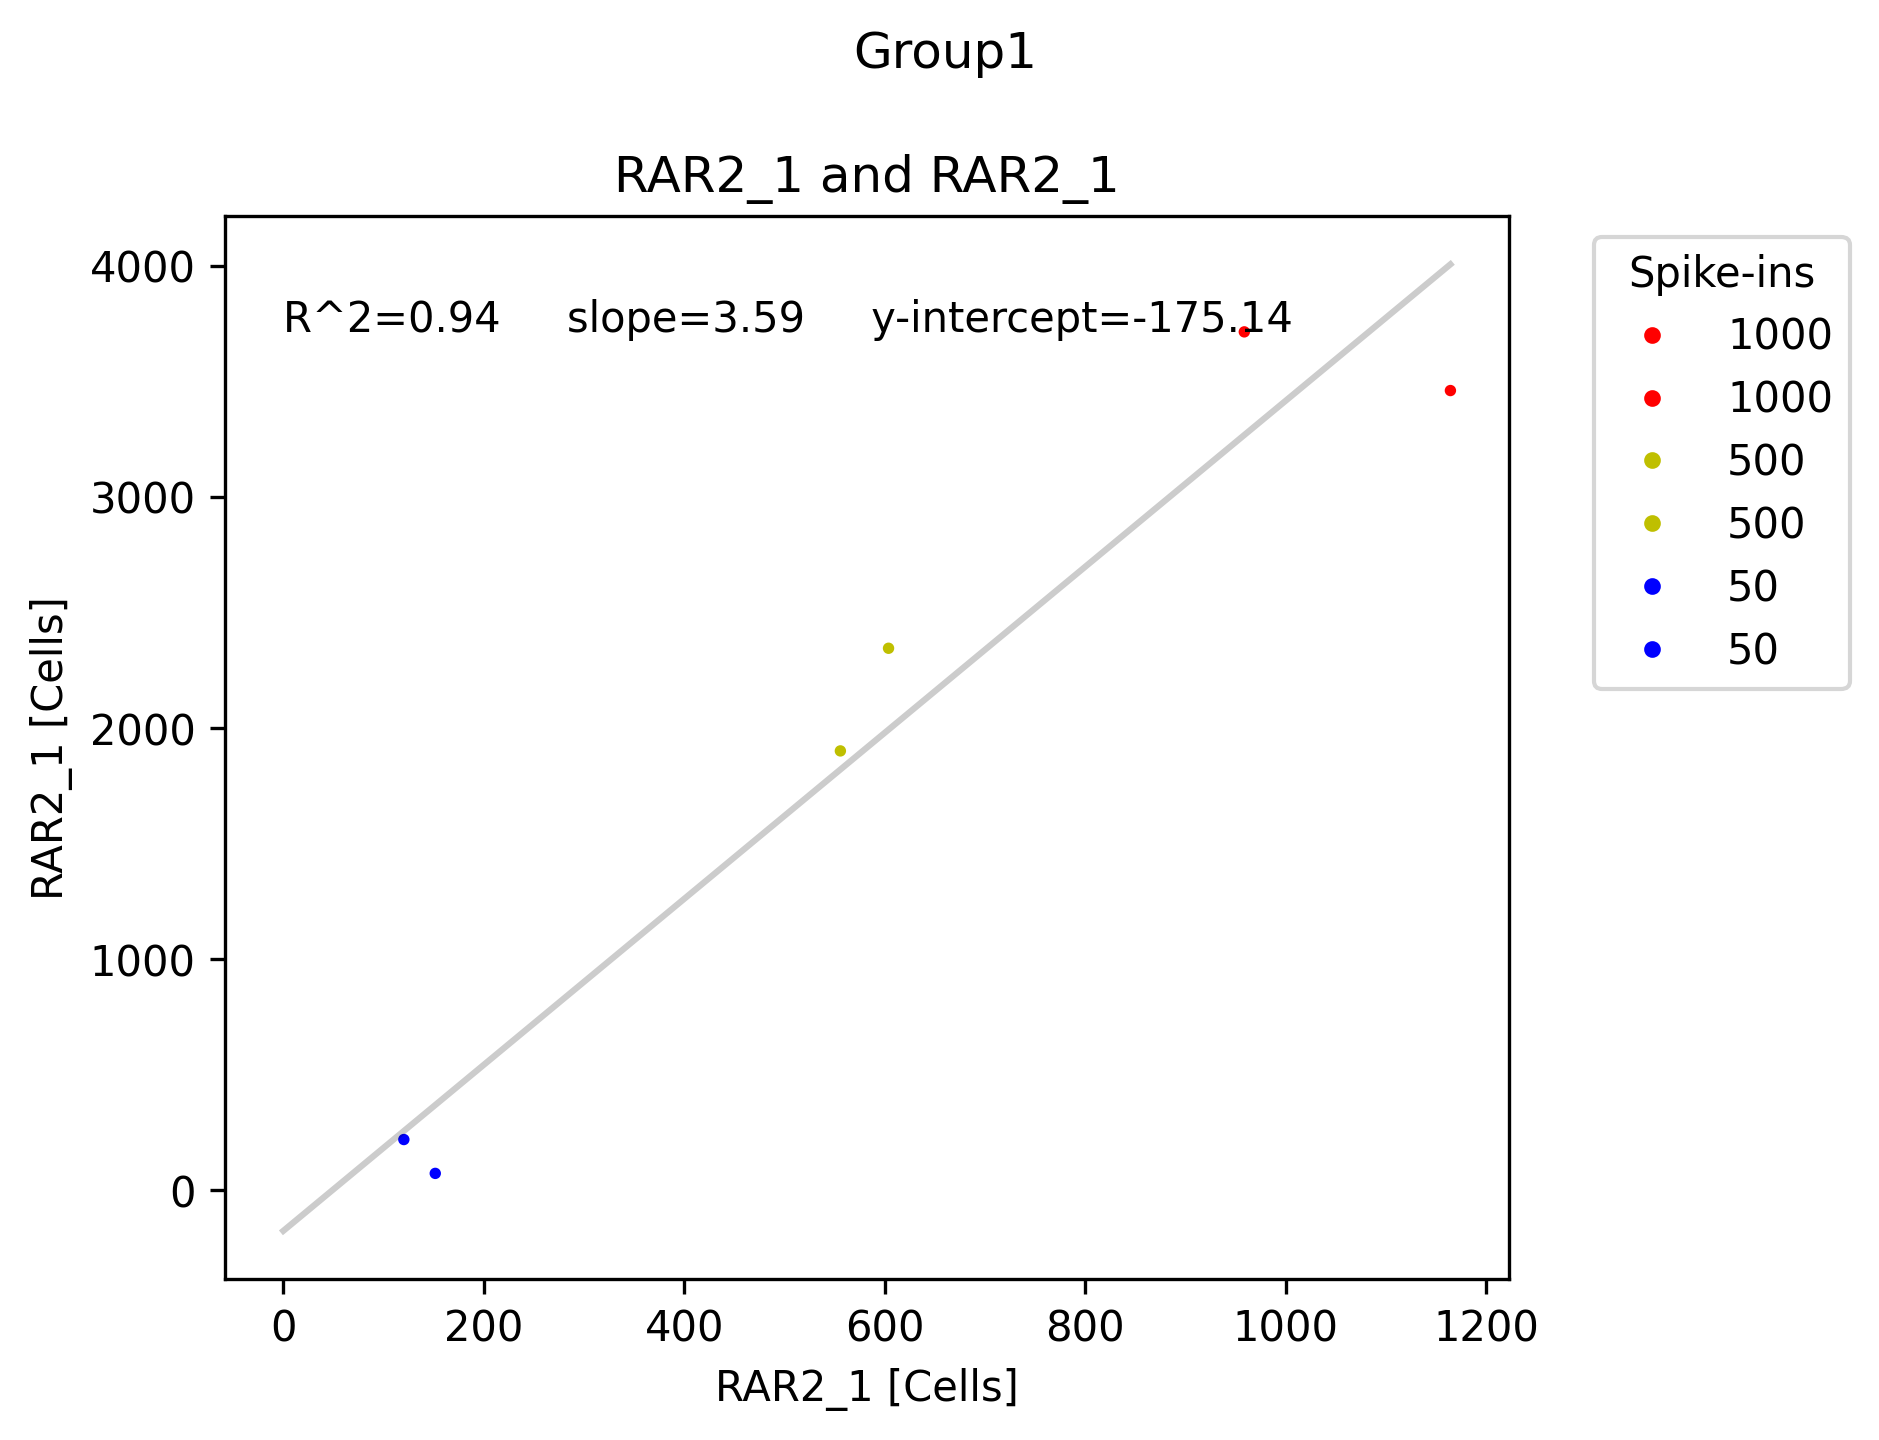

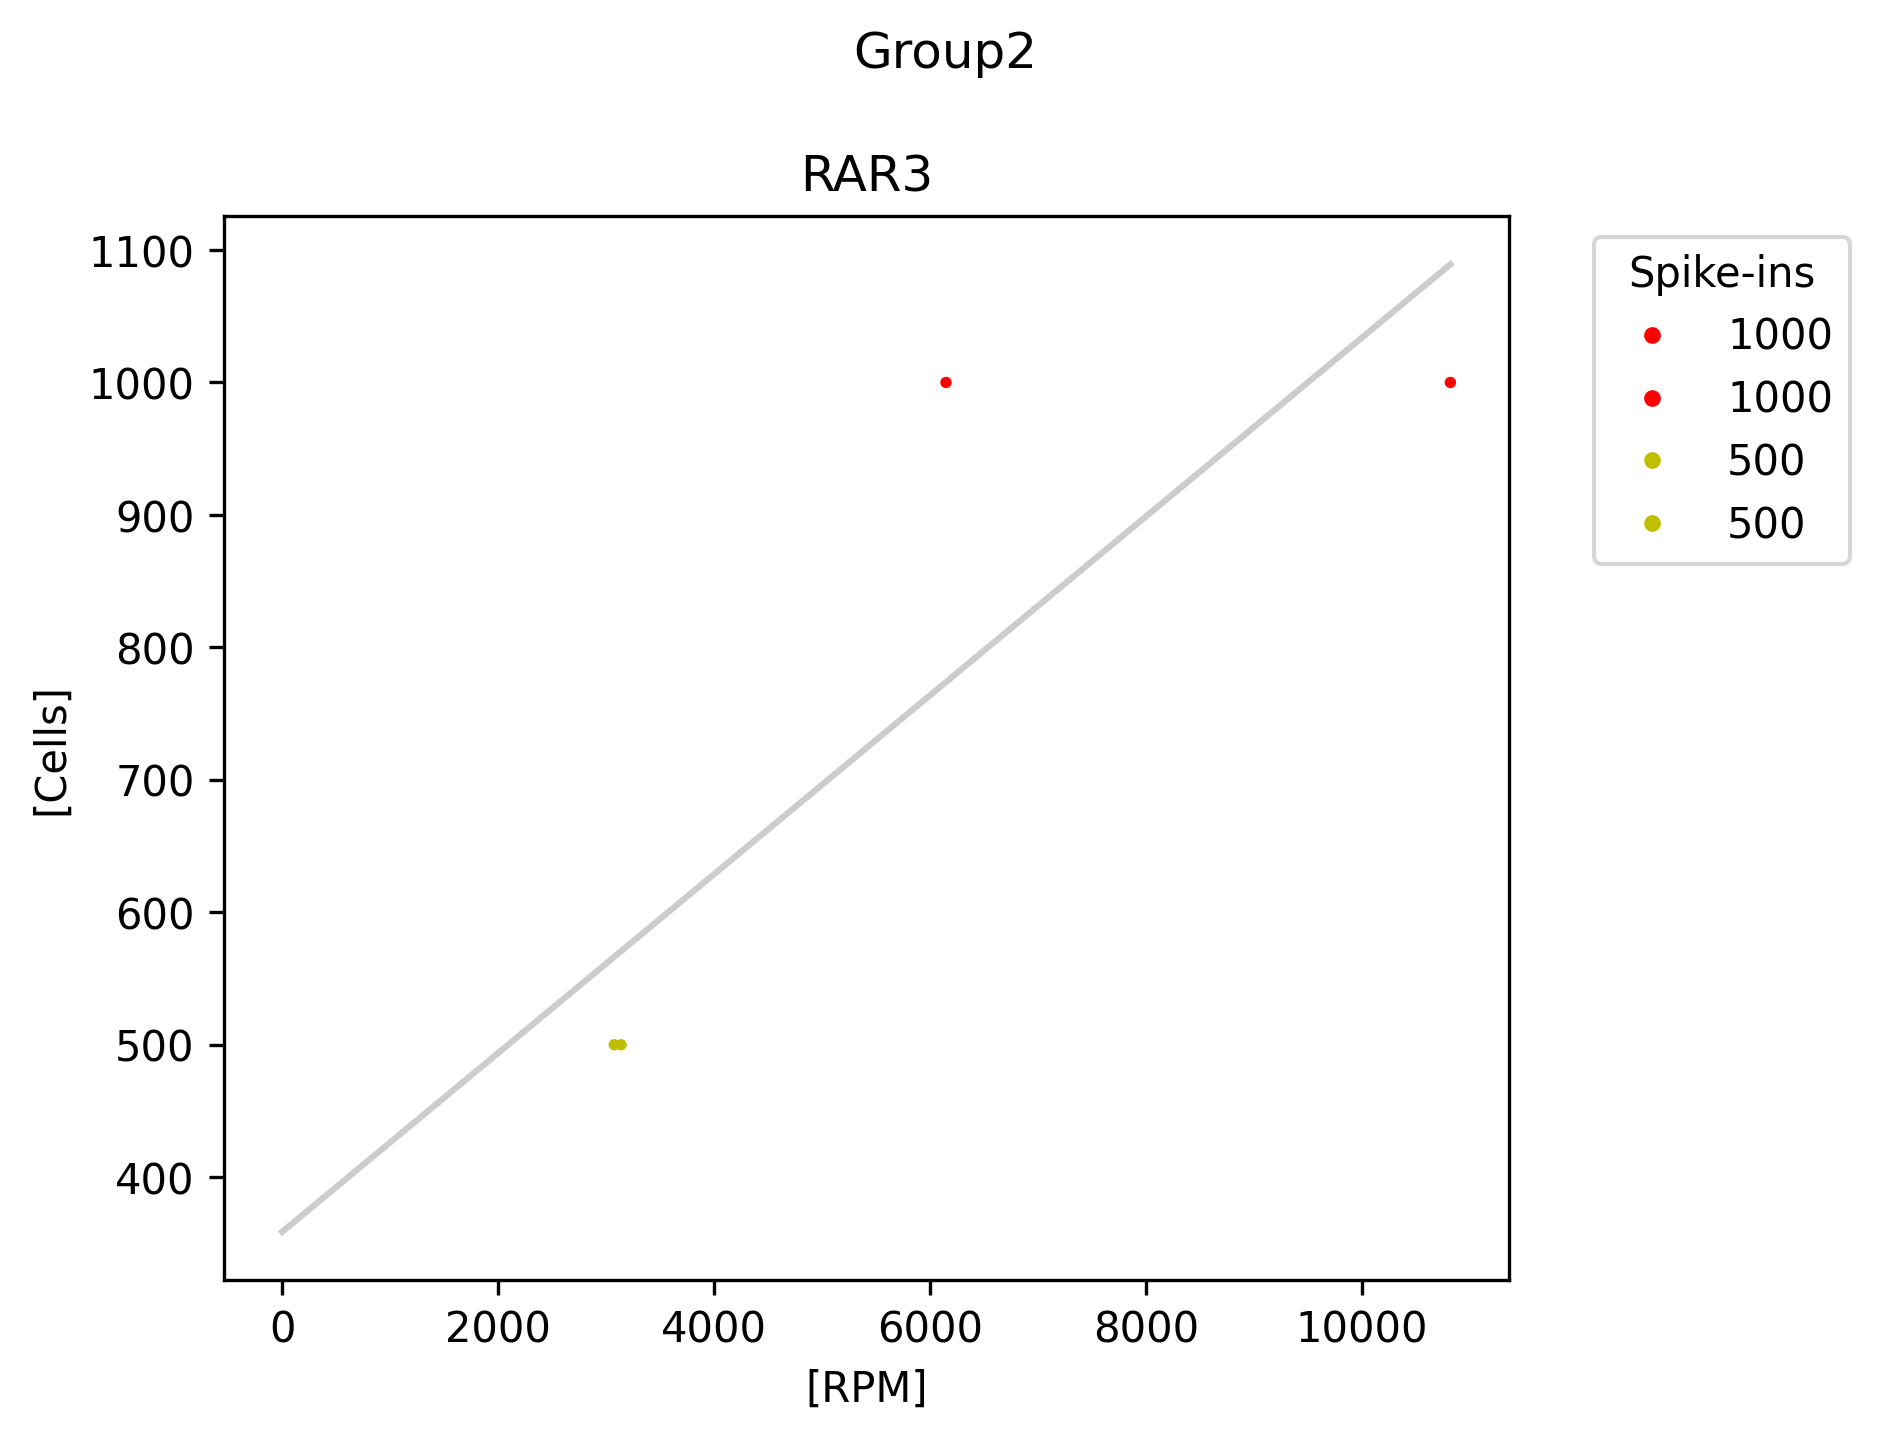

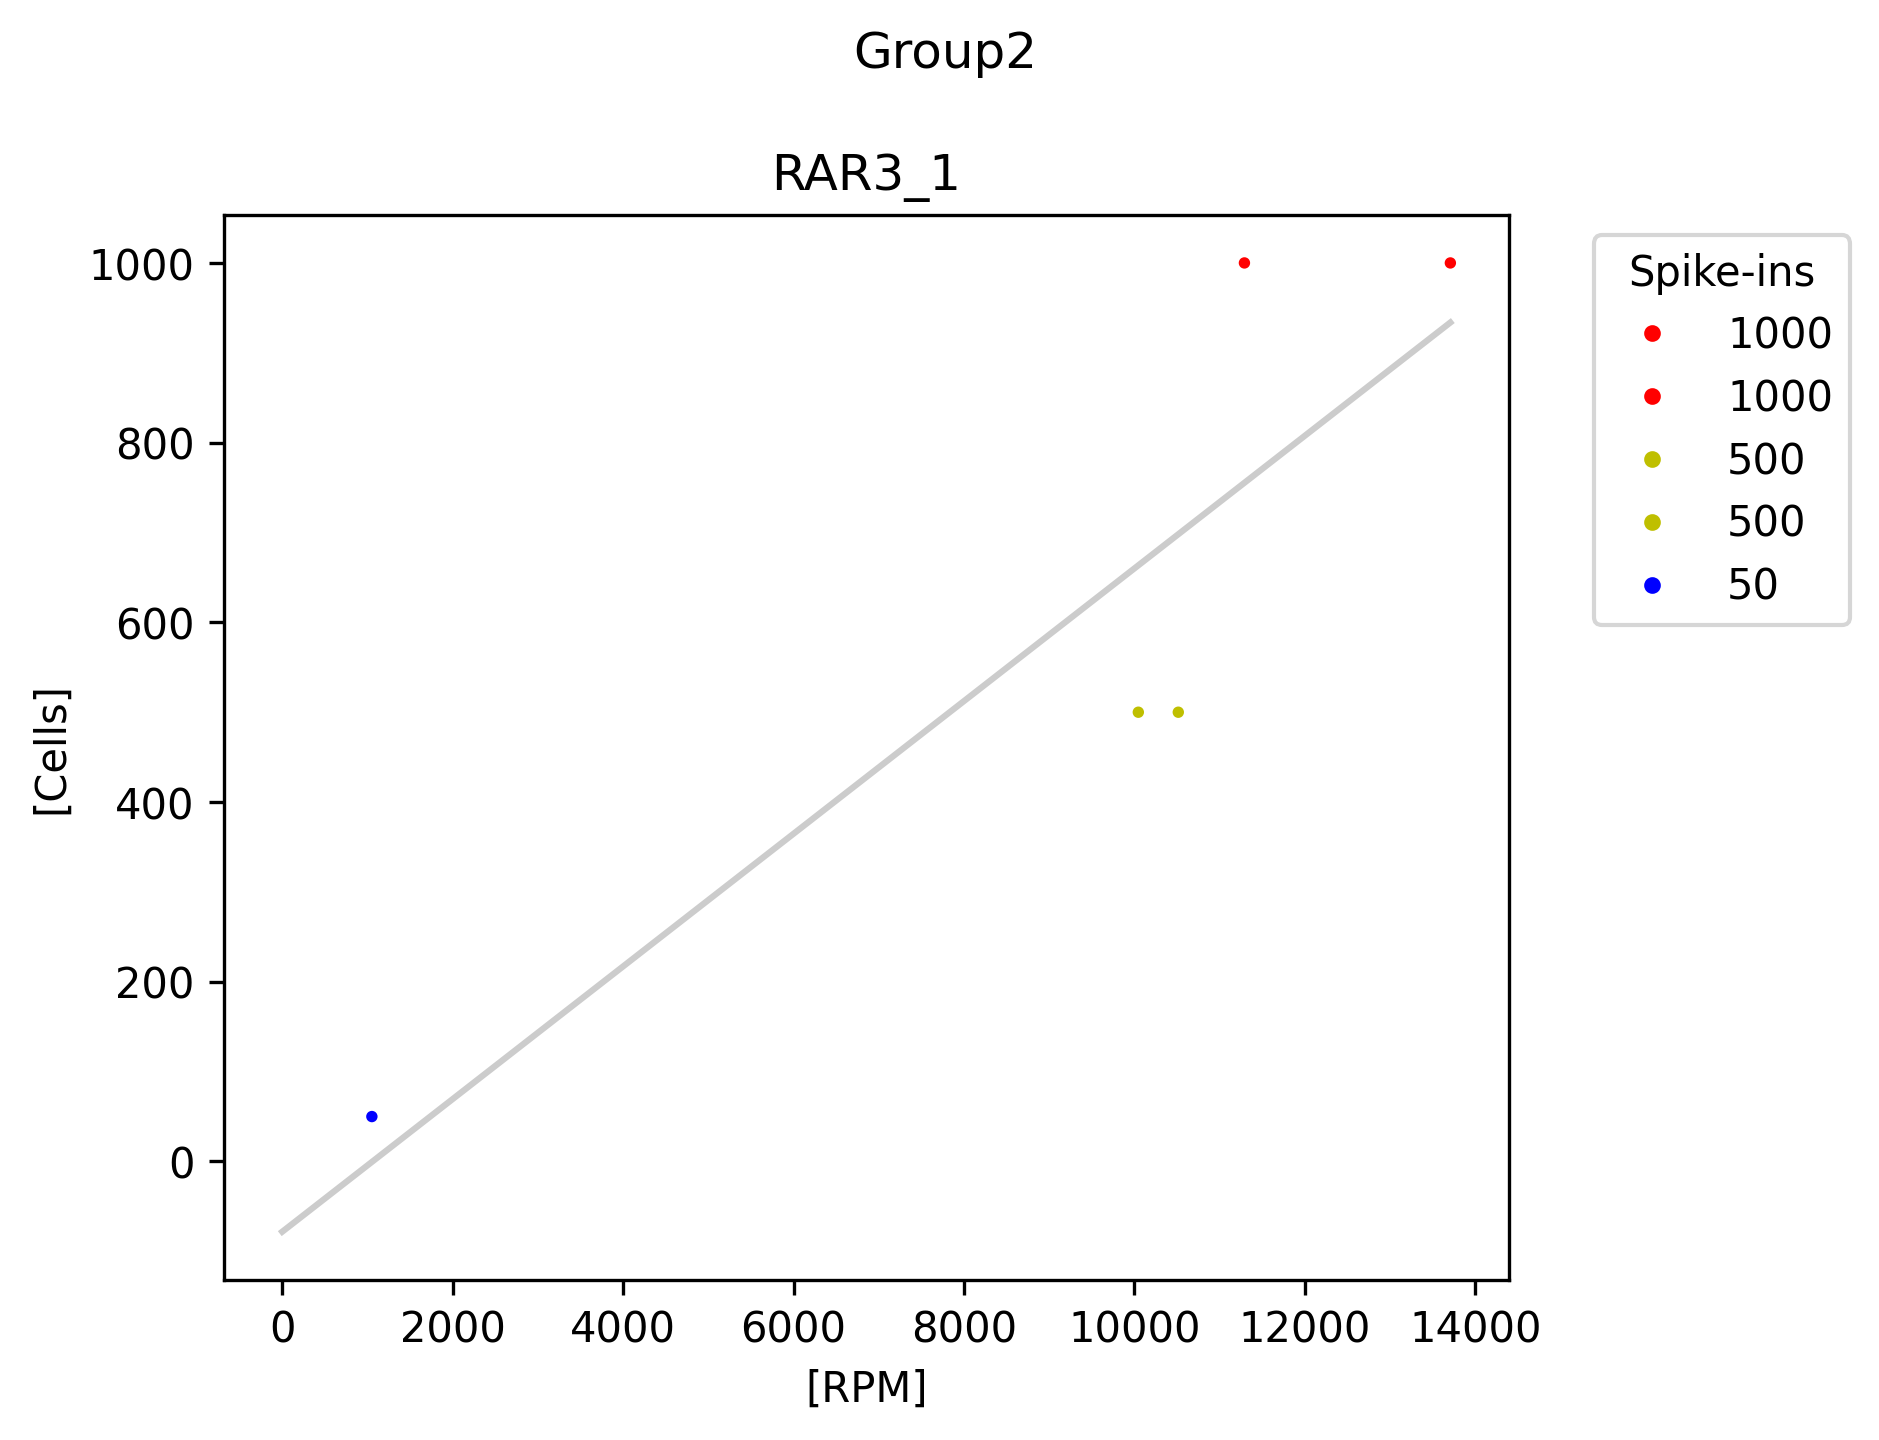

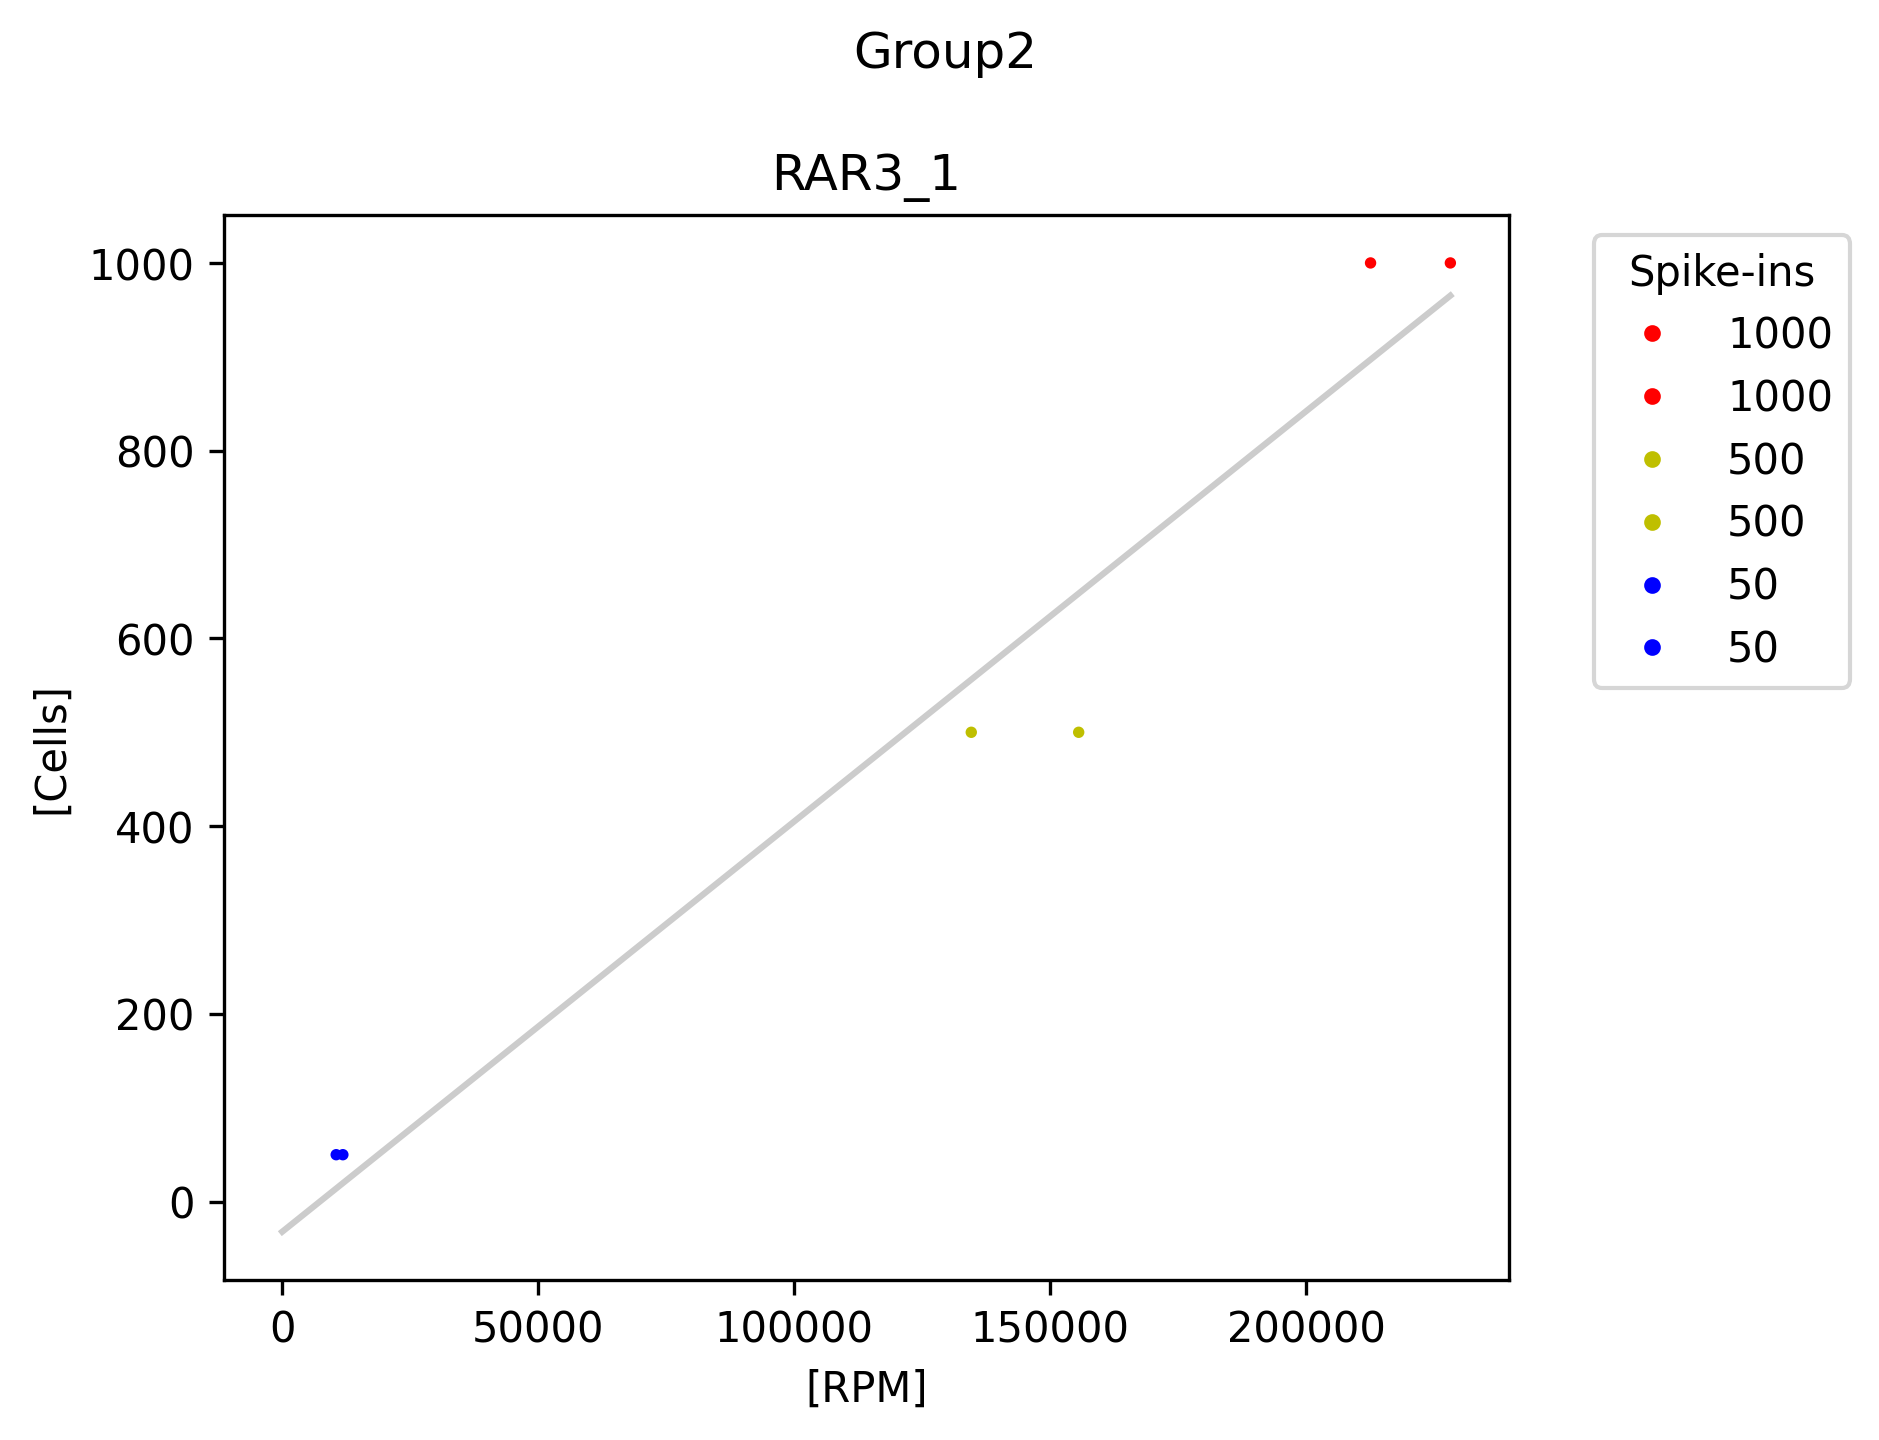

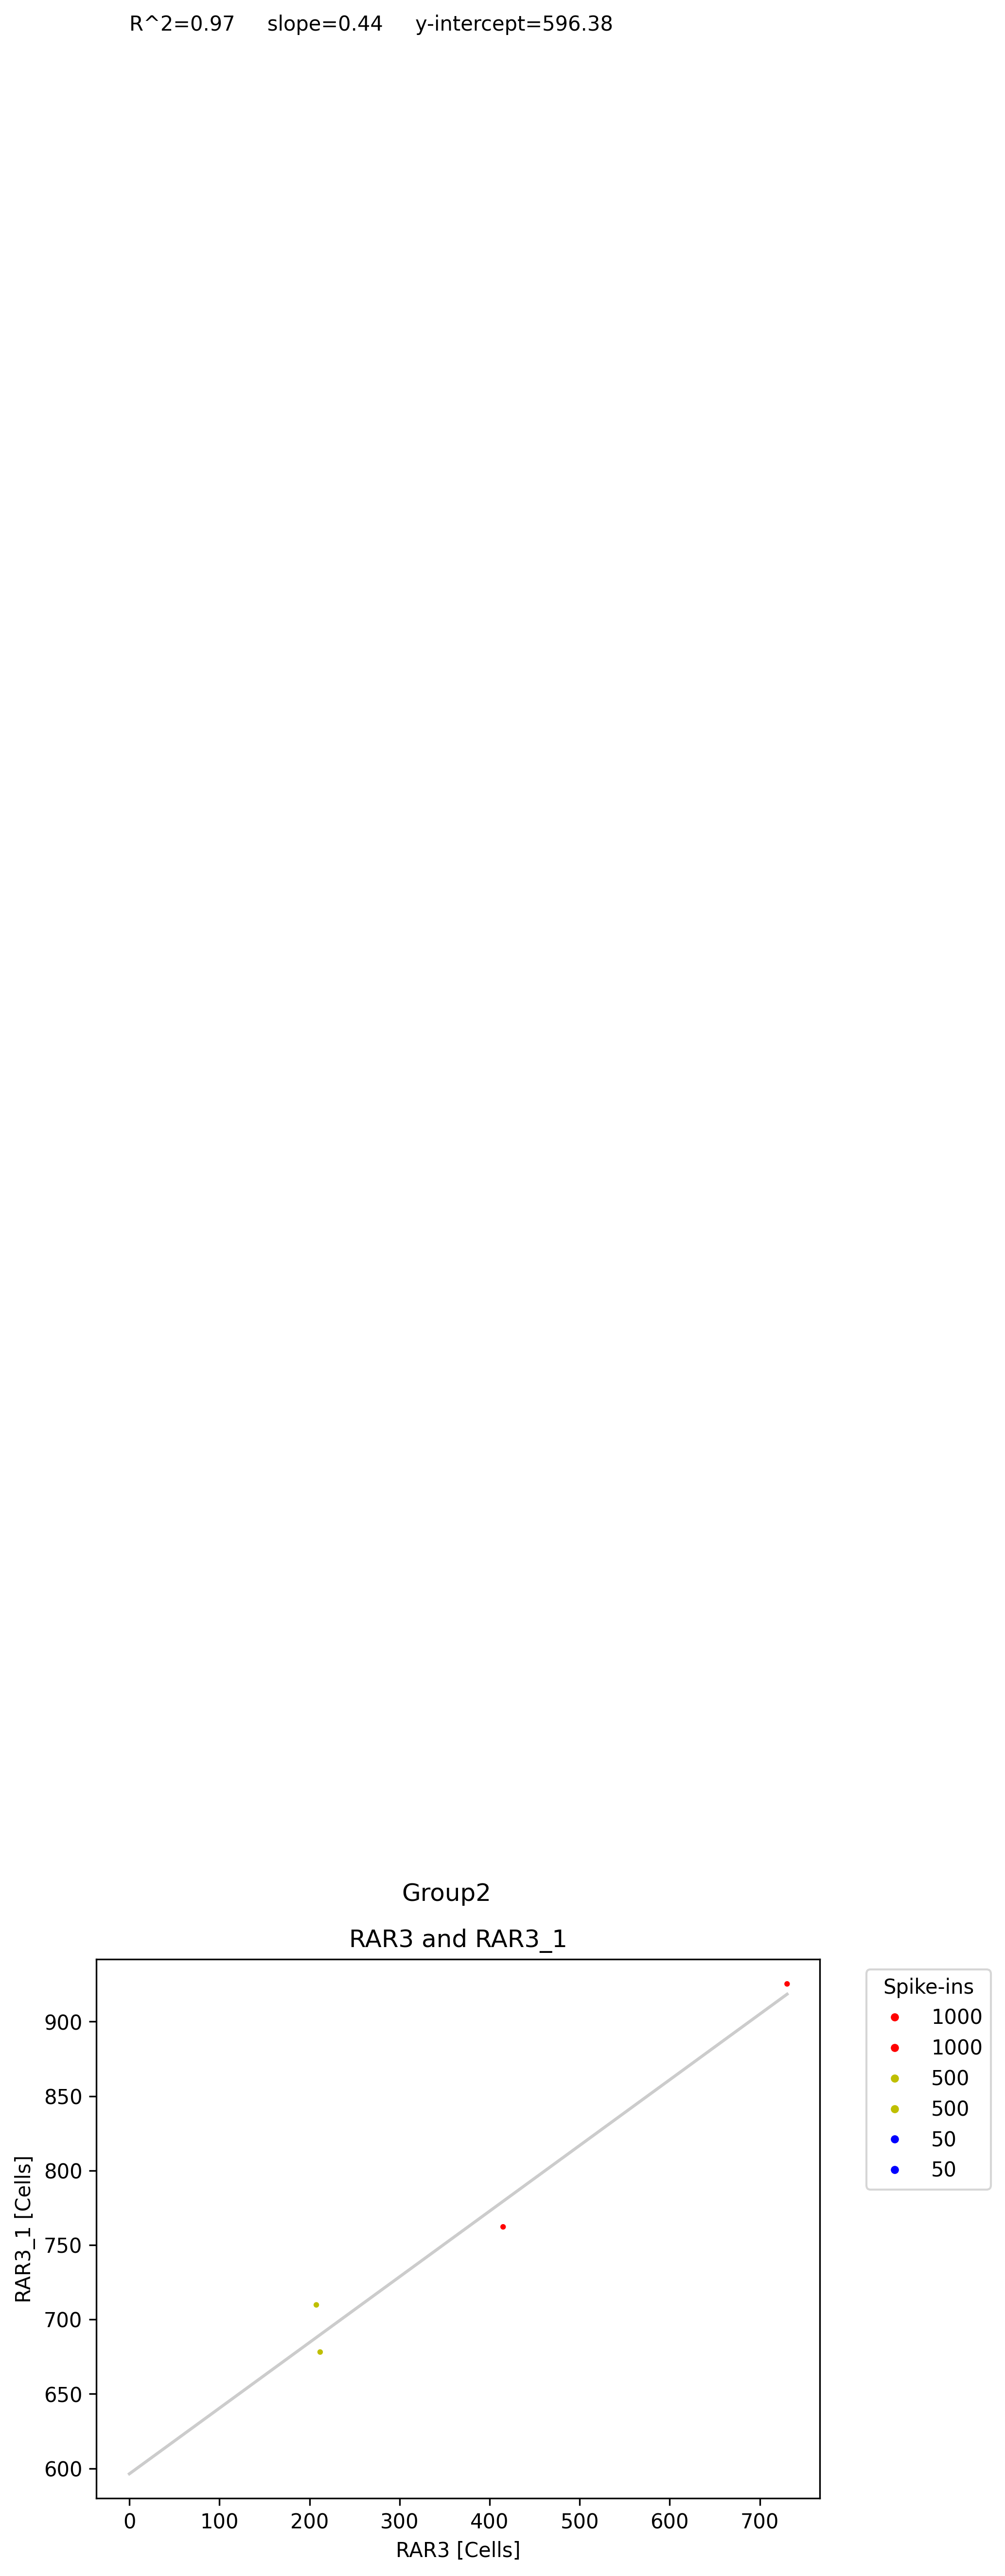

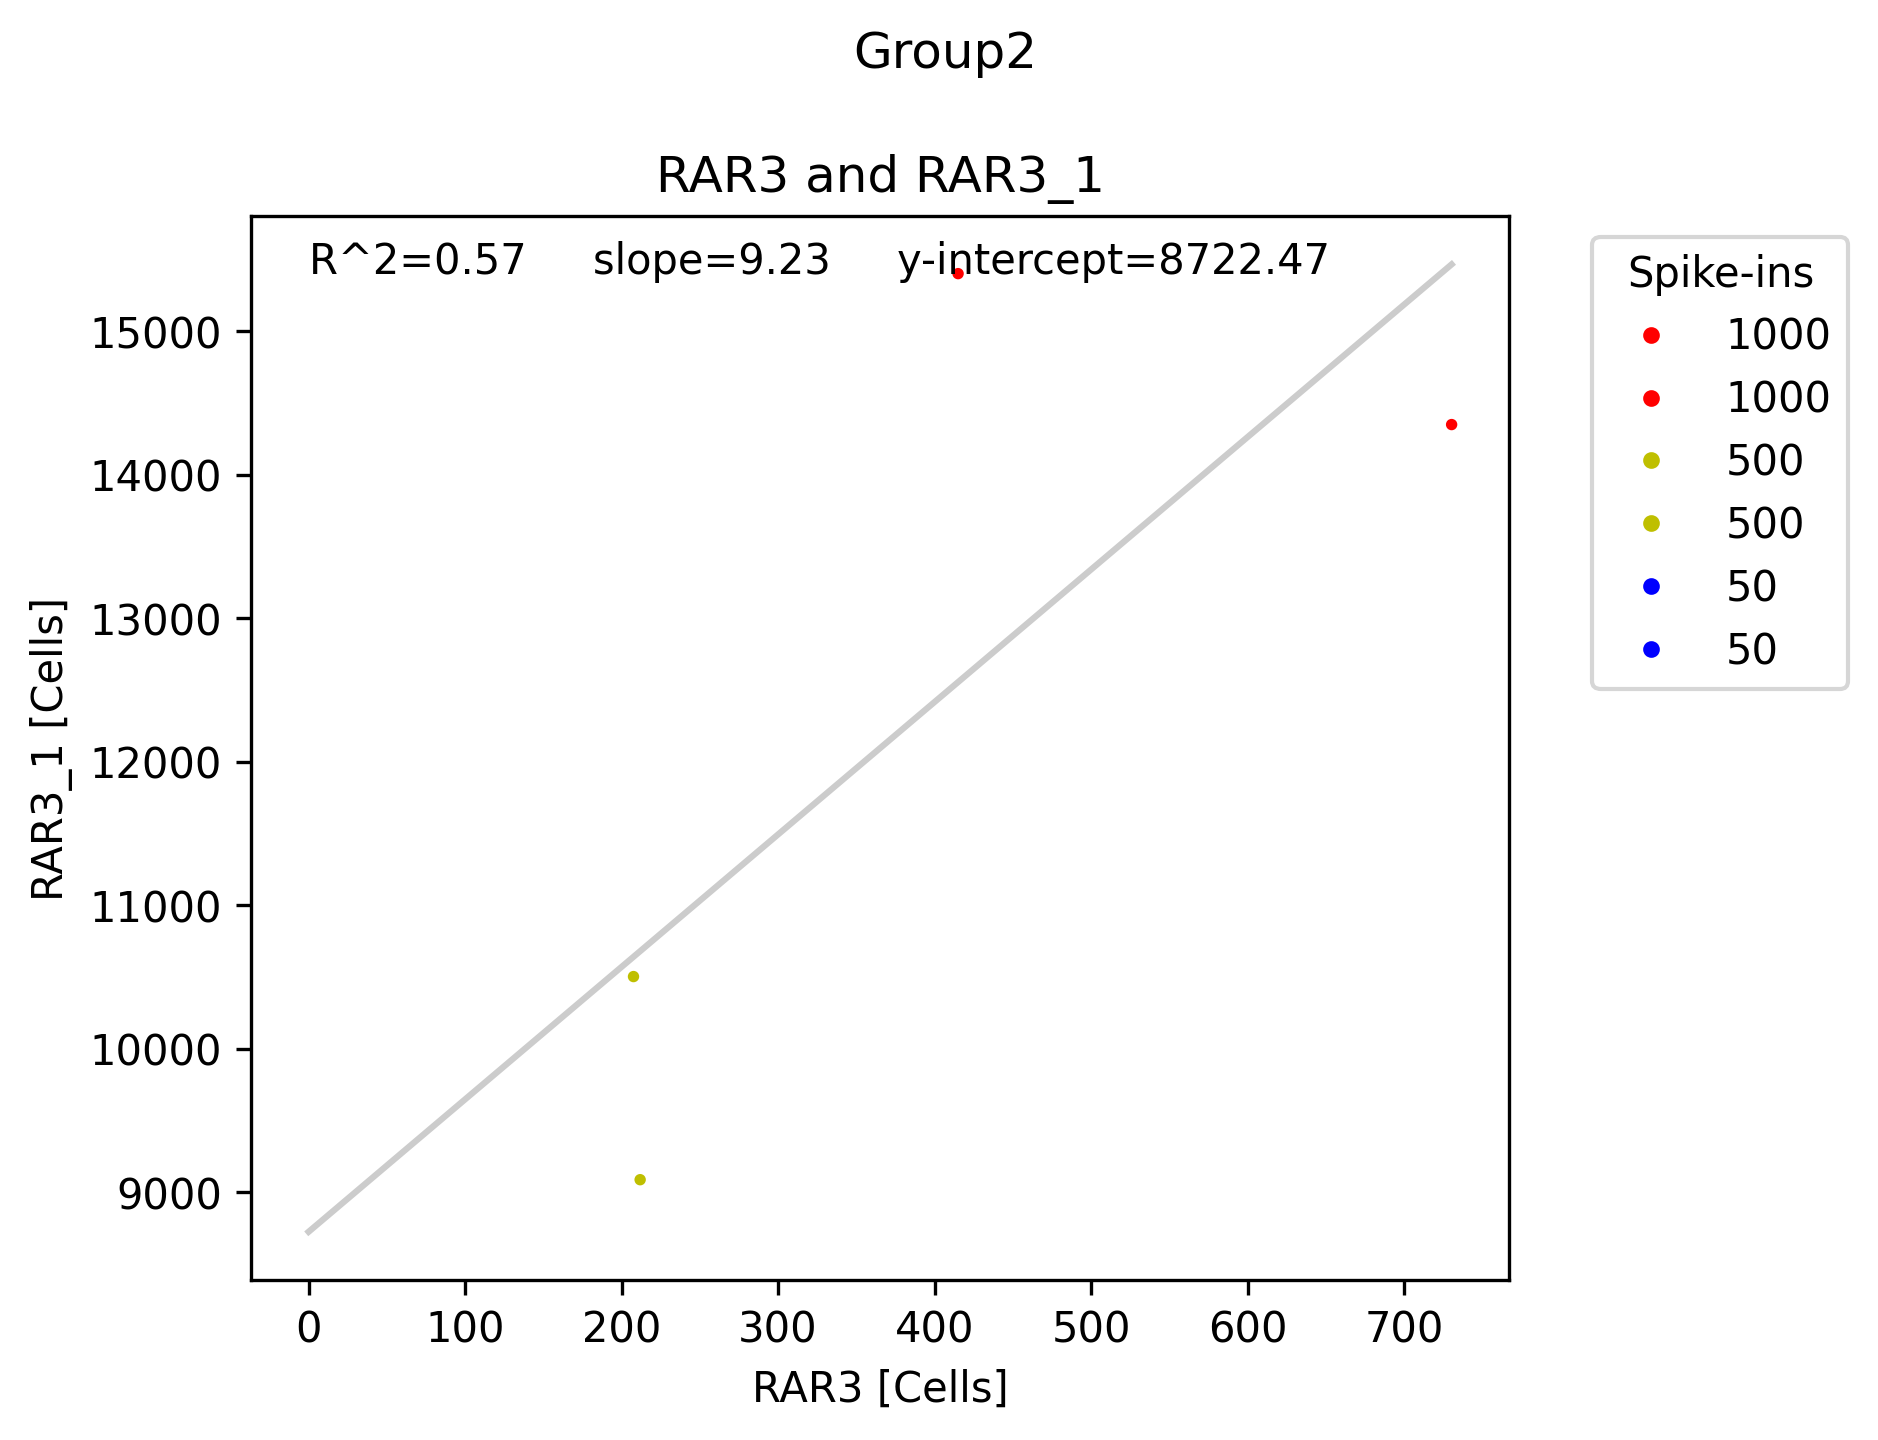

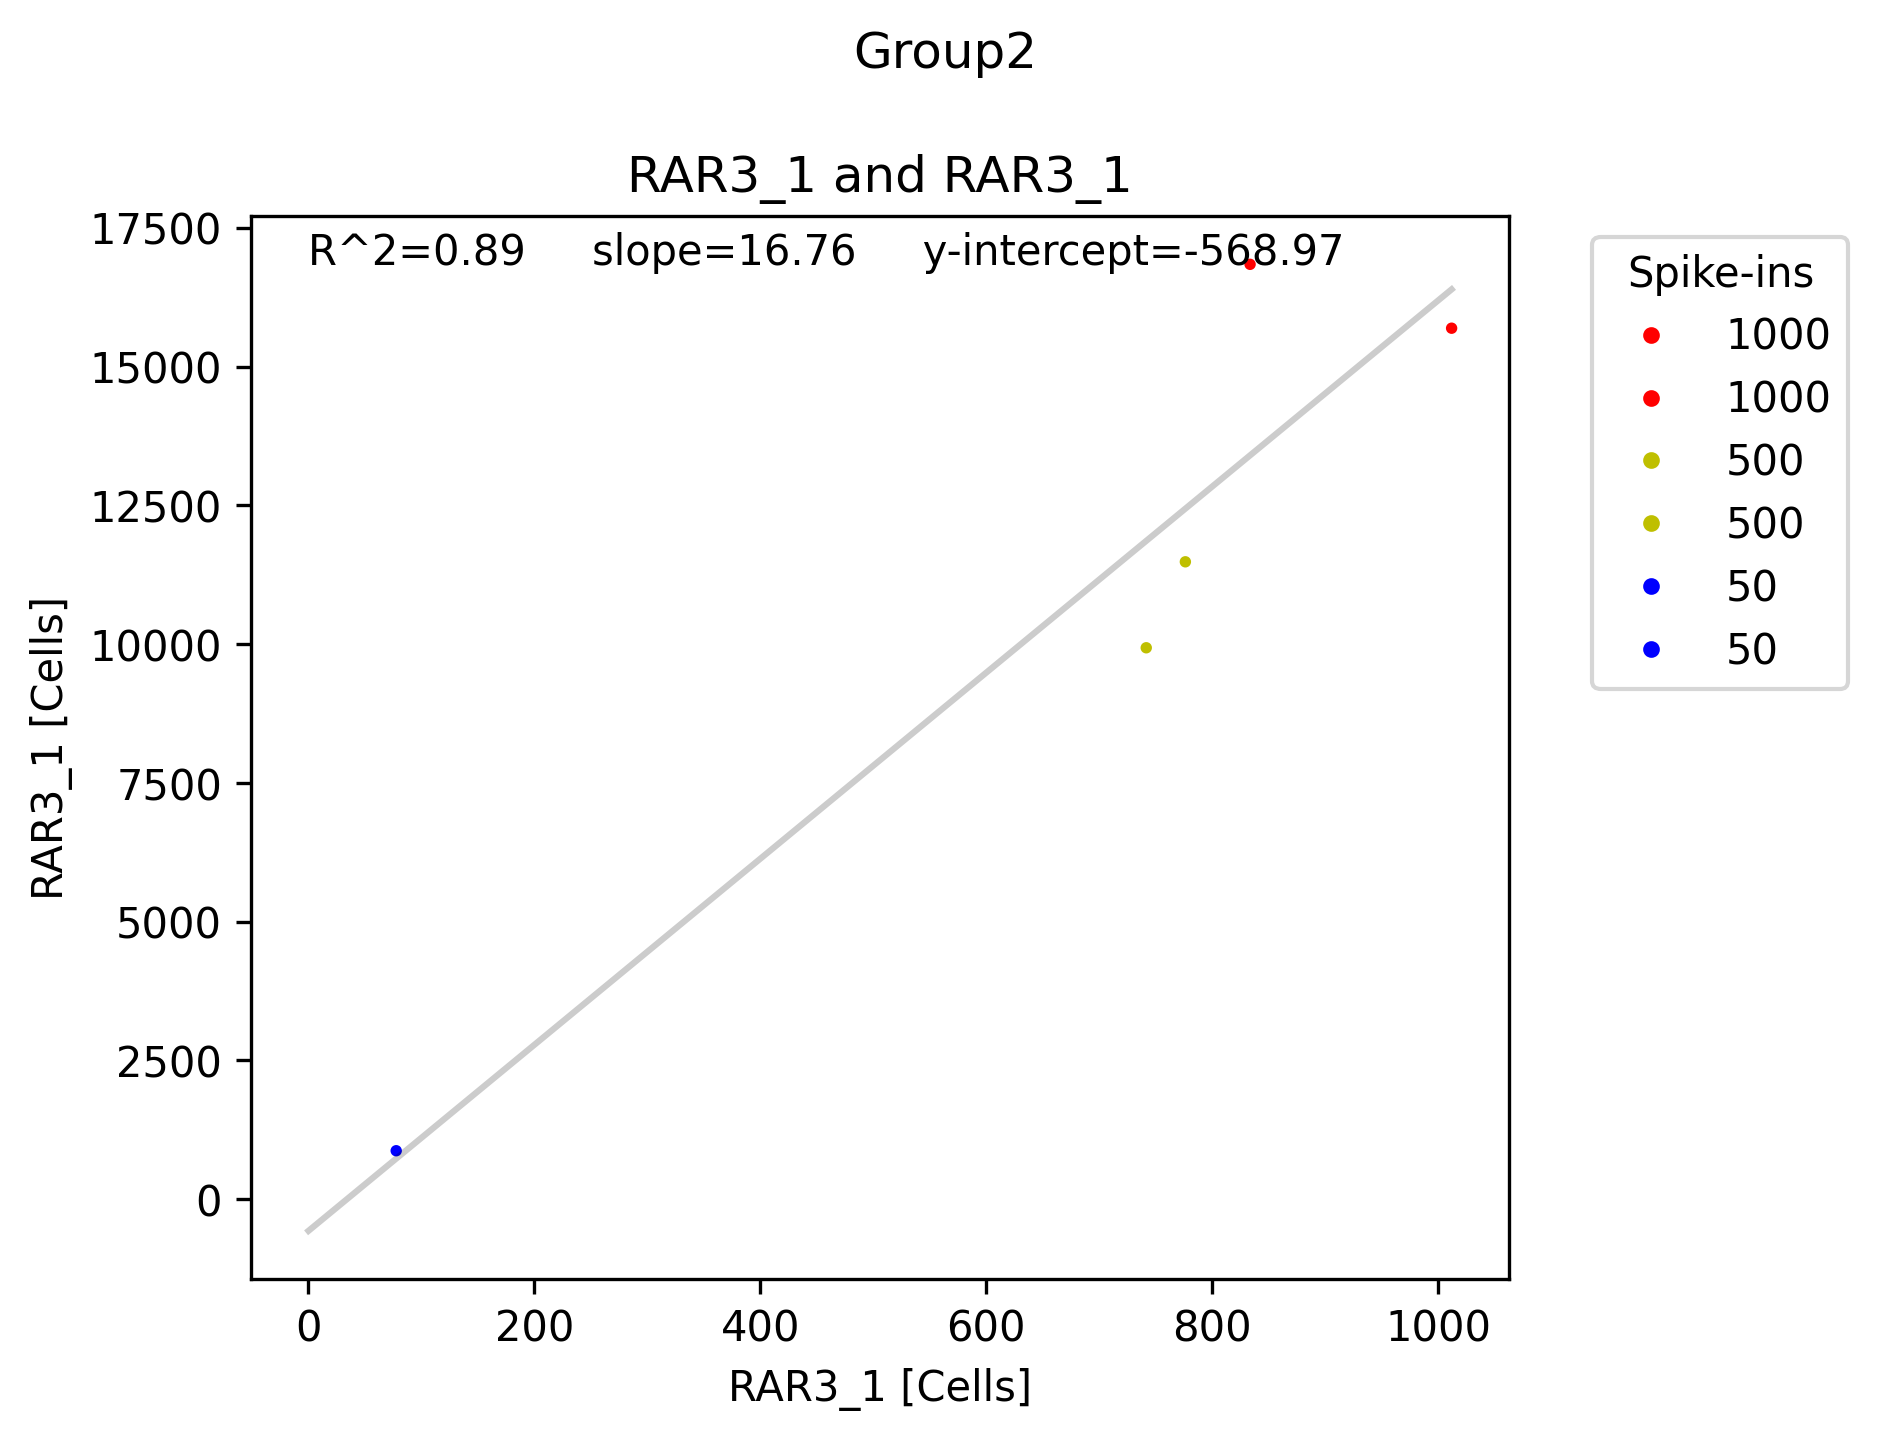

In [43]:
import pandas as pd
import itertools
from matplotlib.backends.backend_pdf import PdfPages

GSAMP = [["RAR2","RAR2_1","RAR2_1"],["RAR3","RAR3_1","RAR3_1"]]
Outfolder = "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data_old/split_barcode/output"

save_path = "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data_old/split_barcode/output/fit_spikeins"

barcode_quantify_folder =  Outfolder + "/barcode_quantify/"
path_to_feature_ref =      "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data_old/split_barcode/20220110_gDNA_barcode/CellRanger_inputs/FeatureReference_filtered.csv"#Outfolder + "/CellRanger_inputs/" + "FeatureReference_filtered.csv" 
path_to_sc_output_files = "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data_old/split_barcode/20220110_gDNA_barcode/starcode_outputs/sc_output_counts_*.txt"#Outfolder + "/starcode_outputs/sc_output_counts_*.txt"

spike_in_added = "yes"
spike_in_seqs =  ["TGGAGGTGAAGCTCCAGTTGCAGATCGACGACTAGGTCAAGATGAACTTCGAGCACTTGGACCTCCACGT",#//1000
                      "ATTCATGTTCTTGAAGGACATGATGGTGTTCTTGTACCTGTTGTACTACGACCTCATGATCGTCATCAAG",#//1000
                      "AGTTCGTCTACCTCATCTTGATGATGTTCAAGTAGGACGACGAGTAGCTCTACCAGGTGCAGATCGTGCA",#//500
                      "TGTAGATCTAGCTGATGTACGTGATCTTGGACATCTTCTTCATCCACCTCTTGATGAAGTACTACTTCAA",#//500
                      "ACCTGTAGATGTTCATGCTGTTCGAGTTGATGTTCTTGTTGCACAAGCACTACATGCTGTTGTACTTGGT",#//50
                      "ACCTCCTGGTGCTGTACATGCTCTAGATCTACGTGTTCTTGTAGCTCTTCGTGTACATGCTGGTGGAGAT"]#//5
        
spike_in_value = [1000,1000,500,500,50,50]

spike_in_color = ["r","r","y","y","b","b"]        
spike_in_for_pearson = []
data_pearson = []
data_pearson_P = []
counter = 0

with PdfPages(save_path  + '/Spike_in_group'+ str(counter)+'.pdf') as pdf:

    for grp in GSAMP:

        counter += 1
        print("     group"+ str(counter) +' :')
        print(" ")
        path_to_group_folder = barcode_quantify_folder + "plots_group"+ str(counter) + "/"
        #os.mkdir(path_to_group_folder)


        #Load in Data
        filepath = barcode_quantify_folder  + '/FeatureReference_filtered_group'+ str(counter) + '_counts.csv'
        df_ref = pd.read_csv(filepath)

        #----------------------------Find and label spike ins------------------
        df_ref['spike_in_c'] = ['k']*len(df_ref.iloc[:,0])

        if spike_in_added == 'yes':
            for sp,spike_in_seq in enumerate(spike_in_seqs):
                df_ref.loc[df_ref['sequence'].str.match(spike_in_seq),'spike_in_c'] = spike_in_color[sp]


        #----------------------------Remove 0 and 1----------------------------
        print("         Removing zeros and ones")
        print(" ")

        df_plot = df_ref.iloc[:,-len(grp)-1:]

        df_plot = df_plot.replace(0, np.nan, regex=True)
        df_plot = df_plot.replace(1, np.nan, regex=True)

        #----------------------------Reads per million--------------------------
        for i in range(len(grp)):
            df_plot.iloc[:,i] = rpm_norm(df_plot.iloc[:,i])

        #-------------------------Get all combinations--------------------------
        all_combinations = itertools.combinations([g for g in range(len(grp))],2)

        print("             Plot:")
        #Keep Spike-ins color
        all_spike_in_color_in_grp = []
        all_spike_in_value_in_grp = []
        all_line_fit = []
        summary_spike_in = []

        for i in range(len(grp)):

            print("                   Spike - "  + grp[i])
            plot_f = plt.figure()

            y = df_plot.iloc[:,i] 
            col_y = df_plot.iloc[:,-1]

            new_y =[]
            new_col_y =[]

            for n,m in enumerate(col_y):
                if m in spike_in_color:
                    #Clean up any possibly lost barcodes
                    if np.isnan(y[n]) == False:
                        new_y.append(y[n])
                        new_col_y.append(m)
            summary_spike_in.append(len(new_col_y))

            #Make the order of spike-ins found the same as the spike_in_values
            x = new_col_y
            test_list = list(zip( x,range(len(x))))
            sort_order = spike_in_color # initializing sort order
            test_list.sort(key = lambda i: sort_order.index(i[0])) 

            new_y = [new_y[a] for _,a in test_list]

            #Remove colors that had a nan
            new_spike_in_color = []
            new_spike_in_value = []
            remove_new_col_y = new_col_y
            for c,col in enumerate(spike_in_color):
                if col in remove_new_col_y:
                    remove_new_col_y.remove(col)

                    new_spike_in_color.append(col)
                    new_spike_in_value.append(spike_in_value[c])

            #Fit line
            m, b = np.polyfit(new_y,new_spike_in_value, 1)

            all_line_fit.append([m,b])

            x_line = np.linspace(0, max(new_y), 2)
            y_line = [k*m+b for k in x_line]
            
            print(stats.pearsonr(np.array(new_y), np.array(new_spike_in_value))[0])
            print(stats.pearsonr(np.array(new_y), np.array(new_spike_in_value))[1])


            #Plot
            scatt = plt.scatter(new_y,new_spike_in_value, s=3, c=new_spike_in_color)

            plt.suptitle('Group'+ str(counter), y=0.99);
            plt.title(grp[i])
            plt.xlabel('[RPM]')
            plt.ylabel('[Cells]')
            plt.plot(x_line,y_line,'-',color = 'k', alpha=0.2)


            for c,cop in enumerate(new_spike_in_color):
                plt.plot([], [], '.'+cop, label=new_spike_in_value[c])
            plt.legend(title="Spike-ins",bbox_to_anchor=(1.05, 1.0), loc='upper left')

            plt.tight_layout()

            all_spike_in_color_in_grp.append(new_spike_in_color)
            all_spike_in_value_in_grp.append(new_spike_in_value)
            spike_in_for_pearson.append(new_y)

        print("             ")
        for combination in all_combinations:

                print("                   Scatt - " + grp[combination[0]] + " and " + grp[combination[1]])
                plot_f = plt.figure()

                x = df_plot.iloc[:,combination[0]] 
                y = df_plot.iloc[:,combination[1]] 
                col_y = df_plot.iloc[:,-1]

                if spike_in_added == 'yes':
                    #Convert from RPM to Cells
                    m_x,b_x = all_line_fit[combination[0]]
                    x = rpm_to_cells(m_x,0,x)

                    m_y,b_y = all_line_fit[combination[0]]
                    y = rpm_to_cells(m_y,0,y)


                new_x =[]
                new_y =[]
                no_pike_x = []
                no_pike_y = []
                new_col_y =[]
                for i,m in enumerate(x):
                    if np.isnan(m) == False:
                        if np.isnan(y[i]) == False:


                            new_x.append(m)
                            new_y.append(y[i])
                            

                            if col_y[i] != 'k':    # without spike in
                                no_pike_x.append(m)
                                no_pike_y.append(y[i])
                                new_col_y.append(col_y[i])

                # fit line and get r^2
                slope, intercept, r_squared = get_r2_numpy(np.array(no_pike_x), np.array(no_pike_y) ) 
                data_pearson.append(stats.pearsonr(np.array(no_pike_x), np.array(no_pike_y))[0])
                data_pearson_P.append(stats.pearsonr(np.array(no_pike_x), np.array(no_pike_y))[1])
                print(combination)


                x_fit = [0,max(no_pike_x)]
                y_fit =[k*slope +intercept for k in x_fit]

                #Plot
                plt.scatter(no_pike_x,no_pike_y, s=3, c=new_col_y)
                plt.plot(x_fit,y_fit,'-',color = 'k', alpha=0.2)
                plt.suptitle('Group'+ str(counter), y=0.99);
                plt.title(grp[combination[0]] + " and " + grp[combination[1]])
                

                
                fit_name = "R^2=" +"{:.2f}".format(r_squared) + "     slope=" + "{:.2f}".format(slope)+ "     y-intercept=" + "{:.2f}".format(intercept)

                plt.text(0,np.max(new_y),fit_name)

                if spike_in_added == 'yes':
                    plt.xlabel(grp[combination[0]] + ' [Cells]')
                    plt.ylabel(grp[combination[1]] + ' [Cells]')
                    for c,cop in enumerate(spike_in_color ):
                        plt.plot([], [], '.'+cop, label=spike_in_value[c])
                    plt.legend(title="Spike-ins",bbox_to_anchor=(1.05, 1.0), loc='upper left')
                else:
                    plt.xlabel(grp[combination[0]] + ' [RPM]')
                    plt.ylabel(grp[combination[1]] + ' [RPM]')

                plt.tight_layout()
                
                pdf.savefig(plot_f);
                



In [44]:
data_pearson,data_pearson_P

([0.9924368875771403,
  0.9804904398681782,
  0.9698519302816724,
  0.9867047039323332,
  0.751685670394591,
  0.9454729758758007],
 [8.558469673409713e-05,
  0.0005672215117717955,
  0.0013496582792599174,
  0.013295296067666662,
  0.2483143296054089,
  0.015158883098643454])

In [45]:
spike_pearson = []
spike_pearson_P = []
for combo in itertools.combinations(range(len(spike_in_for_pearson)), 2):  # 2 for pairs, 3 for triplets, etc
    if len(set(combo) & set([3,4])) < 1:
        print(combo)
        d0 = spike_in_for_pearson[combo[0]]
        d1 = spike_in_for_pearson[combo[1]]
        spike_pearson.append(stats.pearsonr(d0, d1)[0])
        spike_pearson_P.append(stats.pearsonr(d0, d1)[1])
        
data_pearson = [data_pearson[0],data_pearson[3]]

(0, 1)
(0, 2)
(0, 5)
(1, 2)
(1, 5)
(2, 5)


In [46]:
spike_pearson_P

[8.558469673410213e-05,
 0.0005672215117718082,
 0.0008794934976231102,
 0.0013496582792599174,
 0.0022488679099262037,
 1.61978996740342e-05]

In [47]:
data_pearson = [0.37263084865852597,0.5115209968004694]

-0.012135677116158443 0.09627774742097939 -0.0009716808708919996 0.9793673836652085 0.4420759227294977
0.518416193007204 0.04685896356601054 0.48191765550937044 0.0008578372991648627 0.0464618288765808


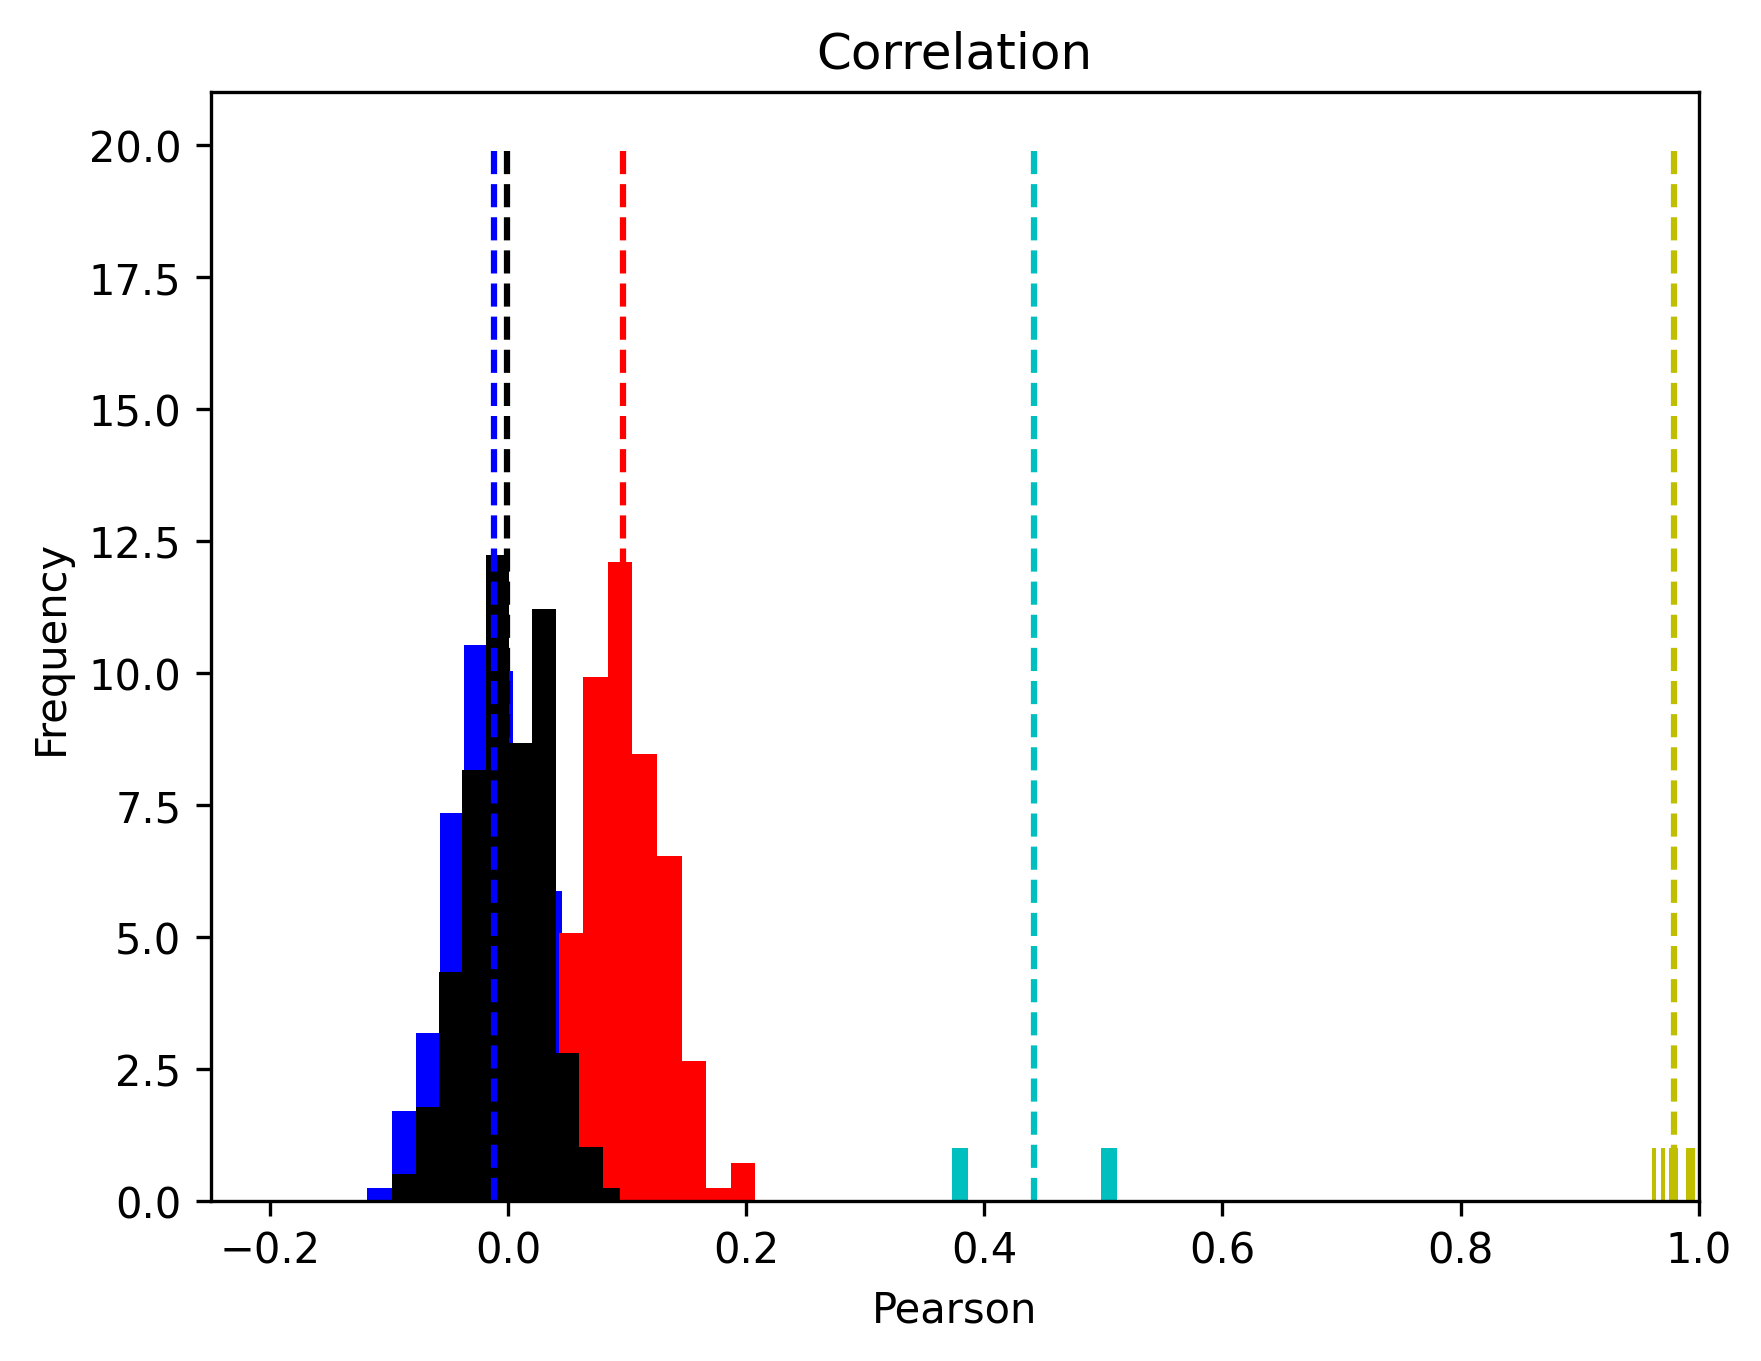

In [48]:

# Simulations
mean_rc = np.mean(x_random_cell)
mean_rc_model = np.abs(np.mean(x_random_cell_model))
mean_cr = np.mean(complete_random_x)

plt.hist(x_random_cell, density=True,color = 'b')
plt.hist(np.abs(x_random_cell_model), density=True,color = 'r')
plt.hist(complete_random_x, density=True,color = 'k')

plt.plot([mean_rc,mean_rc],[0,20],'--b')
plt.plot([mean_rc_model,mean_rc_model],[0,20],'--r')
plt.plot([mean_cr,mean_cr],[0,20],'--k')

# Data
plt.hist(spike_pearson,color = 'y')
mean_spike = np.mean(spike_pearson)
mean_spike_P = np.mean(spike_pearson_P)
plt.plot([mean_spike,mean_spike],[0,20],'--y')

plt.hist(data_pearson,color = 'c')
mean_data = np.mean(data_pearson)
mean_data_P = np.mean(data_pearson_P)
plt.plot([mean_data,mean_data],[0,20],'--c')


print(mean_rc ,mean_rc_model, mean_cr, mean_spike, mean_data)
print(mean_rc_P ,mean_rc_model_P, mean_cr_P, mean_spike_P, mean_data_P)

plt.xlim(-.25,1)
plt.title('Correlation')    
plt.ylabel('Frequency');
plt.xlabel('Pearson');
#plt.legend(["Real growth rates","Gaussian growth rates","Random shuffle","Spike-in","Data"])

#plt.savefig("/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/model_plots"+"/Person.pdf", bbox_inches='tight')

In [49]:
data_pearson_P

[8.558469673409713e-05,
 0.0005672215117717955,
 0.0013496582792599174,
 0.013295296067666662,
 0.2483143296054089,
 0.015158883098643454]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Simulation v.s. Data: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.970e-04 U_stat=0.000e+00
Data v.s. Spike: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.429e-01 U_stat=0.000e+00


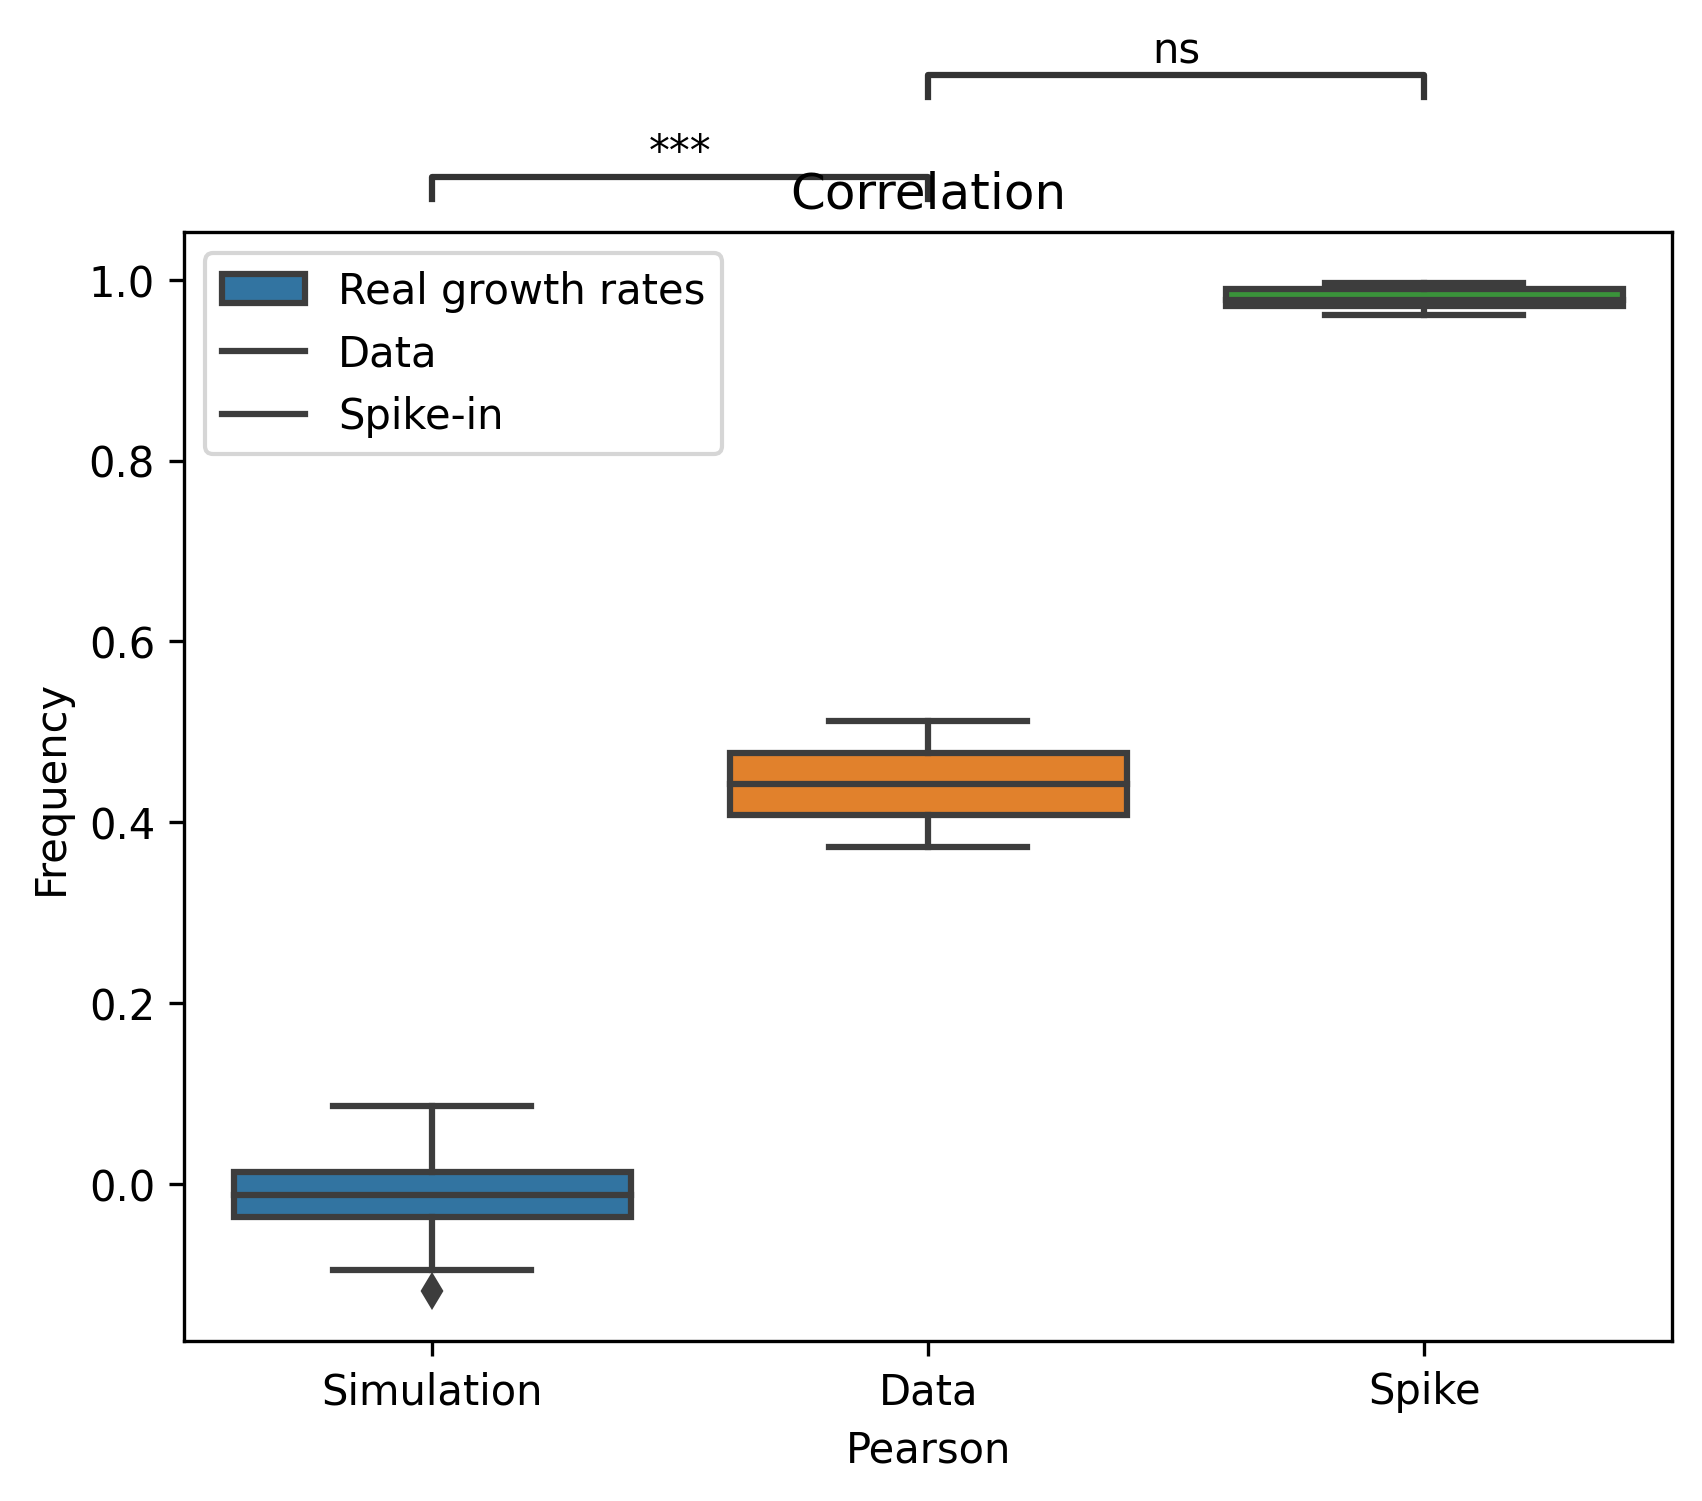

In [57]:
# Simulations
mean_rc = np.mean(x_random_cell)
mean_rc_model = np.abs(np.mean(x_random_cell_model))
mean_cr = np.mean(complete_random_x)


import seaborn as sns
from statannot import add_stat_annotation

nestedlist = [x_random_cell,data_pearson,spike_pearson]
val = [element for sublist in nestedlist for element in sublist]

nestedlist =  [["Simulation"]*len(x_random_cell),["Data"]*len(data_pearson),["Spike"]*len(spike_pearson)]
ID_v = [element for sublist in nestedlist for element in sublist]

#sns.boxplot(data=[x_random_cell,data_pearson,spike_pearson])

d = {'values': val, 'ID': ID_v}

df = pd.DataFrame(data=d)


x = "ID"
y = "values"
order = ["Simulation", "Data", "Spike"]
ax = sns.boxplot(data=df, x=x, y=y, order=order)
add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                    box_pairs=[("Simulation", "Data"), ("Data", "Spike")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

# plt.xlim(-.25,1)
plt.title('Correlation')    
plt.ylabel('Frequency');
plt.xlabel('Pearson');
plt.legend(["Real growth rates","Data","Spike-in"])

#plt.savefig("/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/model_plots"+"/Person_boxplot.pdf", bbox_inches='tight')




In [59]:
mean_rc

-0.012135677116158443

['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']

In [37]:
import os

os.system('jupyter nbconvert --to html /Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/Code/split_barcode.ipynb')





256

In [40]:
!jupyter nbconvert --execute --to html /Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/split_barcode/Code/split_barcode.ipynb



shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Traceback (most recent call last):
  File "/Users/raul/opt/anaconda3/lib/python3.8/site-packages/traitlets/traitlets.py", line 535, in get
    value = obj._trait_values[self.name]
KeyError: 'template_paths'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/raul/opt/anaconda3/lib/python3.8/site-packages/traitlets/traitlets.py", line 535, in get
    value = obj._trait_values[self.name]
KeyError: 'extra_template_basedirs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/raul/opt/anaconda3/bin/jupyter-nbconvert", line 7, in <module>
    from nbconvert.nbconvertapp import main
  File "/Users/raul/opt/anaconda3/lib/python3.8/site-packages/nbconvert/nbconvertapp.py", line 140, in <module>
    class NbConvertApp(JupyterApp):
  File "/Users/r